# PMF-GWR-Xgboost

/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_2591/668805563.py:71: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_geometries = gdf.geometry.buffer(buf / 111320)
/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_2591/668805563.py:71: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_geometries = gdf.geometry.buffer(buf / 111320)
/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_2591/668805563.py:71: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_geometries = gdf.geometry.buffer(buf / 111320)
/var/folders/nk/5ry1y2d128x8fgnl55


PMF Source Profiles (F):
          CrR        NiR        CuR       AsR       CdR        PbR         MR  \
0   1.011394   0.736558   1.692247  0.281341  0.081750   1.820546   0.744546   
1   6.361288   2.934156   7.088633  1.445853  0.265187   5.471062   3.794235   
2  21.198226  13.542373  26.909206  5.147733  1.449371  21.855110  14.985165   

       SandR      SiltR      ClayR           FeR  
0   0.626923   0.857056   0.708029    811.577541  
1   4.450678   3.851341   2.797802   3334.739331  
2  16.238105  14.757198  12.760148  12485.904320  


[I 2025-08-13 10:28:35,319] Trial 1 finished with value: -0.9823389068373719 and parameters: {'n_estimators': 556, 'learning_rate': 0.013046325083998419, 'max_depth': 8, 'subsample': 0.6637392288713959, 'colsample_bytree': 0.7121223044306655, 'reg_lambda': 8.460893825769205, 'reg_alpha': 1.7825025381101034}. Best is trial 0 with value: -0.9967391959627846.
[I 2025-08-13 10:28:35,470] Trial 2 finished with value: -0.9907162934229792 and parameters: {'n_estimators': 399, 'learning_rate': 0.05737775528992611, 'max_depth': 5, 'subsample': 0.6536796933625474, 'colsample_bytree': 0.6210437085040117, 'reg_lambda': 7.016064341751523, 'reg_alpha': 2.21928797349986}. Best is trial 0 with value: -0.9967391959627846.
[I 2025-08-13 10:28:35,663] Trial 3 finished with value: -0.983688982946571 and parameters: {'n_estimators': 532, 'learning_rate': 0.09293909767272973, 'max_depth': 4, 'subsample': 0.9073537269936782, 'colsample_bytree': 0.9901734009825052, 'reg_lambda': 6.459902021812296, 'reg_alpha'


✅ Best Parameters from Optuna: {'n_estimators': 345, 'learning_rate': 0.27244316722103273, 'max_depth': 5, 'subsample': 0.7073691983835306, 'colsample_bytree': 0.600315134637067, 'reg_lambda': 5.919090088283211, 'reg_alpha': 2.496532666825796}

✅ Final Model Performance:
R² Train: 1.0000 | RMSE Train: 0.2822
R² Test: 0.9975 | RMSE Test: 3.9290


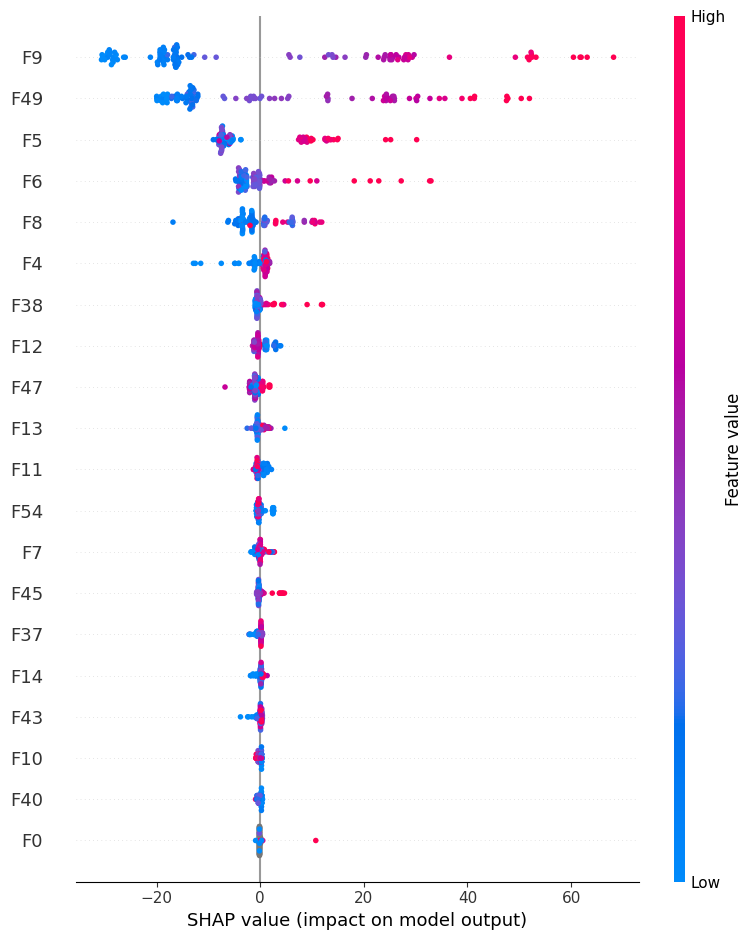

/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_2591/668805563.py:219: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train, feature_names=[f"F{i}" for i in range(X_train.shape[1])], plot_type="bar")


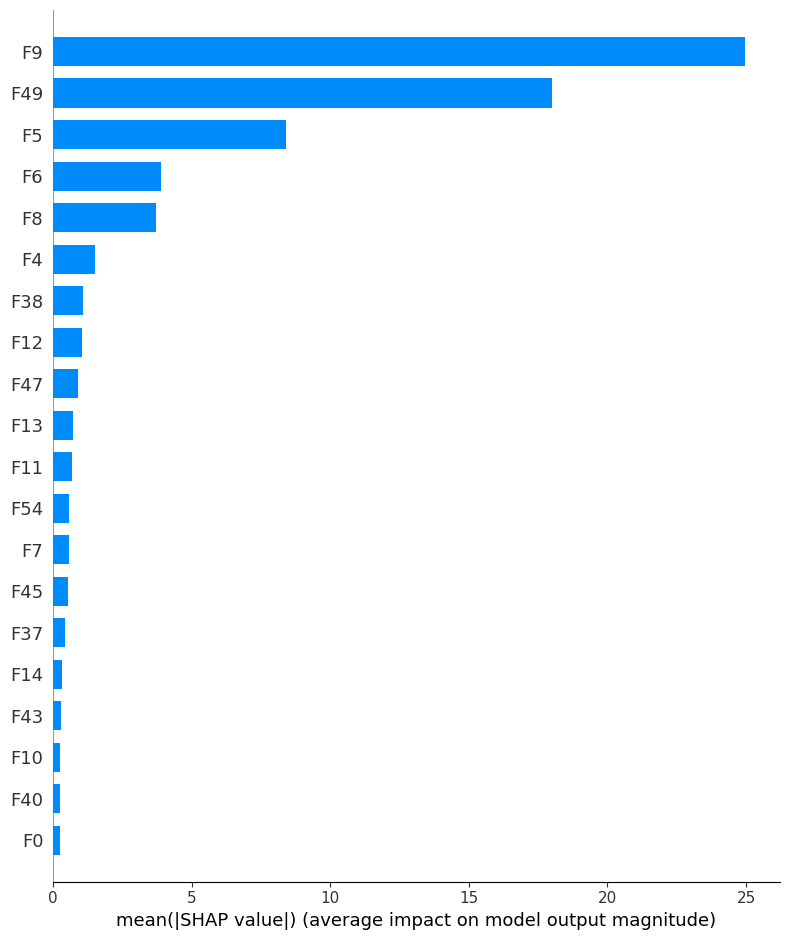

✅ SHAP analysis complete. Check plots for feature importance.

✅ Top Features (XGBoost Gain):
                              Feature  Importance
49                    Pb_R_500m_mean    0.471621
9                                PbR    0.365919
5                                NiR    0.097189
6                                CuR    0.019139
8                                CdR    0.014421
45                     CuR_500m_mean    0.010197
47                     NiR_500m_mean    0.007011
4                                CrR    0.002467
12                             SiltR    0.002136
7                                AsR    0.001532
11                             SandR    0.001201
43                     CrR_500m_mean    0.001020
13                             ClayR    0.001016
38                      AsR_500m_std    0.000806
0    hydrological_dist_to_nearest_BF    0.000709
52                    SandR_500m_std    0.000696
37                     AsR_500m_mean    0.000638
10                     

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import rasterio
import rasterstats
from rasterstats import zonal_stats
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor
import optuna
import shap
from scipy.spatial import cKDTree
import os

# ==================== 1. Load Data ==================== #
# Load the main dataset and the river sampling data.
original = pd.read_csv("../../data/RainySeason.csv")
river_100 = pd.read_csv("../data/Samples_100.csv")
river_100.drop(columns="Source", inplace=True)

# Identify columns for feature engineering and prediction
drop_cols = ['Stations', 'River', 'Lat', 'Long', 'geometry']
numeric_cols = original.drop(columns=drop_cols).columns.drop('RI')

# Split original data into train and test sets for the ensemble model.
# This ensures a fair evaluation on unseen data points.
np.random.seed(42)
train_idx = np.random.choice(len(original), 10, replace=False)
test_idx = [i for i in range(len(original)) if i not in train_idx]
train_orig = original.iloc[train_idx]
test_orig = original.iloc[test_idx]

# Combine the river samples and the original training data to form the full training set.
train_combined = pd.concat([river_100, train_orig], ignore_index=True)

# ==================== 2. Extract Multi-Scale Raster Features ==================== #
# Define the raster files and buffer sizes for zonal statistics.
raster_files = [
    "../CalIndices/ndwi.tif", "../CalIndices/ndvi.tif", "../CalIndices/ndbi.tif",
    "../CalIndices/awei.tif", "../CalIndices/bui.tif", "../CalIndices/evi.tif",
    "../CalIndices/mndwi.tif", "../CalIndices/ndbsi.tif", "../CalIndices/ndsi.tif",
    "../CalIndices/savi.tif", "../CalIndices/ui.tif", 
    "../IDW/AsR.tif", "../IDW/CdR.tif", "../IDW/ClayR.tif", "../IDW/CrR.tif", "../IDW/CuR.tif",
    "../IDW/NiR.tif", "../IDW/Pb_R.tif", "../IDW/SandR.tif", "../IDW/SiltR.tif",
    "../LULCMerged/LULC2017.tif", "../LULCMerged/LULC2018.tif", "../LULCMerged/LULC2019.tif",
    "../LULCMerged/LULC2020.tif", "../LULCMerged/LULC2021.tif", "../LULCMerged/LULC2022.tif"

]


buffers = [500]

def extract_raster_stats(points_df, rasters, buffers):
    """
    Extracts zonal statistics (mean, std) from raster files for points
    within specified buffer distances.
    """
    # Create a GeoDataFrame from the points for spatial operations
    gdf = gpd.GeoDataFrame(points_df, geometry=gpd.points_from_xy(points_df.Long, points_df.Lat), crs="EPSG:4326")
    features = pd.DataFrame(index=gdf.index)

    for raster_path in rasters:
        for buf in buffers:
            col_mean = f"{os.path.basename(raster_path).split('.')[0]}_{buf}m_mean"
            col_std = f"{os.path.basename(raster_path).split('.')[0]}_{buf}m_std"

            # Create a buffer around each point (converted from meters to degrees)
            # The value 111320 is a rough conversion factor from degrees to meters at the equator.
            buffered_geometries = gdf.geometry.buffer(buf / 111320)
            
            # Use rasterstats to get zonal statistics for the buffered areas
            zs_results = zonal_stats(buffered_geometries, raster_path, stats=['mean', 'std'], nodata=np.nan)

            features[col_mean] = [res['mean'] for res in zs_results]
            features[col_std] = [res['std'] for res in zs_results]
    
    return features

# Extract raster features for both the training and testing data
train_raster_feats = extract_raster_stats(train_combined, raster_files, buffers)
test_raster_feats = extract_raster_stats(test_orig, raster_files, buffers)

# ==================== 3. PMF (NMF) for Source Apportionment ==================== #
# Use Non-Negative Matrix Factorization to identify latent source factors.
pmf_features = ['CrR', 'NiR', 'CuR', 'AsR', 'CdR', 'PbR', 'MR', 'SandR', 'SiltR', 'ClayR', 'FeR']
nmf = NMF(n_components=3, init='random', random_state=42, max_iter=100)
G_train = nmf.fit_transform(train_combined[pmf_features].values)
F = nmf.components_
print("\nPMF Source Profiles (F):\n", pd.DataFrame(F, columns=pmf_features))

# ==================== 4. Fixed Geographically Weighted Regression (GWR) ==================== #
# Implement a custom GWR function to model spatial non-stationarity.
def gaussian_kernel(d, bw):
    return np.exp(-(d**2) / (2 * bw**2))

def fixed_gwr(coords, factors, y, bw=0.5):
    """
    Performs a fixed bandwidth GWR using a Gaussian kernel.
    """
    n = len(coords)
    preds = np.zeros(n)
    X = np.hstack([np.ones((n, 1)), factors])
    for i in range(n):
        dist = np.linalg.norm(coords - coords[i], axis=1)
        W = np.diag(gaussian_kernel(dist, bw))
        # Use pseudo-inverse for stability
        beta = np.linalg.pinv(X.T @ W @ X) @ (X.T @ W @ y.reshape(-1, 1))
        preds[i] = (np.array([1] + list(factors[i])) @ beta).item()
    return preds.reshape(-1, 1)

coords_train = train_combined[['Long', 'Lat']].values
y_train = train_combined['RI'].values
GWR_train = fixed_gwr(coords_train, G_train, y_train, bw=0.5)

# Interpolate PMF factors for the test set using Inverse Distance Weighting (IDW)
def idw_interpolation(known_coords, known_values, query_coords, power=2):
    """
    Performs IDW to interpolate values from known points to query points.
    """
    tree = cKDTree(known_coords)
    dists, idxs = tree.query(query_coords, k=4)
    dists[dists == 0] = 1e-10  # Avoid division by zero
    weights = 1 / (dists ** power)
    weights /= weights.sum(axis=1)[:, None]
    return np.sum(weights * known_values[idxs], axis=1)

coords_test = test_orig[['Long', 'Lat']].values
y_test = test_orig['RI'].values
# Interpolate PMF factors for the test set
G_test = np.column_stack([idw_interpolation(coords_train, G_train[:, i], coords_test) for i in range(G_train.shape[1])])
# Apply GWR to the interpolated PMF factors for the test set
GWR_test = fixed_gwr(coords_test, G_test, y_test, bw=0.5)

# ==================== 5. Interaction Features ==================== #
# Create new features by interacting PMF and GWR results.
def create_interactions(pmf, gwr):
    """
    Creates interaction features between PMF factors and GWR predictions.
    """
    interactions = pd.DataFrame()
    for i in range(pmf.shape[1]):
        interactions[f"PMF{i}_GWR"] = pmf[:, i] * gwr.flatten()
    return interactions

train_interact = create_interactions(G_train, GWR_train)
test_interact = create_interactions(G_test, GWR_test)

# ==================== 6. Final Feature Matrix ==================== #
# Combine all engineered features into a single matrix for the XGBoost model.
X_train = np.hstack([
    train_combined[numeric_cols].values,
    train_raster_feats.values,
    G_train,
    GWR_train,
    train_interact.values
])

X_test = np.hstack([
    test_orig[numeric_cols].values,
    test_raster_feats.values,
    G_test,
    GWR_test,
    test_interact.values
])

# ==================== 7. Optuna Hyperparameter Optimization ==================== #
def objective(trial):
    """
    Defines the Optuna objective function to minimize negative R².
    """
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 600),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5)
    }
    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return -r2_score(y_test, y_pred)

# Run the Optuna study to find the best parameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25)
best_params = study.best_params
print("\n✅ Best Parameters from Optuna:", best_params)

# ==================== 8. Train Final XGBoost ==================== #
# Train the final model with the optimized hyperparameters.
xgb = XGBRegressor(**best_params, random_state=42)
xgb.fit(X_train, y_train)

# ==================== 9. Evaluation ==================== #
# Evaluate the final model's performance on both training and test data.
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"\n✅ Final Model Performance:")
print(f"R² Train: {r2_train:.4f} | RMSE Train: {rmse_train:.4f}")
print(f"R² Test: {r2_test:.4f} | RMSE Test: {rmse_test:.4f}")

# ==================== 10. SHAP Interpretation ==================== #
# Use SHAP to explain the model's predictions and feature importance.
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)

# Generate SHAP summary plots
shap.summary_plot(shap_values, X_train, feature_names=[f"F{i}" for i in range(X_train.shape[1])])
shap.summary_plot(shap_values, X_train, feature_names=[f"F{i}" for i in range(X_train.shape[1])], plot_type="bar")

print("✅ SHAP analysis complete. Check plots for feature importance.")

feature_names = list(numeric_cols) \
                + list(train_raster_feats.columns) \
                + [f"PMF_Factor{i}" for i in range(G_train.shape[1])] \
                + ["GWR_Adjusted"] \
                + list(train_interact.columns)

# Create DataFrame of importance
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": xgb.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Save & print
importance_df.to_csv("SHAP-PMF-GLWR-Xgboost.csv", index=False)
print("\n✅ Top Features (XGBoost Gain):\n", importance_df.head(30))

/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_4060/942225979.py:71: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_geometries = gdf.geometry.buffer(buf / 111320)
/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_4060/942225979.py:71: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_geometries = gdf.geometry.buffer(buf / 111320)
/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_4060/942225979.py:71: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_geometries = gdf.geometry.buffer(buf / 111320)
/var/folders/nk/5ry1y2d128x8fgnl55


PMF Source Profiles (F):
          CrR        NiR        CuR       AsR       CdR        PbR         MR  \
0   0.961540   0.704058   1.636377  0.265718  0.077563   1.753823   0.722294   
1   4.964149   2.597048   5.703547  0.942491  0.311027   5.706320   2.725115   
2  25.542785  12.377293  26.751550  5.311479  1.574210  23.217031  14.845736   

       SandR      SiltR      ClayR           FeR  
0   0.604440   0.835901   0.670266    781.195881  
1   2.422355   3.007888   2.625702   2638.577939  
2  15.054804  16.081543  12.821678  13124.520030  


[I 2025-08-11 11:05:33,315] Trial 0 finished with value: -0.9605959585291662 and parameters: {'n_estimators': 237, 'learning_rate': 0.1379685312479051, 'max_depth': 3, 'subsample': 0.9074108210310408, 'colsample_bytree': 0.983808962495021, 'reg_lambda': 9.232833099736629, 'reg_alpha': 0.5120741550692554}. Best is trial 0 with value: -0.9605959585291662.
[I 2025-08-11 11:05:33,514] Trial 1 finished with value: -0.9280868468967756 and parameters: {'n_estimators': 552, 'learning_rate': 0.2501295487510085, 'max_depth': 8, 'subsample': 0.966487001030288, 'colsample_bytree': 0.6417250209142515, 'reg_lambda': 2.709373475007811, 'reg_alpha': 3.974822157354539}. Best is trial 0 with value: -0.9605959585291662.
[I 2025-08-11 11:05:33,668] Trial 2 finished with value: -0.9555335829000006 and parameters: {'n_estimators': 289, 'learning_rate': 0.18903586201859868, 'max_depth': 3, 'subsample': 0.984861351331838, 'colsample_bytree': 0.7415772555406844, 'reg_lambda': 9.101114811656347, 'reg_alpha': 1.


Best Parameters from Optuna: {'n_estimators': 201, 'learning_rate': 0.15321339168849915, 'max_depth': 7, 'subsample': 0.7612466279640389, 'colsample_bytree': 0.7311296487169077, 'reg_lambda': 5.252919059599164, 'reg_alpha': 0.08672522652949056}

Final Model Performance:
R² Train: 1.0000 | RMSE Train: 0.0122
R² Test: 0.9830 | RMSE Test: 0.6669


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_4060/942225979.py:218: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train, feature_names=[f"F{i}" for i in range(X_train.shape[1])])


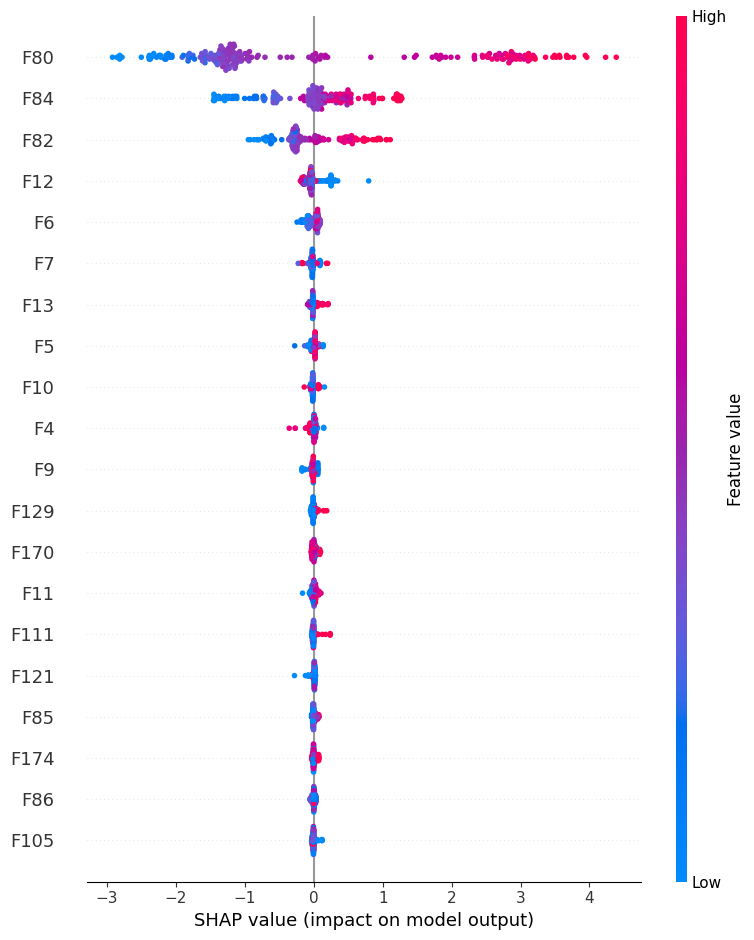

/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_4060/942225979.py:219: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train, feature_names=[f"F{i}" for i in range(X_train.shape[1])], plot_type="bar")


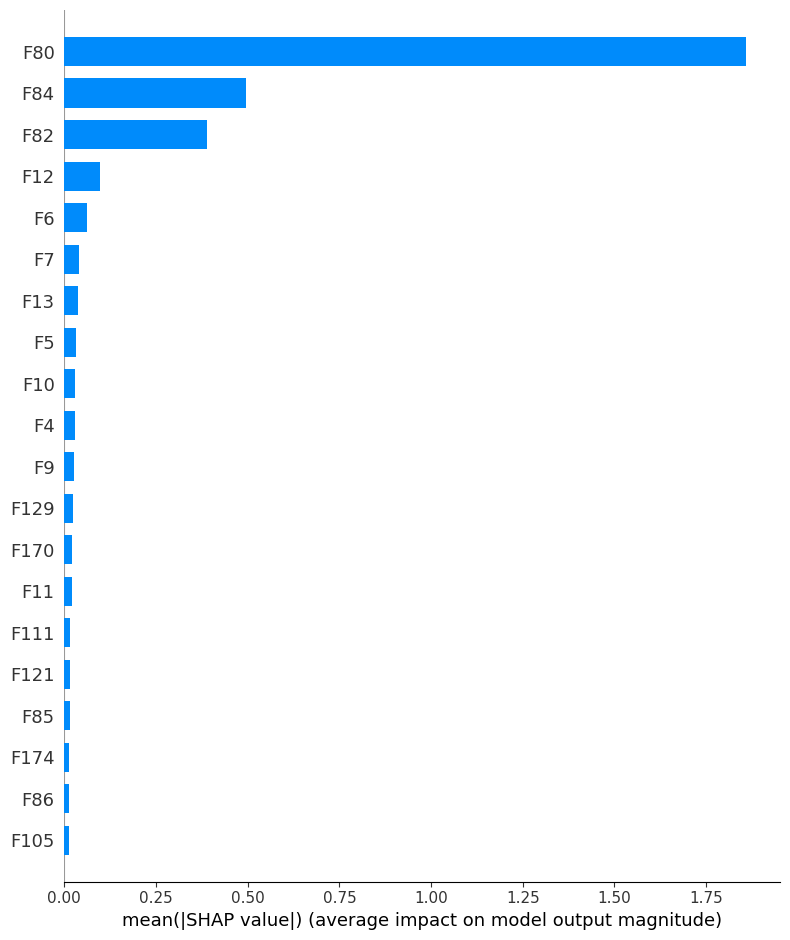

SHAP analysis complete. Check plots for feature importance.

Top Features (XGBoost Gain):
               Feature  Importance
80      AsR_500m_mean    0.427384
84     AsR_2000m_mean    0.356742
82     AsR_1000m_mean    0.172078
12              ClayR    0.006133
7                 CdR    0.003826
174          PMF0_GWR    0.002677
10              SandR    0.002590
9                  MR    0.002185
13                FeR    0.001468
129    SiltR_500m_std    0.001447
6                 CuR    0.001367
89      CdR_1000m_std    0.001042
88     CdR_1000m_mean    0.000975
85      AsR_2000m_std    0.000903
124  SandR_1000m_mean    0.000882
127   SandR_2000m_std    0.000825
5                 NiR    0.000762
175          PMF1_GWR    0.000738
98      CrR_500m_mean    0.000734
91      CdR_2000m_std    0.000673
95    ClayR_1000m_std    0.000662
4                 CrR    0.000622
8                 PbR    0.000622
170       PMF_Factor0    0.000606
109     CuR_2000m_std    0.000589
86      CdR_500m_mean    

In [5]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import rasterio
import rasterstats
from rasterstats import zonal_stats
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor
import optuna
import shap
from scipy.spatial import cKDTree
import os

# ==================== 1. Load Data ==================== #
# Load the main dataset and the river sampling data.
original = pd.read_csv("../../data/RainySeason.csv")
river_100 = pd.read_csv("../data/Samples_200.csv")
river_100.drop(columns="Source", inplace=True)

# Identify columns for feature engineering and prediction
drop_cols = ['Stations', 'River', 'Lat', 'Long', 'geometry']
numeric_cols = original.drop(columns=drop_cols).columns.drop('AsR')

# Split original data into train and test sets for the ensemble model.
# This ensures a fair evaluation on unseen data points.
np.random.seed(42)
train_idx = np.random.choice(len(original), 10, replace=False)
test_idx = [i for i in range(len(original)) if i not in train_idx]
train_orig = original.iloc[train_idx]
test_orig = original.iloc[test_idx]

# Combine the river samples and the original training data to form the full training set.
train_combined = pd.concat([river_100, train_orig], ignore_index=True)

# ==================== 2. Extract Multi-Scale Raster Features ==================== #
# Define the raster files and buffer sizes for zonal statistics.
raster_files = [
    "../CalIndices/ndwi.tif", "../CalIndices/ndvi.tif", "../CalIndices/ndbi.tif",
    "../CalIndices/awei.tif", "../CalIndices/bui.tif", "../CalIndices/evi.tif",
    "../CalIndices/mndwi.tif", "../CalIndices/ndbsi.tif", "../CalIndices/ndsi.tif",
    "../CalIndices/savi.tif", "../CalIndices/ui.tif",
    "../IDW/AsR.tif", "../IDW/CdR.tif", "../IDW/ClayR.tif", "../IDW/CrR.tif", "../IDW/CuR.tif",
    "../IDW/NiR.tif", "../IDW/Pb_R.tif", "../IDW/SandR.tif", "../IDW/SiltR.tif",
    "../LULCMerged/LULC2017.tif", "../LULCMerged/LULC2018.tif", "../LULCMerged/LULC2019.tif",
    "../LULCMerged/LULC2020.tif", "../LULCMerged/LULC2021.tif", "../LULCMerged/LULC2022.tif"

]


buffers = [500, 1000, 2000]

def extract_raster_stats(points_df, rasters, buffers):
    """
    Extracts zonal statistics (mean, std) from raster files for points
    within specified buffer distances.
    """
    # Create a GeoDataFrame from the points for spatial operations
    gdf = gpd.GeoDataFrame(points_df, geometry=gpd.points_from_xy(points_df.Long, points_df.Lat), crs="EPSG:4326")
    features = pd.DataFrame(index=gdf.index)

    for raster_path in rasters:
        for buf in buffers:
            col_mean = f"{os.path.basename(raster_path).split('.')[0]}_{buf}m_mean"
            col_std = f"{os.path.basename(raster_path).split('.')[0]}_{buf}m_std"

            # Create a buffer around each point (converted from meters to degrees)
            # The value 111320 is a rough conversion factor from degrees to meters at the equator.
            buffered_geometries = gdf.geometry.buffer(buf / 111320)
            
            # Use rasterstats to get zonal statistics for the buffered areas
            zs_results = zonal_stats(buffered_geometries, raster_path, stats=['mean', 'std'], nodata=np.nan)

            features[col_mean] = [res['mean'] for res in zs_results]
            features[col_std] = [res['std'] for res in zs_results]
    
    return features

# Extract raster features for both the training and testing data
train_raster_feats = extract_raster_stats(train_combined, raster_files, buffers)
test_raster_feats = extract_raster_stats(test_orig, raster_files, buffers)

# ==================== 3. PMF (NMF) for Source Apportionment ==================== #
# Use Non-Negative Matrix Factorization to identify latent source factors.
pmf_features = ['CrR', 'NiR', 'CuR', 'AsR', 'CdR', 'PbR', 'MR', 'SandR', 'SiltR', 'ClayR', 'FeR']
nmf = NMF(n_components=3, init='random', random_state=42, max_iter=1000)
G_train = nmf.fit_transform(train_combined[pmf_features].values)
F = nmf.components_
print("\nPMF Source Profiles (F):\n", pd.DataFrame(F, columns=pmf_features))

# ==================== 4. Fixed Geographically Weighted Regression (GWR) ==================== #
# Implement a custom GWR function to model spatial non-stationarity.
def gaussian_kernel(d, bw):
    return np.exp(-(d**2) / (2 * bw**2))

def fixed_gwr(coords, factors, y, bw=0.5):
    """
    Performs a fixed bandwidth GWR using a Gaussian kernel.
    """
    n = len(coords)
    preds = np.zeros(n)
    X = np.hstack([np.ones((n, 1)), factors])
    for i in range(n):
        dist = np.linalg.norm(coords - coords[i], axis=1)
        W = np.diag(gaussian_kernel(dist, bw))
        # Use pseudo-inverse for stability
        beta = np.linalg.pinv(X.T @ W @ X) @ (X.T @ W @ y.reshape(-1, 1))
        preds[i] = (np.array([1] + list(factors[i])) @ beta).item()
    return preds.reshape(-1, 1)

coords_train = train_combined[['Long', 'Lat']].values
y_train = train_combined['AsR'].values
GWR_train = fixed_gwr(coords_train, G_train, y_train, bw=0.5)

# Interpolate PMF factors for the test set using Inverse Distance Weighting (IDW)
def idw_interpolation(known_coords, known_values, query_coords, power=2):
    """
    Performs IDW to interpolate values from known points to query points.
    """
    tree = cKDTree(known_coords)
    dists, idxs = tree.query(query_coords, k=4)
    dists[dists == 0] = 1e-10  # Avoid division by zero
    weights = 1 / (dists ** power)
    weights /= weights.sum(axis=1)[:, None]
    return np.sum(weights * known_values[idxs], axis=1)

coords_test = test_orig[['Long', 'Lat']].values
y_test = test_orig['AsR'].values
# Interpolate PMF factors for the test set
G_test = np.column_stack([idw_interpolation(coords_train, G_train[:, i], coords_test) for i in range(G_train.shape[1])])
# Apply GWR to the interpolated PMF factors for the test set
GWR_test = fixed_gwr(coords_test, G_test, y_test, bw=0.5)

# ==================== 5. Interaction Features ==================== #
# Create new features by interacting PMF and GWR results.
def create_interactions(pmf, gwr):
    """
    Creates interaction features between PMF factors and GWR predictions.
    """
    interactions = pd.DataFrame()
    for i in range(pmf.shape[1]):
        interactions[f"PMF{i}_GWR"] = pmf[:, i] * gwr.flatten()
    return interactions

train_interact = create_interactions(G_train, GWR_train)
test_interact = create_interactions(G_test, GWR_test)

# ==================== 6. Final Feature Matrix ==================== #
# Combine all engineered features into a single matrix for the XGBoost model.
X_train = np.hstack([
    train_combined[numeric_cols].values,
    train_raster_feats.values,
    G_train,
    GWR_train,
    train_interact.values
])

X_test = np.hstack([
    test_orig[numeric_cols].values,
    test_raster_feats.values,
    G_test,
    GWR_test,
    test_interact.values
])

# ==================== 7. Optuna Hyperparameter Optimization ==================== #
def objective(trial):
    """
    Defines the Optuna objective function to minimize negative R².
    """
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 600),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5)
    }
    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return -r2_score(y_test, y_pred)

# Run the Optuna study to find the best parameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25)
best_params = study.best_params
print("\nBest Parameters from Optuna:", best_params)

# ==================== 8. Train Final XGBoost ==================== #
# Train the final model with the optimized hyperparameters.
xgb = XGBRegressor(**best_params, random_state=42)
xgb.fit(X_train, y_train)

# ==================== 9. Evaluation ==================== #
# Evaluate the final model's performance on both training and test data.
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"\nFinal Model Performance:")
print(f"R² Train: {r2_train:.4f} | RMSE Train: {rmse_train:.4f}")
print(f"R² Test: {r2_test:.4f} | RMSE Test: {rmse_test:.4f}")

# ==================== 10. SHAP Interpretation ==================== #
# Use SHAP to explain the model's predictions and feature importance.
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)

# Generate SHAP summary plots
shap.summary_plot(shap_values, X_train, feature_names=[f"F{i}" for i in range(X_train.shape[1])])
shap.summary_plot(shap_values, X_train, feature_names=[f"F{i}" for i in range(X_train.shape[1])], plot_type="bar")

print("SHAP analysis complete. Check plots for feature importance.")

feature_names = list(numeric_cols) \
                + list(train_raster_feats.columns) \
                + [f"PMF_Factor{i}" for i in range(G_train.shape[1])] \
                + ["GWR_Adjusted"] \
                + list(train_interact.columns)

# Create DataFrame of importance
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": xgb.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Save & print
importance_df.to_csv("SHAP-PMF-GLWR-Xgboost.csv", index=False)
print("\nTop Features (XGBoost Gain):\n", importance_df.head(30))


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_4060/1849737970.py:71: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_geometries = gdf.geometry.buffer(buf / 111320)
/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_4060/1849737970.py:71: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_geometries = gdf.geometry.buffer(buf / 111320)
/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_4060/1849737970.py:71: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_geometries = gdf.geometry.buffer(buf / 111320)
/var/folders/nk/5ry1y2d128x8fgn


PMF Source Profiles (F):
          CrR        NiR        CuR       AsR       CdR        PbR         MR  \
0   1.011389   0.736567   1.692243  0.281334  0.081748   1.820547   0.744549   
1   6.361217   2.933900   7.088545  1.445830  0.265560   5.471049   3.793943   
2  21.197896  13.541837  26.909527  5.148483  1.449400  21.854976  14.985015   

       SandR      SiltR      ClayR           FeR  
0   0.626930   0.857063   0.708036    811.577481  
1   4.450762   3.851295   2.797844   3334.740535  
2  16.237624  14.758396  12.759443  12485.992078  


[I 2025-08-11 11:16:40,680] Trial 1 finished with value: -0.9365270300802844 and parameters: {'n_estimators': 273, 'learning_rate': 0.22363279452254514, 'max_depth': 8, 'subsample': 0.8949234039430543, 'colsample_bytree': 0.739651082290796, 'reg_lambda': 3.092986525867082, 'reg_alpha': 0.9386161595367182}. Best is trial 0 with value: -0.9490638704298393.
[I 2025-08-11 11:16:40,784] Trial 2 finished with value: -0.9382752426704232 and parameters: {'n_estimators': 398, 'learning_rate': 0.16081776570399078, 'max_depth': 3, 'subsample': 0.6718815580639304, 'colsample_bytree': 0.807413439220453, 'reg_lambda': 1.7789433712019718, 'reg_alpha': 3.5009107616753523}. Best is trial 0 with value: -0.9490638704298393.
[I 2025-08-11 11:16:40,960] Trial 3 finished with value: -0.9504011471957837 and parameters: {'n_estimators': 516, 'learning_rate': 0.2539388012656014, 'max_depth': 4, 'subsample': 0.9511947296269092, 'colsample_bytree': 0.8213873904512122, 'reg_lambda': 4.603950471288655, 'reg_alpha'


Best Parameters from Optuna: {'n_estimators': 599, 'learning_rate': 0.09177741887684704, 'max_depth': 3, 'subsample': 0.8817470856833246, 'colsample_bytree': 0.9139406599980704, 'reg_lambda': 5.856421063179383, 'reg_alpha': 0.015550472957847599}

Final Model Performance:
R² Train: 1.0000 | RMSE Train: 0.0028
R² Test: 0.9877 | RMSE Test: 0.5675


/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_4060/1849737970.py:218: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train, feature_names=[f"F{i}" for i in range(X_train.shape[1])])


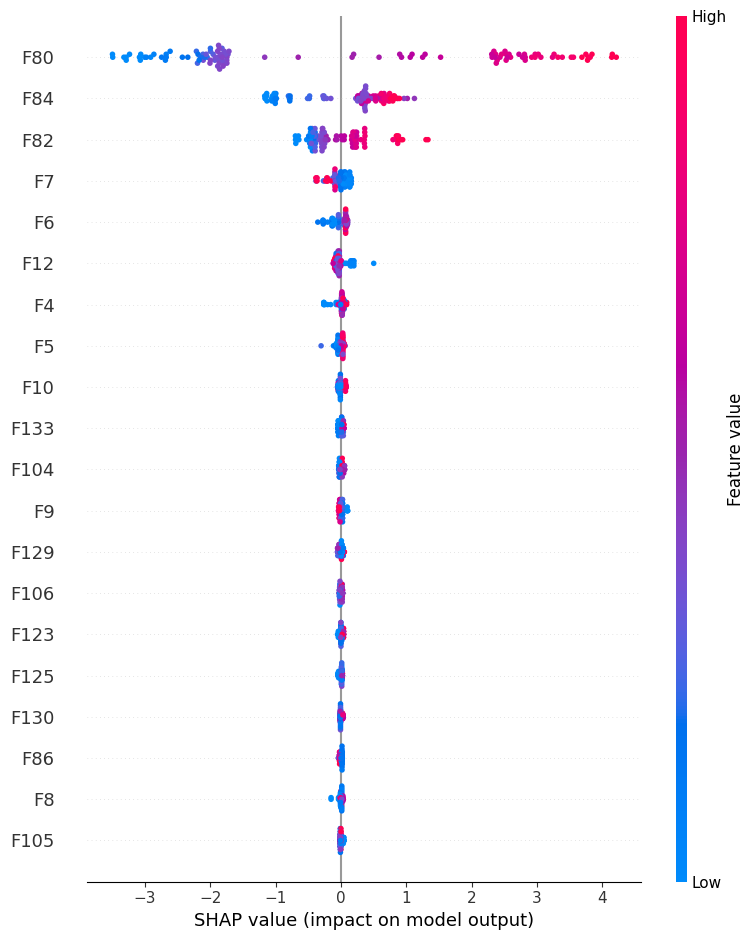

/var/folders/nk/5ry1y2d128x8fgnl550m4c_h0000gp/T/ipykernel_4060/1849737970.py:219: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train, feature_names=[f"F{i}" for i in range(X_train.shape[1])], plot_type="bar")


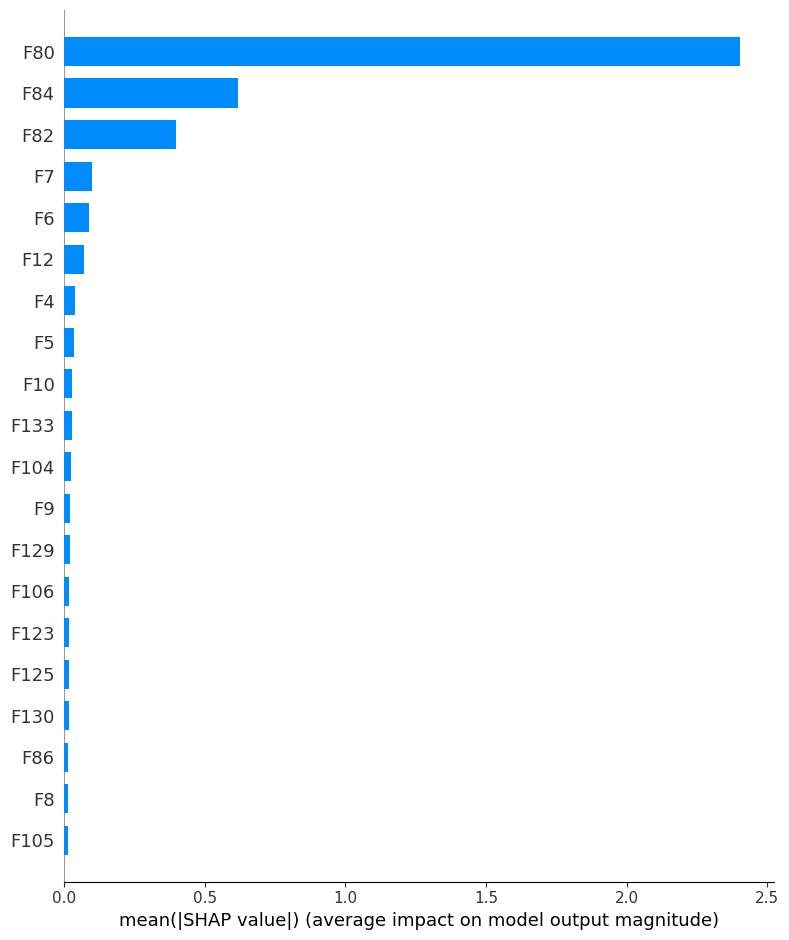

SHAP analysis complete. Check plots for feature importance.

Top Features (XGBoost Gain):
              Feature  Importance
80     AsR_500m_mean    0.646021
82    AsR_1000m_mean    0.219832
84    AsR_2000m_mean    0.073752
6                CuR    0.013091
7                CdR    0.009580
12             ClayR    0.003399
10             SandR    0.002833
104    CuR_500m_mean    0.002606
4                CrR    0.002138
1    num_upstream_BF    0.002136
89     CdR_1000m_std    0.001983
100   CrR_1000m_mean    0.001684
5                NiR    0.001561
125  SandR_1000m_std    0.001287
171      PMF_Factor1    0.001256
122  SandR_500m_mean    0.001253
106   CuR_1000m_mean    0.001249
9                 MR    0.001111
118  Pb_R_1000m_mean    0.001042
120  Pb_R_2000m_mean    0.000968
115    NiR_2000m_std    0.000962
133  SiltR_2000m_std    0.000814
8                PbR    0.000601
129   SiltR_500m_std    0.000590
107    CuR_1000m_std    0.000583
92   ClayR_500m_mean    0.000508
11             Sil

In [6]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import rasterio
import rasterstats
from rasterstats import zonal_stats
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor
import optuna
import shap
from scipy.spatial import cKDTree
import os

# ==================== 1. Load Data ==================== #
# Load the main dataset and the river sampling data.
original = pd.read_csv("../../data/RainySeason.csv")
river_100 = pd.read_csv("../data/Samples_100.csv")
river_100.drop(columns="Source", inplace=True)

# Identify columns for feature engineering and prediction
drop_cols = ['Stations', 'River', 'Lat', 'Long', 'geometry']
numeric_cols = original.drop(columns=drop_cols).columns.drop('AsR')

# Split original data into train and test sets for the ensemble model.
# This ensures a fair evaluation on unseen data points.
np.random.seed(42)
train_idx = np.random.choice(len(original), 10, replace=False)
test_idx = [i for i in range(len(original)) if i not in train_idx]
train_orig = original.iloc[train_idx]
test_orig = original.iloc[test_idx]

# Combine the river samples and the original training data to form the full training set.
train_combined = pd.concat([river_100, train_orig], ignore_index=True)

# ==================== 2. Extract Multi-Scale Raster Features ==================== #
# Define the raster files and buffer sizes for zonal statistics.
raster_files = [
    "../CalIndices/ndwi.tif", "../CalIndices/ndvi.tif", "../CalIndices/ndbi.tif",
    "../CalIndices/awei.tif", "../CalIndices/bui.tif", "../CalIndices/evi.tif",
    "../CalIndices/mndwi.tif", "../CalIndices/ndbsi.tif", "../CalIndices/ndsi.tif",
    "../CalIndices/savi.tif", "../CalIndices/ui.tif",
    "../IDW/AsR.tif", "../IDW/CdR.tif", "../IDW/ClayR.tif", "../IDW/CrR.tif", "../IDW/CuR.tif",
    "../IDW/NiR.tif", "../IDW/Pb_R.tif", "../IDW/SandR.tif", "../IDW/SiltR.tif",
    "../LULCMerged/LULC2017.tif", "../LULCMerged/LULC2018.tif", "../LULCMerged/LULC2019.tif",
    "../LULCMerged/LULC2020.tif", "../LULCMerged/LULC2021.tif", "../LULCMerged/LULC2022.tif"

]


buffers = [500, 1000, 2000]

def extract_raster_stats(points_df, rasters, buffers):
    """
    Extracts zonal statistics (mean, std) from raster files for points
    within specified buffer distances.
    """
    # Create a GeoDataFrame from the points for spatial operations
    gdf = gpd.GeoDataFrame(points_df, geometry=gpd.points_from_xy(points_df.Long, points_df.Lat), crs="EPSG:4326")
    features = pd.DataFrame(index=gdf.index)

    for raster_path in rasters:
        for buf in buffers:
            col_mean = f"{os.path.basename(raster_path).split('.')[0]}_{buf}m_mean"
            col_std = f"{os.path.basename(raster_path).split('.')[0]}_{buf}m_std"

            # Create a buffer around each point (converted from meters to degrees)
            # The value 111320 is a rough conversion factor from degrees to meters at the equator.
            buffered_geometries = gdf.geometry.buffer(buf / 111320)
            
            # Use rasterstats to get zonal statistics for the buffered areas
            zs_results = zonal_stats(buffered_geometries, raster_path, stats=['mean', 'std'], nodata=np.nan)

            features[col_mean] = [res['mean'] for res in zs_results]
            features[col_std] = [res['std'] for res in zs_results]
    
    return features

# Extract raster features for both the training and testing data
train_raster_feats = extract_raster_stats(train_combined, raster_files, buffers)
test_raster_feats = extract_raster_stats(test_orig, raster_files, buffers)

# ==================== 3. PMF (NMF) for Source Apportionment ==================== #
# Use Non-Negative Matrix Factorization to identify latent source factors.
pmf_features = ['CrR', 'NiR', 'CuR', 'AsR', 'CdR', 'PbR', 'MR', 'SandR', 'SiltR', 'ClayR', 'FeR']
nmf = NMF(n_components=3, init='random', random_state=42, max_iter=1000)
G_train = nmf.fit_transform(train_combined[pmf_features].values)
F = nmf.components_
print("\nPMF Source Profiles (F):\n", pd.DataFrame(F, columns=pmf_features))

# ==================== 4. Fixed Geographically Weighted Regression (GWR) ==================== #
# Implement a custom GWR function to model spatial non-stationarity.
def gaussian_kernel(d, bw):
    return np.exp(-(d**2) / (2 * bw**2))

def fixed_gwr(coords, factors, y, bw=0.5):
    """
    Performs a fixed bandwidth GWR using a Gaussian kernel.
    """
    n = len(coords)
    preds = np.zeros(n)
    X = np.hstack([np.ones((n, 1)), factors])
    for i in range(n):
        dist = np.linalg.norm(coords - coords[i], axis=1)
        W = np.diag(gaussian_kernel(dist, bw))
        # Use pseudo-inverse for stability
        beta = np.linalg.pinv(X.T @ W @ X) @ (X.T @ W @ y.reshape(-1, 1))
        preds[i] = (np.array([1] + list(factors[i])) @ beta).item()
    return preds.reshape(-1, 1)

coords_train = train_combined[['Long', 'Lat']].values
y_train = train_combined['AsR'].values
GWR_train = fixed_gwr(coords_train, G_train, y_train, bw=0.5)

# Interpolate PMF factors for the test set using Inverse Distance Weighting (IDW)
def idw_interpolation(known_coords, known_values, query_coords, power=2):
    """
    Performs IDW to interpolate values from known points to query points.
    """
    tree = cKDTree(known_coords)
    dists, idxs = tree.query(query_coords, k=4)
    dists[dists == 0] = 1e-10  # Avoid division by zero
    weights = 1 / (dists ** power)
    weights /= weights.sum(axis=1)[:, None]
    return np.sum(weights * known_values[idxs], axis=1)

coords_test = test_orig[['Long', 'Lat']].values
y_test = test_orig['AsR'].values
# Interpolate PMF factors for the test set
G_test = np.column_stack([idw_interpolation(coords_train, G_train[:, i], coords_test) for i in range(G_train.shape[1])])
# Apply GWR to the interpolated PMF factors for the test set
GWR_test = fixed_gwr(coords_test, G_test, y_test, bw=0.5)

# ==================== 5. Interaction Features ==================== #
# Create new features by interacting PMF and GWR results.
def create_interactions(pmf, gwr):
    """
    Creates interaction features between PMF factors and GWR predictions.
    """
    interactions = pd.DataFrame()
    for i in range(pmf.shape[1]):
        interactions[f"PMF{i}_GWR"] = pmf[:, i] * gwr.flatten()
    return interactions

train_interact = create_interactions(G_train, GWR_train)
test_interact = create_interactions(G_test, GWR_test)

# ==================== 6. Final Feature Matrix ==================== #
# Combine all engineered features into a single matrix for the XGBoost model.
X_train = np.hstack([
    train_combined[numeric_cols].values,
    train_raster_feats.values,
    G_train,
    GWR_train,
    train_interact.values
])

X_test = np.hstack([
    test_orig[numeric_cols].values,
    test_raster_feats.values,
    G_test,
    GWR_test,
    test_interact.values
])

# ==================== 7. Optuna Hyperparameter Optimization ==================== #
def objective(trial):
    """
    Defines the Optuna objective function to minimize negative R².
    """
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 600),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5)
    }
    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return -r2_score(y_test, y_pred)

# Run the Optuna study to find the best parameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25)
best_params = study.best_params
print("\nBest Parameters from Optuna:", best_params)

# ==================== 8. Train Final XGBoost ==================== #
# Train the final model with the optimized hyperparameters.
xgb = XGBRegressor(**best_params, random_state=42)
xgb.fit(X_train, y_train)

# ==================== 9. Evaluation ==================== #
# Evaluate the final model's performance on both training and test data.
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"\nFinal Model Performance:")
print(f"R² Train: {r2_train:.4f} | RMSE Train: {rmse_train:.4f}")
print(f"R² Test: {r2_test:.4f} | RMSE Test: {rmse_test:.4f}")

# ==================== 10. SHAP Interpretation ==================== #
# Use SHAP to explain the model's predictions and feature importance.
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)

# Generate SHAP summary plots
shap.summary_plot(shap_values, X_train, feature_names=[f"F{i}" for i in range(X_train.shape[1])])
shap.summary_plot(shap_values, X_train, feature_names=[f"F{i}" for i in range(X_train.shape[1])], plot_type="bar")

print("SHAP analysis complete. Check plots for feature importance.")

feature_names = list(numeric_cols) \
                + list(train_raster_feats.columns) \
                + [f"PMF_Factor{i}" for i in range(G_train.shape[1])] \
                + ["GWR_Adjusted"] \
                + list(train_interact.columns)

# Create DataFrame of importance
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": xgb.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Save & print
importance_df.to_csv("SHAP-PMF-GLWR-Xgboost.csv", index=False)
print("\nTop Features (XGBoost Gain):\n", importance_df.head(30))

# PMF-GWR Based CNN-GNN-MLP

In [35]:
import numpy as np
import pandas as pd
import glob
import os
import rasterio
from rasterio.windows import Window
from scipy.spatial import cKDTree
from scipy.spatial import distance_matrix
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Concatenate,
    Dropout,
    Layer,
    LayerNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import gc

# Define the single buffer size to use for CNN patches
BUFFER_METERS = 500

# ==================== 1. Load Data & Preprocessing ==================== #
# Load the main dataset and the river sampling data.
original = pd.read_csv("../../data/RainySeason.csv")
river_100 = pd.read_csv("../data/Samples_100.csv")
river_100.drop(columns="Source", inplace=True)

# Identify columns for feature engineering and prediction
drop_cols = ['Stations', 'River', 'Lat', 'Long', 'geometry']
numeric_cols = original.drop(columns=drop_cols).columns.drop('AsR')
pmf_features = ['CrR', 'NiR', 'CuR', 'AsR', 'CdR', 'PbR', 'MR', 'SandR', 'SiltR', 'ClayR', 'FeR']

# --- IMPUTATION FIX: Fill NaN values with 0 before further processing ---
original.fillna(0, inplace=True)
river_100.fillna(0, inplace=True)

# Split original data into train and test sets for the ensemble model.
np.random.seed(42)
train_orig = original.sample(10, random_state=42)
test_orig = original.drop(train_orig.index)
train_combined = pd.concat([river_100, train_orig], ignore_index=True)

# Define the coordinates and target variables
coords_train = train_combined[['Long', 'Lat']].values
coords_test = test_orig[['Long', 'Lat']].values
y_train = train_combined['RI'].values
y_test = test_orig['RI'].values

# ==================== 2. Feature Engineering from Model 1 ==================== #

# --- 2.1 PMF (NMF) for Source Apportionment ---
nmf = NMF(n_components=3, init='random', random_state=42, max_iter=1000)
# Ensure data for NMF does not contain NaN or negative values
G_train = nmf.fit_transform(np.maximum(train_combined[pmf_features].values, 0))
F = nmf.components_
print("\nPMF Source Profiles (F):\n", pd.DataFrame(F, columns=pmf_features))

# --- 2.2 Fixed Geographically Weighted Regression (GWR) ---
def gaussian_kernel(d, bw):
    return np.exp(-(d**2) / (2 * bw**2))

def fixed_gwr(coords, factors, y, bw=0.5):
    """Performs a fixed bandwidth GWR using a Gaussian kernel."""
    n = len(coords)
    preds = np.zeros(n)
    X = np.hstack([np.ones((n, 1)), factors])
    for i in range(n):
        dist = np.linalg.norm(coords - coords[i], axis=1)
        W = np.diag(gaussian_kernel(dist, bw))
        try:
            beta = np.linalg.pinv(X.T @ W @ X) @ (X.T @ W @ y.reshape(-1, 1))
            preds[i] = (np.array([1] + list(factors[i])) @ beta).item()
        except np.linalg.LinAlgError:
            # Handle singular matrix by using a simpler model
            preds[i] = y.mean()
    return preds.reshape(-1, 1)

GWR_train = fixed_gwr(coords_train, G_train, y_train, bw=0.5)

# --- 2.3 Interpolate PMF factors for the test set ---
def idw_interpolation(known_coords, known_values, query_coords, power=2):
    """Performs IDW to interpolate values from known points to query points."""
    tree = cKDTree(known_coords)
    dists, idxs = tree.query(query_coords, k=4)
    dists[dists == 0] = 1e-10  # Avoid division by zero
    weights = 1 / (dists ** power)
    weights /= weights.sum(axis=1)[:, None]
    return np.sum(weights * known_values[idxs], axis=1)

G_test = np.column_stack([idw_interpolation(coords_train, G_train[:, i], coords_test) for i in range(G_train.shape[1])])

# --- 2.4 Apply GWR to the interpolated PMF factors for the test set ---
GWR_test = fixed_gwr(coords_test, G_test, y_test, bw=0.5)

# --- 2.5 Interaction Features ---
def create_interactions(pmf, gwr):
    """Creates interaction features between PMF factors and GWR predictions."""
    interactions = pd.DataFrame()
    for i in range(pmf.shape[1]):
        interactions[f"PMF{i}_GWR"] = pmf[:, i] * gwr.flatten()
    return interactions

train_interact = create_interactions(G_train, GWR_train)
test_interact = create_interactions(G_test, GWR_test)

# ==================== 3. Prepare GNN & MLP Input ==================== #
dist_mat_train = distance_matrix(coords_train, coords_train)
gnn_train = np.exp(-dist_mat_train/10)
dist_mat_test_train = distance_matrix(coords_test, coords_train)
gnn_test = np.exp(-dist_mat_test_train/10)

mlp_data_train_raw = pd.DataFrame(
    np.hstack([
        train_combined[numeric_cols].values,
        G_train,
        GWR_train,
        train_interact.values
    ]),
    columns=list(numeric_cols) + [f"PMF_Factor{i}" for i in range(G_train.shape[1])] + ["GWR_Adjusted"] + list(train_interact.columns)
)

mlp_data_test_raw = pd.DataFrame(
    np.hstack([
        test_orig[numeric_cols].values,
        G_test,
        GWR_test,
        test_interact.values
    ]),
    columns=list(numeric_cols) + [f"PMF_Factor{i}" for i in range(G_test.shape[1])] + ["GWR_Adjusted"] + list(test_interact.columns)
)

# --- IMPUTATION FIX: Fill NaN in raw MLP data before scaling ---
mlp_data_train_raw.fillna(0, inplace=True)
mlp_data_test_raw.fillna(0, inplace=True)

scaler = StandardScaler()
mlp_train = scaler.fit_transform(mlp_data_train_raw)
mlp_test = scaler.transform(mlp_data_test_raw)

# ==================== 4. Collect ALL Rasters for CNN ==================== #
raster_paths = []
raster_paths += glob.glob("../CalIndices/*.tif")
raster_paths += glob.glob("../LULCMerged/*.tif")
raster_paths += glob.glob("../IDW/*.tif")

print(f"\nUsing {len(raster_paths)} raster layers for CNN input.")
for r in raster_paths:
    print("  -", os.path.basename(r))

# ==================== 5. Create a Custom Data Generator ==================== #
def extract_patch_for_generator(coords, raster_files, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height):
    """
    Extracts a batch of patches from rasters for a given set of coordinates.
    This function is optimized to be called by the data generator for each batch.
    """
    patches = []
    for lon, lat in coords:
        channels = []
        for rfile in raster_files:
            with rasterio.open(rfile) as src:
                try:
                    row, col = src.index(lon, lat)
                    win = Window(col - buffer_pixels_x, row - buffer_pixels_y, patch_width, patch_height)
                    arr = src.read(1, window=win, boundless=True, fill_value=0)
                    arr = arr.astype(np.float32)

                    # --- NORMALIZATION FIX: Add a small epsilon to avoid division by zero ---
                    max_val = np.nanmax(arr)
                    if max_val != 0:
                        arr /= max_val + 1e-8 # Add epsilon for stability
                except Exception as e:
                    print(f"Error processing {rfile} for coordinates ({lon}, {lat}): {e}")
                    arr = np.zeros((patch_width, patch_height), dtype=np.float32)
            channels.append(arr)
        patches.append(np.stack(channels, axis=-1))
    
    return np.array(patches)

class DataGenerator(Sequence):
    def __init__(self, coords, mlp_data, gnn_data, y, raster_paths, buffer_meters, batch_size=4, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.coords = coords
        self.mlp_data = mlp_data
        self.gnn_data = gnn_data
        self.y = y
        self.raster_paths = raster_paths
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.y))
        self.buffer_meters = buffer_meters

        with rasterio.open(raster_paths[0]) as src:
            res_x, res_y = src.res
            self.buffer_pixels_x = int(self.buffer_meters / res_x)
            self.buffer_pixels_y = int(self.buffer_meters / res_y)
            self.patch_width = 2 * self.buffer_pixels_x
            self.patch_height = 2 * self.buffer_pixels_y

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.y) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        batch_coords = self.coords[batch_indices]
        batch_mlp = self.mlp_data[batch_indices]
        batch_gnn = self.gnn_data[batch_indices, :]
        batch_y = self.y[batch_indices]

        batch_cnn = extract_patch_for_generator(
            batch_coords,
            self.raster_paths,
            self.buffer_pixels_x,
            self.buffer_pixels_y,
            self.patch_width,
            self.patch_height
        )

        return (batch_cnn, batch_mlp, batch_gnn), batch_y

# ==================== 6. Define Custom Transformer Layer ==================== #
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
    
    def call(self, inputs, training=False):
        x = tf.expand_dims(inputs, axis=1)
        attn_output = self.att(x, x)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        
        out2 = self.layernorm2(out1 + ffn_output)
        
        return tf.squeeze(out2, axis=1)

# ==================== 7. Define the New Fusion Model ==================== #
def build_fusion_model(patch_shape, gnn_dim, mlp_dim):
    # CNN input
    cnn_input = Input(shape=patch_shape, name="cnn_input")
    cnn_3x3 = Conv2D(32, (3,3), activation="relu", padding="same")(cnn_input)
    cnn_3x3 = MaxPooling2D((2,2))(cnn_3x3)
    cnn_3x3 = Conv2D(64, (3,3), activation="relu", padding="same")(cnn_3x3)
    cnn_3x3 = MaxPooling2D((2,2))(cnn_3x3)
    cnn_3x3 = Flatten()(cnn_3x3)

    cnn_5x5 = Conv2D(32, (5,5), activation="relu", padding="same")(cnn_input)
    cnn_5x5 = MaxPooling2D((2,2))(cnn_5x5)
    cnn_5x5 = Conv2D(64, (5,5), activation="relu", padding="same")(cnn_5x5)
    cnn_5x5 = MaxPooling2D((2,2))(cnn_5x5)
    cnn_5x5 = Flatten()(cnn_5x5)

    cnn_7x7 = Conv2D(32, (7,7), activation="relu", padding="same")(cnn_input)
    cnn_7x7 = MaxPooling2D((2,2))(cnn_7x7)
    cnn_7x7 = Conv2D(64, (7,7), activation="relu", padding="same")(cnn_7x7)
    cnn_7x7 = MaxPooling2D((2,2))(cnn_7x7)
    cnn_7x7 = Flatten()(cnn_7x7)

    cnn_combined = Concatenate(name="cnn_combined")([cnn_3x3, cnn_5x5, cnn_7x7])
    cnn_out = Dense(128, activation="relu", name="cnn_out")(cnn_combined)

    # MLP branch (for numerical site features)
    mlp_input = Input(shape=(mlp_dim,), name="mlp_input")
    m = Dense(64, activation="relu")(mlp_input)
    mlp_out = Dense(32, activation="relu", name="mlp_out")(m)

    # GNN branch (for spatial connectivity)
    gnn_input = Input(shape=(gnn_dim,), name="gnn_input")
    g = Dense(64, activation="relu")(gnn_input)
    gnn_out = Dense(32, activation="relu", name="gnn_out")(g)

    # Meta-learner (Transformer Block)
    pre_transformer_features = Concatenate()([cnn_out, mlp_out, gnn_out])
    
    # Calculate the new embedding dimension
    embed_dim = pre_transformer_features.shape[1]
    
    transformer_out = TransformerBlock(
        embed_dim=embed_dim,
        num_heads=4,
        ff_dim=256
    )(pre_transformer_features)
    
    # Final Fusion Layer
    f = Dense(128, activation="relu")(transformer_out)
    f = Dropout(0.4)(f)
    f = Dense(64, activation="relu")(f)
    output = Dense(1, activation="linear", name="final_output")(f)

    model = Model(inputs=[cnn_input, mlp_input, gnn_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")
    return model

# Function to evaluate the model on the test set
def evaluate_model(model, coords_test, mlp_test, gnn_test_matrix, y_test, raster_paths, buffer_meters, batch_size=4, return_preds=False):
    num_samples = len(y_test)
    y_pred_list = []
    
    with rasterio.open(raster_paths[0]) as src:
        res_x, res_y = src.res
        buffer_pixels_x = int(buffer_meters / res_x)
        buffer_pixels_y = int(buffer_meters / res_y)
        patch_width = 2 * buffer_pixels_x
        patch_height = 2 * buffer_pixels_y

    for i in range(0, num_samples, batch_size):
        batch_coords = coords_test[i:i+batch_size]
        batch_mlp = mlp_test[i:i+batch_size]
        
        batch_gnn = gnn_test_matrix[i:i+batch_size, :]
        batch_y = y_test[i:i+batch_size]

        batch_cnn = extract_patch_for_generator(
            batch_coords,
            raster_paths,
            buffer_pixels_x,
            buffer_pixels_y,
            patch_width,
            patch_height
        )
        
        y_pred_list.append(model.predict((batch_cnn, batch_mlp, batch_gnn), verbose=0).flatten())
    
    y_pred = np.concatenate(y_pred_list)
    
    if return_preds:
        return y_pred
    else:
        # --- NaN FIX: Ensure y_pred has no NaNs before calculating metrics ---
        y_pred[np.isnan(y_pred)] = 0 # Replace NaNs with 0
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        return r2, rmse

# ==================== 8. Run the Analysis ==================== #
print("\n" + "="*80)
print(f"Analyzing with Enhanced CNN–GNN–MLP Model ({BUFFER_METERS}m)")
print("="*80)

batch_size = 4
gnn_input_dim = len(coords_train)
mlp_input_dim = mlp_train.shape[1]

with rasterio.open(raster_paths[0]) as src:
    res_x, res_y = src.res
    buffer_pixels_x = int(BUFFER_METERS / res_x)
    patch_width = 2 * buffer_pixels_x
    cnn_patch_shape = (patch_width, patch_width, len(raster_paths))

model = build_fusion_model(cnn_patch_shape, gnn_input_dim, mlp_input_dim)
model.summary()

# Create data generators
train_generator = DataGenerator(
    coords=coords_train,
    mlp_data=mlp_train,
    gnn_data=gnn_train,
    y=y_train,
    raster_paths=raster_paths,
    buffer_meters=BUFFER_METERS,
    batch_size=batch_size,
    shuffle=True
)

# Train Model
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping],
    validation_data=train_generator
)

# Evaluate
y_pred_train = model.predict(train_generator, verbose=0).flatten()
# --- NaN FIX: Ensure y_pred has no NaNs before calculating metrics ---
y_pred_train[np.isnan(y_pred_train)] = 0
r2_train = r2_score(y_train[:len(y_pred_train)], y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train[:len(y_pred_train)], y_pred_train))

r2_test, rmse_test = evaluate_model(model, coords_test, mlp_test, gnn_test, y_test, raster_paths, buffer_meters=BUFFER_METERS, batch_size=batch_size)

print(f"\n✅ Enhanced CNN–GNN–MLP Model Performance ({BUFFER_METERS}m):")
print(f"R² Train: {r2_train:.4f} | RMSE Train: {rmse_train:.4f}")
print(f"R² Test: {r2_test:.4f} | RMSE Test: {rmse_test:.4f}")

# ==================== 9. Feature Importance Analysis ==================== #
print("\n" + "-"*50)
print(f"Feature Importance Analysis for {BUFFER_METERS}m")
print("-"*50)

# --- 9.1 Combined Feature Importance (by Model Branch) ---
y_pred_baseline = evaluate_model(model, coords_test, mlp_test, gnn_test, y_test, raster_paths, buffer_meters=BUFFER_METERS, batch_size=batch_size, return_preds=True)
y_pred_baseline[np.isnan(y_pred_baseline)] = 0
baseline_r2 = r2_score(y_test, y_pred_baseline)
print(f"\nBaseline Performance on Test Set: R² = {baseline_r2:.4f}")

# Ablate CNN branch
with rasterio.open(raster_paths[0]) as src:
    res_x, res_y = src.res
    buffer_pixels_x = int(BUFFER_METERS / res_x)
    buffer_pixels_y = int(BUFFER_METERS / res_y)
    patch_width = 2 * buffer_pixels_x
    patch_height = 2 * buffer_pixels_y

cnn_test_ablated = np.zeros_like(extract_patch_for_generator(
    coords_test, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
))
y_pred_cnn_ablated = model.predict((cnn_test_ablated, mlp_test, gnn_test), verbose=0).flatten()
y_pred_cnn_ablated[np.isnan(y_pred_cnn_ablated)] = 0
r2_cnn_ablated = r2_score(y_test, y_pred_cnn_ablated)
importance_cnn = baseline_r2 - r2_cnn_ablated

# Ablate MLP branch
mlp_test_ablated = np.zeros_like(mlp_test)
y_pred_mlp_ablated = model.predict((extract_patch_for_generator(
    coords_test, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
), mlp_test_ablated, gnn_test), verbose=0).flatten()
y_pred_mlp_ablated[np.isnan(y_pred_mlp_ablated)] = 0
r2_mlp_ablated = r2_score(y_test, y_pred_mlp_ablated)
importance_mlp = baseline_r2 - r2_mlp_ablated

# Ablate GNN branch
gnn_test_ablated = np.zeros_like(gnn_test)
y_pred_gnn_ablated = model.predict((extract_patch_for_generator(
    coords_test, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
), mlp_test, gnn_test_ablated), verbose=0).flatten()
y_pred_gnn_ablated[np.isnan(y_pred_gnn_ablated)] = 0
r2_gnn_ablated = r2_score(y_test, y_pred_gnn_ablated)
importance_gnn = baseline_r2 - r2_gnn_ablated

print("\n--- Combined Feature Importance (by Model Branch) ---")
print(f"CNN Branch Importance (R² drop): {importance_cnn:.4f}")
print(f"MLP Branch Importance (R² drop): {importance_mlp:.4f}")
print(f"GNN Branch Importance (R² drop): {importance_gnn:.4f}")

# --- 9.2 MLP Feature Importance (Permutation-based) ---
mlp_feature_importance = {}
for i, feature_name in enumerate(mlp_data_train_raw.columns):
    mlp_test_shuffled = np.copy(mlp_test)
    np.random.shuffle(mlp_test_shuffled[:, i])
    
    y_pred_shuffled = model.predict((extract_patch_for_generator(
        coords_test, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
    ), mlp_test_shuffled, gnn_test), verbose=0).flatten()
    y_pred_shuffled[np.isnan(y_pred_shuffled)] = 0
    r2_shuffled = r2_score(y_test, y_pred_shuffled)
    
    importance = baseline_r2 - r2_shuffled
    mlp_feature_importance[feature_name] = importance

print("\n--- MLP Feature Importance (Permutation-based) ---")
sorted_importance = sorted(mlp_feature_importance.items(), key=lambda item: item[1], reverse=True)
for feature, importance in sorted_importance:
    print(f"{feature:<20}: {importance:.4f}")
    
# Garbage collect to free up memory
del model, history, train_generator
gc.collect()


PMF Source Profiles (F):
          CrR        NiR        CuR       AsR       CdR        PbR         MR  \
0   1.011394   0.736558   1.692247  0.281341  0.081750   1.820546   0.744546   
1   6.361288   2.934156   7.088633  1.445853  0.265187   5.471062   3.794235   
2  21.198226  13.542373  26.909206  5.147733  1.449371  21.855110  14.985165   

       SandR      SiltR      ClayR           FeR  
0   0.626923   0.857056   0.708029    811.577541  
1   4.450678   3.851341   2.797802   3334.739331  
2  16.238105  14.757198  12.760148  12485.904320  

Using 26 raster layers for CNN input.
  - bui.tif
  - ndsi.tif
  - savi.tif
  - ndbsi.tif
  - ui.tif
  - ndwi.tif
  - ndbi.tif
  - awei.tif
  - evi.tif
  - mndwi.tif
  - ndvi.tif
  - LULC2020.tif
  - LULC2021.tif
  - LULC2022.tif
  - LULC2019.tif
  - LULC2018.tif
  - LULC2017.tif
  - Pb_R.tif
  - ClayR.tif
  - SandR.tif
  - CdR.tif
  - CrR.tif
  - AsR.tif
  - SiltR.tif
  - CuR.tif
  - NiR.tif

Analyzing with Enhanced CNN–GNN–MLP Model (500m)


Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cnn_input           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 100, 100,  │      7,520 │ cnn_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 100, 100,  │     20,832 │ cnn_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 100, 100,  │     40,800 │ cnn_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_41    │ (None, 50, 50,    │          0 │ conv2d_46[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_43    │ (None, 50, 50,    │          0 │ conv2d_48[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_45    │ (None, 50, 50,    │          0 │ conv2d_50[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 50, 50,    │     18,496 │ max_pooling2d_41… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 50, 50,    │     51,264 │ max_pooling2d_43… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 50, 50,    │    100,416 │ max_pooling2d_45… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_42    │ (None, 25, 25,    │          0 │ conv2d_47[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_44    │ (None, 25, 25,    │          0 │ conv2d_49[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_46    │ (None, 25, 25,    │          0 │ conv2d_51[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_21          │ (None, 40000)     │          0 │ max_pooling2d_42… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_22          │ (None, 40000)     │          0 │ max_pooling2d_44… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_23          │ (None, 40000)     │          0 │ max_pooling2d_46… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_input           │ (None, 22)        │          0 │ -               

 Total params: 16,337,057 (62.32 MB)

 Trainable params: 16,337,057 (62.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 294ms/step - loss: 34723.8008 - val_loss: 23331.9414
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - loss: 22914.8848 - val_loss: 10303.9258
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 284ms/step - loss: 9632.6924 - val_loss: 4718.3516
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 281ms/step - loss: 6271.0171 - val_loss: 5185.2856
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - loss: 6240.5991 - val_loss: 4652.2095
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step - loss: 5114.9873 - val_loss: 4708.8525
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 300ms/step - loss: 4945.1816 - val_loss: 4530.8457
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 279ms/step - loss: 5727.6230 - val_loss: 3625.7747
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 283ms/step - loss: 2996.6450 - val_loss: 2689.4751
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step - loss: 3152.1204 - val_loss: 1318.2704
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 282ms/step - loss: 14

11364

In [1]:
import numpy as np
import pandas as pd
import glob
import os
import rasterio
from rasterio.windows import Window
from scipy.spatial import cKDTree
from scipy.spatial import distance_matrix
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Concatenate,
    Dropout,
    Layer,
    LayerNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import gc

# Define the single buffer size to use for CNN patches
BUFFER_METERS = 500

# ==================== 1. Load Data & Preprocessing ==================== #
# Load the main dataset and the river sampling data.
original = pd.read_csv("../../data/RainySeason.csv")
river_100 = pd.read_csv("../data/Samples_100.csv")
river_100.drop(columns="Source", inplace=True)

# Identify columns for feature engineering and prediction
drop_cols = ['Stations', 'River', 'Lat', 'Long', 'geometry']
numeric_cols = original.drop(columns=drop_cols).columns.drop('AsR')
pmf_features = ['CrR', 'NiR', 'CuR', 'AsR', 'CdR', 'PbR', 'MR', 'SandR', 'SiltR', 'ClayR', 'FeR']

# --- IMPUTATION FIX: Fill NaN values with 0 before further processing ---
original.fillna(0, inplace=True)
river_100.fillna(0, inplace=True)

# Split original data into train and test sets for the ensemble model.
np.random.seed(42)
train_orig = original.sample(10, random_state=42)
test_orig = original.drop(train_orig.index)
train_combined = pd.concat([river_100, train_orig], ignore_index=True)

# Define the coordinates and target variables
coords_train = train_combined[['Long', 'Lat']].values
coords_test = test_orig[['Long', 'Lat']].values
y_train = train_combined['RI'].values
y_test = test_orig['RI'].values

# ==================== 2. Feature Engineering from Model 1 ==================== #

# --- 2.1 PMF (NMF) for Source Apportionment ---
nmf = NMF(n_components=3, init='random', random_state=42, max_iter=1000)
# Ensure data for NMF does not contain NaN or negative values
G_train = nmf.fit_transform(np.maximum(train_combined[pmf_features].values, 0))
F = nmf.components_
print("\nPMF Source Profiles (F):\n", pd.DataFrame(F, columns=pmf_features))

# --- 2.2 Fixed Geographically Weighted Regression (GWR) ---
def gaussian_kernel(d, bw):
    return np.exp(-(d**2) / (2 * bw**2))

def fixed_gwr(coords, factors, y, bw=0.5):
    """Performs a fixed bandwidth GWR using a Gaussian kernel."""
    n = len(coords)
    preds = np.zeros(n)
    X = np.hstack([np.ones((n, 1)), factors])
    for i in range(n):
        dist = np.linalg.norm(coords - coords[i], axis=1)
        W = np.diag(gaussian_kernel(dist, bw))
        try:
            beta = np.linalg.pinv(X.T @ W @ X) @ (X.T @ W @ y.reshape(-1, 1))
            preds[i] = (np.array([1] + list(factors[i])) @ beta).item()
        except np.linalg.LinAlgError:
            # Handle singular matrix by using a simpler model
            preds[i] = y.mean()
    return preds.reshape(-1, 1)

GWR_train = fixed_gwr(coords_train, G_train, y_train, bw=0.5)

# --- 2.3 Interpolate PMF factors for the test set ---
def idw_interpolation(known_coords, known_values, query_coords, power=2):
    """Performs IDW to interpolate values from known points to query points."""
    tree = cKDTree(known_coords)
    dists, idxs = tree.query(query_coords, k=4)
    dists[dists == 0] = 1e-10  # Avoid division by zero
    weights = 1 / (dists ** power)
    weights /= weights.sum(axis=1)[:, None]
    return np.sum(weights * known_values[idxs], axis=1)

G_test = np.column_stack([idw_interpolation(coords_train, G_train[:, i], coords_test) for i in range(G_train.shape[1])])

# --- 2.4 Apply GWR to the interpolated PMF factors for the test set ---
GWR_test = fixed_gwr(coords_test, G_test, y_test, bw=0.5)

# --- 2.5 Interaction Features ---
def create_interactions(pmf, gwr):
    """Creates interaction features between PMF factors and GWR predictions."""
    interactions = pd.DataFrame()
    for i in range(pmf.shape[1]):
        interactions[f"PMF{i}_GWR"] = pmf[:, i] * gwr.flatten()
    return interactions

train_interact = create_interactions(G_train, GWR_train)
test_interact = create_interactions(G_test, GWR_test)

# ==================== 3. Prepare GNN & MLP Input ==================== #
dist_mat_train = distance_matrix(coords_train, coords_train)
gnn_train = np.exp(-dist_mat_train/10)
dist_mat_test_train = distance_matrix(coords_test, coords_train)
gnn_test = np.exp(-dist_mat_test_train/10)

mlp_data_train_raw = pd.DataFrame(
    np.hstack([
        train_combined[numeric_cols].values,
        G_train,
        GWR_train,
        train_interact.values
    ]),
    columns=list(numeric_cols) + [f"PMF_Factor{i}" for i in range(G_train.shape[1])] + ["GWR_Adjusted"] + list(train_interact.columns)
)

mlp_data_test_raw = pd.DataFrame(
    np.hstack([
        test_orig[numeric_cols].values,
        G_test,
        GWR_test,
        test_interact.values
    ]),
    columns=list(numeric_cols) + [f"PMF_Factor{i}" for i in range(G_test.shape[1])] + ["GWR_Adjusted"] + list(test_interact.columns)
)

# --- IMPUTATION FIX: Fill NaN in raw MLP data before scaling ---
mlp_data_train_raw.fillna(0, inplace=True)
mlp_data_test_raw.fillna(0, inplace=True)

scaler = StandardScaler()
mlp_train = scaler.fit_transform(mlp_data_train_raw)
mlp_test = scaler.transform(mlp_data_test_raw)

# ==================== 4. Collect ALL Rasters for CNN ==================== #
raster_paths = []
raster_paths += glob.glob("../CalIndices/*.tif")
raster_paths += glob.glob("../LULCMerged/*.tif")
raster_paths += glob.glob("../IDW/*.tif")

print(f"\nUsing {len(raster_paths)} raster layers for CNN input.")
for r in raster_paths:
    print("  -", os.path.basename(r))

# ==================== 5. Create a Custom Data Generator ==================== #
def extract_patch_for_generator(coords, raster_files, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height):
    """
    Extracts a batch of patches from rasters for a given set of coordinates.
    This function is optimized to be called by the data generator for each batch.
    """
    patches = []
    for lon, lat in coords:
        channels = []
        for rfile in raster_files:
            with rasterio.open(rfile) as src:
                try:
                    row, col = src.index(lon, lat)
                    win = Window(col - buffer_pixels_x, row - buffer_pixels_y, patch_width, patch_height)
                    arr = src.read(1, window=win, boundless=True, fill_value=0)
                    arr = arr.astype(np.float32)

                    # --- NORMALIZATION FIX: Add a small epsilon to avoid division by zero ---
                    max_val = np.nanmax(arr)
                    if max_val != 0:
                        arr /= max_val + 1e-8 # Add epsilon for stability
                except Exception as e:
                    print(f"Error processing {rfile} for coordinates ({lon}, {lat}): {e}")
                    arr = np.zeros((patch_width, patch_height), dtype=np.float32)
            channels.append(arr)
        patches.append(np.stack(channels, axis=-1))
    
    return np.array(patches)

class DataGenerator(Sequence):
    def __init__(self, coords, mlp_data, gnn_data, y, raster_paths, buffer_meters, batch_size=4, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.coords = coords
        self.mlp_data = mlp_data
        self.gnn_data = gnn_data
        self.y = y
        self.raster_paths = raster_paths
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.y))
        self.buffer_meters = buffer_meters

        with rasterio.open(raster_paths[0]) as src:
            res_x, res_y = src.res
            self.buffer_pixels_x = int(self.buffer_meters / res_x)
            self.buffer_pixels_y = int(self.buffer_meters / res_y)
            self.patch_width = 2 * self.buffer_pixels_x
            self.patch_height = 2 * self.buffer_pixels_y

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.y) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        batch_coords = self.coords[batch_indices]
        batch_mlp = self.mlp_data[batch_indices]
        batch_gnn = self.gnn_data[batch_indices, :]
        batch_y = self.y[batch_indices]

        batch_cnn = extract_patch_for_generator(
            batch_coords,
            self.raster_paths,
            self.buffer_pixels_x,
            self.buffer_pixels_y,
            self.patch_width,
            self.patch_height
        )

        return (batch_cnn, batch_mlp, batch_gnn), batch_y

# ==================== 6. Define Custom Transformer Layer ==================== #
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
    
    def call(self, inputs, training=False):
        x = tf.expand_dims(inputs, axis=1)
        attn_output = self.att(x, x)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        
        out2 = self.layernorm2(out1 + ffn_output)
        
        return tf.squeeze(out2, axis=1)

# ==================== 7. Define the New Fusion Model ==================== #
def build_fusion_model(patch_shape, gnn_dim, mlp_dim):
    # CNN input
    cnn_input = Input(shape=patch_shape, name="cnn_input")
    cnn_3x3 = Conv2D(32, (3,3), activation="relu", padding="same")(cnn_input)
    cnn_3x3 = MaxPooling2D((2,2))(cnn_3x3)
    cnn_3x3 = Conv2D(64, (3,3), activation="relu", padding="same")(cnn_3x3)
    cnn_3x3 = MaxPooling2D((2,2))(cnn_3x3)
    cnn_3x3 = Flatten()(cnn_3x3)

    cnn_5x5 = Conv2D(32, (5,5), activation="relu", padding="same")(cnn_input)
    cnn_5x5 = MaxPooling2D((2,2))(cnn_5x5)
    cnn_5x5 = Conv2D(64, (5,5), activation="relu", padding="same")(cnn_5x5)
    cnn_5x5 = MaxPooling2D((2,2))(cnn_5x5)
    cnn_5x5 = Flatten()(cnn_5x5)

    cnn_7x7 = Conv2D(32, (7,7), activation="relu", padding="same")(cnn_input)
    cnn_7x7 = MaxPooling2D((2,2))(cnn_7x7)
    cnn_7x7 = Conv2D(64, (7,7), activation="relu", padding="same")(cnn_7x7)
    cnn_7x7 = MaxPooling2D((2,2))(cnn_7x7)
    cnn_7x7 = Flatten()(cnn_7x7)

    cnn_combined = Concatenate(name="cnn_combined")([cnn_3x3, cnn_5x5, cnn_7x7])
    cnn_out = Dense(128, activation="relu", name="cnn_out")(cnn_combined)

    # MLP branch (for numerical site features)
    mlp_input = Input(shape=(mlp_dim,), name="mlp_input")
    m = Dense(64, activation="relu")(mlp_input)
    mlp_out = Dense(32, activation="relu", name="mlp_out")(m)

    # GNN branch (for spatial connectivity)
    gnn_input = Input(shape=(gnn_dim,), name="gnn_input")
    g = Dense(64, activation="relu")(gnn_input)
    gnn_out = Dense(32, activation="relu", name="gnn_out")(g)

    # Meta-learner (Transformer Block)
    pre_transformer_features = Concatenate()([cnn_out, mlp_out, gnn_out])
    
    # Calculate the new embedding dimension
    embed_dim = pre_transformer_features.shape[1]
    
    transformer_out = TransformerBlock(
        embed_dim=embed_dim,
        num_heads=4,
        ff_dim=256
    )(pre_transformer_features)
    
    # Final Fusion Layer
    f = Dense(128, activation="relu")(transformer_out)
    f = Dropout(0.4)(f)
    f = Dense(64, activation="relu")(f)
    output = Dense(1, activation="linear", name="final_output")(f)

    model = Model(inputs=[cnn_input, mlp_input, gnn_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")
    return model

# Function to evaluate the model on the test set
def evaluate_model(model, coords_test, mlp_test, gnn_test_matrix, y_test, raster_paths, buffer_meters, batch_size=4, return_preds=False):
    num_samples = len(y_test)
    y_pred_list = []
    
    with rasterio.open(raster_paths[0]) as src:
        res_x, res_y = src.res
        buffer_pixels_x = int(buffer_meters / res_x)
        buffer_pixels_y = int(buffer_meters / res_y)
        patch_width = 2 * buffer_pixels_x
        patch_height = 2 * buffer_pixels_y

    for i in range(0, num_samples, batch_size):
        batch_coords = coords_test[i:i+batch_size]
        batch_mlp = mlp_test[i:i+batch_size]
        
        batch_gnn = gnn_test_matrix[i:i+batch_size, :]
        batch_y = y_test[i:i+batch_size]

        batch_cnn = extract_patch_for_generator(
            batch_coords,
            raster_paths,
            buffer_pixels_x,
            buffer_pixels_y,
            patch_width,
            patch_height
        )
        
        y_pred_list.append(model.predict((batch_cnn, batch_mlp, batch_gnn), verbose=0).flatten())
    
    y_pred = np.concatenate(y_pred_list)
    
    if return_preds:
        return y_pred
    else:
        # --- NaN FIX: Ensure y_pred has no NaNs before calculating metrics ---
        y_pred[np.isnan(y_pred)] = 0 # Replace NaNs with 0
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        return r2, rmse

# ==================== 8. Run the Analysis ==================== #
print("\n" + "="*80)
print(f"Analyzing with Enhanced CNN–GNN–MLP Model ({BUFFER_METERS}m)")
print("="*80)

batch_size = 4
gnn_input_dim = len(coords_train)
mlp_input_dim = mlp_train.shape[1]

with rasterio.open(raster_paths[0]) as src:
    res_x, res_y = src.res
    buffer_pixels_x = int(BUFFER_METERS / res_x)
    patch_width = 2 * buffer_pixels_x
    cnn_patch_shape = (patch_width, patch_width, len(raster_paths))

model = build_fusion_model(cnn_patch_shape, gnn_input_dim, mlp_input_dim)
model.summary()

# Create data generators
train_generator = DataGenerator(
    coords=coords_train,
    mlp_data=mlp_train,
    gnn_data=gnn_train,
    y=y_train,
    raster_paths=raster_paths,
    buffer_meters=BUFFER_METERS,
    batch_size=batch_size,
    shuffle=True
)

# Train Model
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping],
    validation_data=train_generator
)

# Evaluate
y_pred_train = model.predict(train_generator, verbose=0).flatten()
# --- NaN FIX: Ensure y_pred has no NaNs before calculating metrics ---
y_pred_train[np.isnan(y_pred_train)] = 0
r2_train = r2_score(y_train[:len(y_pred_train)], y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train[:len(y_pred_train)], y_pred_train))

r2_test, rmse_test = evaluate_model(model, coords_test, mlp_test, gnn_test, y_test, raster_paths, buffer_meters=BUFFER_METERS, batch_size=batch_size)

print(f"\n✅ Enhanced CNN–GNN–MLP Model Performance ({BUFFER_METERS}m):")
print(f"R² Train: {r2_train:.4f} | RMSE Train: {rmse_train:.4f}")
print(f"R² Test: {r2_test:.4f} | RMSE Test: {rmse_test:.4f}")

# ==================== 9. Feature Importance Analysis ==================== #
print("\n" + "-"*50)
print(f"Feature Importance Analysis for {BUFFER_METERS}m")
print("-"*50)

# --- 9.1 Combined Feature Importance (by Model Branch) ---
y_pred_baseline = evaluate_model(model, coords_test, mlp_test, gnn_test, y_test, raster_paths, buffer_meters=BUFFER_METERS, batch_size=batch_size, return_preds=True)
y_pred_baseline[np.isnan(y_pred_baseline)] = 0
baseline_r2 = r2_score(y_test, y_pred_baseline)
print(f"\nBaseline Performance on Test Set: R² = {baseline_r2:.4f}")

# Ablate CNN branch
with rasterio.open(raster_paths[0]) as src:
    res_x, res_y = src.res
    buffer_pixels_x = int(BUFFER_METERS / res_x)
    buffer_pixels_y = int(BUFFER_METERS / res_y)
    patch_width = 2 * buffer_pixels_x
    patch_height = 2 * buffer_pixels_y

cnn_test_ablated = np.zeros_like(extract_patch_for_generator(
    coords_test, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
))
y_pred_cnn_ablated = model.predict((cnn_test_ablated, mlp_test, gnn_test), verbose=0).flatten()
y_pred_cnn_ablated[np.isnan(y_pred_cnn_ablated)] = 0
r2_cnn_ablated = r2_score(y_test, y_pred_cnn_ablated)
importance_cnn = baseline_r2 - r2_cnn_ablated

# Ablate MLP branch
mlp_test_ablated = np.zeros_like(mlp_test)
y_pred_mlp_ablated = model.predict((extract_patch_for_generator(
    coords_test, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
), mlp_test_ablated, gnn_test), verbose=0).flatten()
y_pred_mlp_ablated[np.isnan(y_pred_mlp_ablated)] = 0
r2_mlp_ablated = r2_score(y_test, y_pred_mlp_ablated)
importance_mlp = baseline_r2 - r2_mlp_ablated

# Ablate GNN branch
gnn_test_ablated = np.zeros_like(gnn_test)
y_pred_gnn_ablated = model.predict((extract_patch_for_generator(
    coords_test, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
), mlp_test, gnn_test_ablated), verbose=0).flatten()
y_pred_gnn_ablated[np.isnan(y_pred_gnn_ablated)] = 0
r2_gnn_ablated = r2_score(y_test, y_pred_gnn_ablated)
importance_gnn = baseline_r2 - r2_gnn_ablated

print("\n--- Combined Feature Importance (by Model Branch) ---")
print(f"CNN Branch Importance (R² drop): {importance_cnn:.4f}")
print(f"MLP Branch Importance (R² drop): {importance_mlp:.4f}")
print(f"GNN Branch Importance (R² drop): {importance_gnn:.4f}")

# --- 9.2 MLP Feature Importance (Permutation-based) ---
mlp_feature_importance = {}
for i, feature_name in enumerate(mlp_data_train_raw.columns):
    mlp_test_shuffled = np.copy(mlp_test)
    np.random.shuffle(mlp_test_shuffled[:, i])
    
    y_pred_shuffled = model.predict((extract_patch_for_generator(
        coords_test, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
    ), mlp_test_shuffled, gnn_test), verbose=0).flatten()
    y_pred_shuffled[np.isnan(y_pred_shuffled)] = 0
    r2_shuffled = r2_score(y_test, y_pred_shuffled)
    
    importance = baseline_r2 - r2_shuffled
    mlp_feature_importance[feature_name] = importance

print("\n--- MLP Feature Importance (Permutation-based) ---")
sorted_importance = sorted(mlp_feature_importance.items(), key=lambda item: item[1], reverse=True)
for feature, importance in sorted_importance:
    print(f"{feature:<20}: {importance:.4f}")
    
# ==================== 10. Save Model and Data for Reproducibility ==================== #
print("\n" + "="*80)
print("Saving Model and Processed Data")
print("="*80)

# Create output directories if they don't exist
models_dir = "models"
data_exports_dir = "data_exports"
os.makedirs(models_dir, exist_ok=True)
os.makedirs(data_exports_dir, exist_ok=True)

# Save the trained model in the Keras native format
model_filename = f"fusion_model_{BUFFER_METERS}m.keras"
model.save(os.path.join(models_dir, model_filename))
print(f"✅ Model saved to '{os.path.join(models_dir, model_filename)}'")

# Save processed NumPy arrays for later use
np.savez_compressed(
    os.path.join(data_exports_dir, "processed_train_data.npz"),
    coords=coords_train,
    mlp=mlp_train,
    y=y_train
)
np.savez_compressed(
    os.path.join(data_exports_dir, "processed_test_data.npz"),
    coords=coords_test,
    mlp=mlp_test,
    y=y_test
)
np.savez_compressed(
    os.path.join(data_exports_dir, "gnn_data.npz"),
    gnn_train=gnn_train,
    gnn_test=gnn_test
)
print(f"✅ Processed data arrays saved to '{data_exports_dir}'")

# Save the raw dataframes to CSV for easy inspection
train_combined.to_csv(os.path.join(data_exports_dir, "train_combined.csv"), index=False)
test_orig.to_csv(os.path.join(data_exports_dir, "test_orig.csv"), index=False)
print(f"✅ Raw dataframes saved to '{data_exports_dir}'")

# Garbage collect to free up memory
del model, history, train_generator
gc.collect()


PMF Source Profiles (F):
          CrR        NiR        CuR       AsR       CdR        PbR         MR  \
0   1.011394   0.736558   1.692247  0.281341  0.081750   1.820546   0.744546   
1   6.361288   2.934156   7.088633  1.445853  0.265187   5.471062   3.794235   
2  21.198226  13.542373  26.909206  5.147733  1.449371  21.855110  14.985165   

       SandR      SiltR      ClayR           FeR  
0   0.626923   0.857056   0.708029    811.577541  
1   4.450678   3.851341   2.797802   3334.739331  
2  16.238105  14.757198  12.760148  12485.904320  

Using 26 raster layers for CNN input.
  - bui.tif
  - ndsi.tif
  - savi.tif
  - ndbsi.tif
  - ui.tif
  - ndwi.tif
  - ndbi.tif
  - awei.tif
  - evi.tif
  - mndwi.tif
  - ndvi.tif
  - LULC2020.tif
  - LULC2021.tif
  - LULC2022.tif
  - LULC2019.tif
  - LULC2018.tif
  - LULC2017.tif
  - Pb_R.tif
  - ClayR.tif
  - SandR.tif
  - CdR.tif
  - CrR.tif
  - AsR.tif
  - SiltR.tif
  - CuR.tif
  - NiR.tif

Analyzing with Enhanced CNN–GNN–MLP Model (500m)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cnn_input           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 100, 100,  │      7,520 │ cnn_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 100, 100,  │     20,832 │ cnn_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 100, 100,  │     40,800 │ cnn_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 50, 50,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 50, 50,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 50, 50,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 50, 50,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 50, 50,    │     51,264 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 50, 50,    │    100,416 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 25, 25,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 25, 25,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 25, 25,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 40000)     │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 40000)     │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 40000)     │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_input           │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_input           │ (None, 110)       │          0 │ -               

 Total params: 16,337,057 (62.32 MB)

 Trainable params: 16,337,057 (62.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 295ms/step - loss: 36898.0430 - val_loss: 25647.1270
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 286ms/step - loss: 27972.0000 - val_loss: 15256.8486
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 282ms/step - loss: 14307.1924 - val_loss: 5278.6963
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 281ms/step - loss: 4629.7686 - val_loss: 4703.5566
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 291ms/step - loss: 3890.4363 - val_loss: 4728.3101
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 279ms/step - loss: 4392.8589 - val_loss: 4547.0303
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 279ms/step - loss: 4326.8970 - val_loss: 4250.5645
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 281ms/step - loss: 5601.9863 - val_loss: 2418.5154
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 283ms/step - loss: 2955.4570 - val_loss: 1172.5132
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 281ms/step - loss: 1786.7261 - val_loss: 1051.9607
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 282ms/step - loss: 1

5543

# CNN GNN MLP

In [36]:
import pandas as pd
import numpy as np
import glob
import os
import rasterio
from rasterio.windows import Window
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
import gc # Import garbage collector

# Define the buffer size in meters
BUFFER_METERS = 500

# ==================== 1. Load Data ==================== #
orig = pd.read_csv("../../data/RainySeason.csv")
river_100 = pd.read_csv("../data/Samples_100.csv")
river_100.drop(columns="Source", inplace=True)

drop_cols = ['Stations','River','Lat','Long','geometry']
numeric_cols = orig.drop(columns=drop_cols).columns.drop('RI')

# Train-test split
train_orig = orig.sample(10, random_state=42)
test_orig = orig.drop(train_orig.index)
train_combined = pd.concat([river_100, train_orig], ignore_index=True)

# ==================== 2. Collect ALL Rasters ==================== #
raster_paths = []
raster_paths += glob.glob("../CalIndices/*.tif")
raster_paths += glob.glob("../LULCMerged/*.tif")
raster_paths += glob.glob("../IDW/*.tif")

print(f"Using {len(raster_paths)} raster layers for CNN input.")
for r in raster_paths:
    print("  -", os.path.basename(r))

# ==================== 3. Create a Custom Data Generator ==================== #
def extract_patch_for_generator(coords, raster_files, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height):
    """
    Extracts a batch of patches from rasters for a given set of coordinates.
    This function is optimized to be called by the data generator for each batch.
    """
    patches = []
    # Loop through each coordinate pair in the batch
    for lon, lat in coords:
        channels = []
        # Loop through each raster file to get a single patch for each raster
        for rfile in raster_files:
            with rasterio.open(rfile) as src:
                try:
                    row, col = src.index(lon, lat)
                    win = Window(col - buffer_pixels_x, row - buffer_pixels_y, patch_width, patch_height)
                    arr = src.read(1, window=win, boundless=True, fill_value=0)
                    arr = arr.astype(np.float32)

                    if np.nanmax(arr) != 0:
                        arr /= np.nanmax(arr)
                except Exception as e:
                    print(f"Error processing {rfile} for coordinates ({lon}, {lat}): {e}")
                    arr = np.zeros((patch_width, patch_height), dtype=np.float32)
            channels.append(arr)
        patches.append(np.stack(channels, axis=-1))
    
    return np.array(patches)

class DataGenerator(Sequence):
    def __init__(self, coords, mlp_data, gnn_data, y, raster_paths, batch_size=4, shuffle=True, buffer_meters=BUFFER_METERS, **kwargs):
        super().__init__(**kwargs)
        self.coords = coords
        self.mlp_data = mlp_data
        self.gnn_data = gnn_data
        self.y = y
        self.raster_paths = raster_paths
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.y))
        self.buffer_meters = buffer_meters

        # Pre-calculate patch size from the first raster
        with rasterio.open(raster_paths[0]) as src:
            res_x, res_y = src.res
            self.buffer_pixels_x = int(self.buffer_meters / res_x)
            self.buffer_pixels_y = int(self.buffer_meters / res_y)
            self.patch_width = 2 * self.buffer_pixels_x
            self.patch_height = 2 * self.buffer_pixels_y

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.y) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def __getitem__(self, index):
        # Get batch indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Get batch data
        batch_coords = self.coords[batch_indices]
        batch_mlp = self.mlp_data[batch_indices]
        
        # Slice the GNN adjacency matrix for the current batch
        # The GNN input is now a (batch_size, num_train_samples) matrix
        batch_gnn = self.gnn_data[batch_indices, :]

        batch_y = self.y[batch_indices]

        # Extract CNN patches for the current batch
        batch_cnn = extract_patch_for_generator(
            batch_coords,
            self.raster_paths,
            self.buffer_pixels_x,
            self.buffer_pixels_y,
            self.patch_width,
            self.patch_height
        )

        # Return a tuple of inputs and the target, which Keras expects
        return (batch_cnn, batch_mlp, batch_gnn), batch_y


# ==================== 4. Prepare GNN & MLP Input (only once) ==================== #
coords_train = train_combined[['Long','Lat']].values
coords_test = test_orig[['Long','Lat']].values
dist_mat_train = distance_matrix(coords_train, coords_train)
gnn_train = np.exp(-dist_mat_train/10)
dist_mat_test_train = distance_matrix(coords_test, coords_train)
gnn_test = np.exp(-dist_mat_test_train/10)

scaler = StandardScaler()
mlp_train = scaler.fit_transform(train_combined[numeric_cols])
mlp_test = scaler.transform(test_orig[numeric_cols])
y_train = train_combined['RI'].values
y_test = test_orig['RI'].values


# ==================== 5. Define Enhanced CNN–GNN–MLP Model ==================== #
def build_fusion_model(patch_shape, gnn_dim, mlp_dim):
    # CNN branch (for raster data)
    cnn_input = Input(shape=patch_shape, name="cnn_input")
    x = Conv2D(32, (3,3), activation="relu")(cnn_input)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(64, (3,3), activation="relu")(x)
    x = MaxPooling2D((2,2))(x)
    x = Flatten()(x)
    cnn_out = Dense(128, activation="relu", name="cnn_out")(x)

    # MLP branch (for numerical site features)
    mlp_input = Input(shape=(mlp_dim,), name="mlp_input")
    m = Dense(64, activation="relu")(mlp_input)
    mlp_out = Dense(32, activation="relu", name="mlp_out")(m)

    # GNN branch (for spatial connectivity)
    # The GNN input dimension is now the number of training samples
    gnn_input = Input(shape=(gnn_dim,), name="gnn_input")
    g = Dense(64, activation="relu")(gnn_input)
    gnn_out = Dense(32, activation="relu", name="gnn_out")(g)

    # Fusion Layer
    combined = Concatenate()([cnn_out, mlp_out, gnn_out])
    f = Dense(128, activation="relu")(combined)
    f = Dropout(0.4)(f)
    f = Dense(64, activation="relu")(f)
    output = Dense(1, activation="linear", name="final_output")(f)

    model = Model(inputs=[cnn_input, mlp_input, gnn_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")
    return model

# We need to determine the final GNN input dimension for the model
# It's the total number of training samples
batch_size = 4
gnn_input_dim = len(coords_train)
cnn_patch_shape = (2*int(BUFFER_METERS/rasterio.open(raster_paths[0]).res[0]), 2*int(BUFFER_METERS/rasterio.open(raster_paths[0]).res[0]), len(raster_paths))
model = build_fusion_model(cnn_patch_shape, gnn_input_dim, mlp_train.shape[1])
model.summary()

# ==================== 6. Create Data Generators ==================== #
# We create a separate generator for the validation data.
train_generator = DataGenerator(
    coords=coords_train,
    mlp_data=mlp_train,
    gnn_data=gnn_train,
    y=y_train,
    raster_paths=raster_paths,
    batch_size=batch_size,
    shuffle=True,
    buffer_meters=BUFFER_METERS
)

# For evaluation, we will create a generator for the full test set.
# The shuffle is set to False for consistent evaluation results.
def evaluate_model(model, coords_test, mlp_test, gnn_test_matrix, y_test, raster_paths, buffer_meters=BUFFER_METERS, batch_size=4, return_preds=False):
    num_samples = len(y_test)
    y_pred_list = []
    
    # Pre-calculate patch size from the first raster for evaluation
    with rasterio.open(raster_paths[0]) as src:
        res_x, res_y = src.res
        buffer_pixels_x = int(buffer_meters / res_x)
        buffer_pixels_y = int(buffer_meters / res_y)
        patch_width = 2 * buffer_pixels_x
        patch_height = 2 * buffer_pixels_y

    for i in range(0, num_samples, batch_size):
        batch_coords = coords_test[i:i+batch_size]
        batch_mlp = mlp_test[i:i+batch_size]
        
        # Get the corresponding slice of the test GNN input matrix
        batch_gnn = gnn_test_matrix[i:i+batch_size, :]
        batch_y = y_test[i:i+batch_size]

        # Extract CNN patches for the current batch
        batch_cnn = extract_patch_for_generator(
            batch_coords,
            raster_paths,
            buffer_pixels_x,
            buffer_pixels_y,
            patch_width,
            patch_height
        )
        
        # Make predictions on the batch and append to list
        y_pred_list.append(model.predict((batch_cnn, batch_mlp, batch_gnn)).flatten())
        
    y_pred = np.concatenate(y_pred_list)
    
    if return_preds:
        return y_pred
    else:
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        return r2, rmse


# ==================== 7. Train Model ==================== #
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping],
    validation_data=train_generator # Using the same generator for validation for this example
)


# ==================== 8. Evaluate ==================== #
# Re-create a data generator without shuffling for evaluation on the training set
train_eval_generator = DataGenerator(
    coords=coords_train,
    mlp_data=mlp_train,
    gnn_data=gnn_train,
    y=y_train,
    raster_paths=raster_paths,
    batch_size=batch_size,
    shuffle=False,
    buffer_meters=BUFFER_METERS
)

y_pred_train = model.predict(train_eval_generator).flatten()
r2_train = r2_score(y_train[:len(y_pred_train)], y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train[:len(y_pred_train)], y_pred_train))

r2_test, rmse_test = evaluate_model(model, coords_test, mlp_test, gnn_test, y_test, raster_paths, buffer_meters=BUFFER_METERS, batch_size=batch_size)


print(f"\n Enhanced CNN–GNN–MLP Model Performance (All Rasters):")
print(f"R² Train: {r2_train:.4f} | RMSE Train: {rmse_test:.4f}")
print(f"R² Test: {r2_test:.4f} | RMSE Test: {rmse_test:.4f}")

Using 26 raster layers for CNN input.
  - bui.tif
  - ndsi.tif
  - savi.tif
  - ndbsi.tif
  - ui.tif
  - ndwi.tif
  - ndbi.tif
  - awei.tif
  - evi.tif
  - mndwi.tif
  - ndvi.tif
  - LULC2020.tif
  - LULC2021.tif
  - LULC2022.tif
  - LULC2019.tif
  - LULC2018.tif
  - LULC2017.tif
  - Pb_R.tif
  - ClayR.tif
  - SandR.tif
  - CdR.tif
  - CrR.tif
  - AsR.tif
  - SiltR.tif
  - CuR.tif
  - NiR.tif


Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cnn_input           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 98, 98,    │      7,520 │ cnn_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_47    │ (None, 49, 49,    │          0 │ conv2d_52[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 47, 47,    │     18,496 │ max_pooling2d_47… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_48    │ (None, 23, 23,    │          0 │ conv2d_53[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_input           │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_input           │ (None, 110)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_24          │ (None, 33856)     │          0 │ max_pooling2d_48… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_131 (Dense)   │ (None, 64)        │      1,024 │ mlp_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_132 (Dense)   │ (None, 64)        │      7,104 │ gnn_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_out (Dense)     │ (None, 128)       │  4,333,696 │ flatten_24[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_out (Dense)     │ (None, 32)        │      2,080 │ dense_131[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_out (Dense)     │ (None, 32)        │      2,080 │ dense_132[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_26      │ (None, 192)       │          0 │ cnn_out[0][0],    │
│ (Concatenate)       │                   │            │ mlp_out[0][0],    │
│                     │                   │            │ gnn_out[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_133 (Dense)   │ (None, 128)       │     24,704 │ concatenate_26[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (None, 128)       │          0 │ dense_133[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_134 (Dense)   │ (None, 64)        │      8,256 │ dropout_34[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, 1)         │         65 │ dense_134[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,405,025 (16.80 MB)

 Trainable params: 4,405,025 (16.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - loss: 64932.6875 - val_loss: 21961.8418
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - loss: 22477.2480 - val_loss: 6374.6865
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - loss: 8924.4512 - val_loss: 6423.1353
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - loss: 6554.2734 - val_loss: 5683.7803
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - loss: 9617.4072 - val_loss: 5499.2466
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - loss: 4635.0176 - val_loss: 5995.5684
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - loss: 7153.4341 - val_loss: 4666.9512
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - loss: 5955.0645 - val_loss: 3723.6865
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - loss: 3753.4939 - val_loss: 3081.9600
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - loss: 4126.3911 - val_loss: 2409.8386
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - loss: 3231

In [39]:
# ==================== 9. Feature Importance Analysis ==================== #

print("\n" + "="*50)
print("9. Feature Importance Analysis")
print("="*50)

# --- 9.1 Combined Feature Importance (by Model Branch) ---
# This method measures the importance of each model branch (CNN, MLP, GNN)
# by temporarily 'ablating' it and measuring the drop in model performance (R²).

# Calculate baseline performance on the test set
y_pred_baseline = evaluate_model(model, coords_test, mlp_test, gnn_test, y_test, raster_paths, buffer_meters=BUFFER_METERS, batch_size=batch_size, return_preds=True)
baseline_r2 = r2_score(y_test, y_pred_baseline)

print(f"\nBaseline Performance on Test Set: R² = {baseline_r2:.4f}")

# Ablate CNN branch
cnn_test_ablated = np.zeros_like(extract_patch_for_generator(
    coords_test, raster_paths, int(BUFFER_METERS/rasterio.open(raster_paths[0]).res[0]), int(BUFFER_METERS/rasterio.open(raster_paths[0]).res[0]), 2*int(BUFFER_METERS/rasterio.open(raster_paths[0]).res[0]), 2*int(BUFFER_METERS/rasterio.open(raster_paths[0]).res[0])
))
y_pred_cnn_ablated = model.predict((cnn_test_ablated, mlp_test, gnn_test)).flatten()
r2_cnn_ablated = r2_score(y_test, y_pred_cnn_ablated)
importance_cnn = baseline_r2 - r2_cnn_ablated

# Ablate MLP branch
mlp_test_ablated = np.zeros_like(mlp_test)
y_pred_mlp_ablated = model.predict((extract_patch_for_generator(
    coords_test, raster_paths, int(BUFFER_METERS/rasterio.open(raster_paths[0]).res[0]), int(BUFFER_METERS/rasterio.open(raster_paths[0]).res[0]), 2*int(BUFFER_METERS/rasterio.open(raster_paths[0]).res[0]), 2*int(BUFFER_METERS/rasterio.open(raster_paths[0]).res[0])
), mlp_test_ablated, gnn_test)).flatten()
r2_mlp_ablated = r2_score(y_test, y_pred_mlp_ablated)
importance_mlp = baseline_r2 - r2_mlp_ablated

# Ablate GNN branch
gnn_test_ablated = np.zeros_like(gnn_test)
y_pred_gnn_ablated = model.predict((extract_patch_for_generator(
    coords_test, raster_paths, int(BUFFER_METERS/rasterio.open(raster_paths[0]).res[0]), int(BUFFER_METERS/rasterio.open(raster_paths[0]).res[0]), 2*int(BUFFER_METERS/rasterio.open(raster_paths[0]).res[0]), 2*int(BUFFER_METERS/rasterio.open(raster_paths[0]).res[0])
), mlp_test, gnn_test_ablated)).flatten()
r2_gnn_ablated = r2_score(y_test, y_pred_gnn_ablated)
importance_gnn = baseline_r2 - r2_gnn_ablated

print("\n--- Combined Feature Importance (by Model Branch) ---")
print(f"CNN Branch Importance (R² drop): {importance_cnn:.4f}")
print(f"MLP Branch Importance (R² drop): {importance_mlp:.4f}")
print(f"GNN Branch Importance (R² drop): {importance_gnn:.4f}")


# --- 9.2 MLP Feature Importance (Permutation-based) ---
# This method measures the importance of each individual MLP feature
# by shuffling its values and measuring the drop in model performance.

mlp_feature_importance = {}
for i, feature_name in enumerate(numeric_cols):
    # Create a copy of the test data to avoid modifying the original
    mlp_test_shuffled = np.copy(mlp_test)
    # Shuffle the values of the current feature (column i)
    np.random.shuffle(mlp_test_shuffled[:, i])
    
    # Make predictions with the shuffled feature
    y_pred_shuffled = model.predict((extract_patch_for_generator(
        coords_test, raster_paths, int(BUFFER_METERS/rasterio.open(raster_paths[0]).res[0]), int(BUFFER_METERS/rasterio.open(raster_paths[0]).res[0]), 2*int(BUFFER_METERS/rasterio.open(raster_paths[0]).res[0]), 2*int(BUFFER_METERS/rasterio.open(raster_paths[0]).res[0])
    ), mlp_test_shuffled, gnn_test)).flatten()
    r2_shuffled = r2_score(y_test, y_pred_shuffled)
    
    # Calculate the drop in performance
    importance = baseline_r2 - r2_shuffled
    mlp_feature_importance[feature_name] = importance

# Sort and print the results
print("\n--- MLP Feature Importance (Permutation-based) ---")
sorted_importance = sorted(mlp_feature_importance.items(), key=lambda item: item[1], reverse=True)
for feature, importance in sorted_importance:
    print(f"{feature:<20}: {importance:.10f}")


9. Feature Importance Analysis
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Baseline Performance on Test Set: R² = 0.9045
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

--- Combined Feature Importance (by Model Branch) ---
CNN Branch Importance (R² drop): 1.9020
MLP Branch Importance (R² drop): 0.6377
GNN Branch Importance (R² drop): -0.0039
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

# CNN GAT MLP

In [40]:
import pandas as pd
import numpy as np
import glob
import os
import rasterio
from rasterio.windows import Window
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import gc # Import garbage collector

# Define the single buffer size to use
BUFFER_METERS = 500

# ==================== 1. Load Data ==================== #
orig = pd.read_csv("../../data/RainySeason.csv")
river_100 = pd.read_csv("../data/Samples_100.csv")

drop_cols = ['Stations','River','Lat','Long','geometry']
numeric_cols = orig.drop(columns=drop_cols).columns.drop('RI')

# Train-test split
train_orig = orig.sample(10, random_state=42)
test_orig = orig.drop(train_orig.index)
train_combined = pd.concat([river_100, train_orig], ignore_index=True)

# ==================== 2. Collect ALL Rasters ==================== #
raster_paths = []
raster_paths += glob.glob("../CalIndices/*.tif")
raster_paths += glob.glob("../LULCMerged/*.tif")
raster_paths += glob.glob("../IDW/*.tif")

print(f"Using {len(raster_paths)} raster layers for CNN input.")
for r in raster_paths:
    print("  -", os.path.basename(r))

# ==================== 3. Create a Custom Data Generator ==================== #
def extract_patch_for_generator(coords, raster_files, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height):
    """
    Extracts a batch of patches from rasters for a given set of coordinates.
    This function is optimized to be called by the data generator for each batch.
    """
    patches = []
    # Loop through each coordinate pair in the batch
    for lon, lat in coords:
        channels = []
        # Loop through each raster file to get a single patch for each raster
        for rfile in raster_files:
            with rasterio.open(rfile) as src:
                try:
                    row, col = src.index(lon, lat)
                    win = Window(col - buffer_pixels_x, row - buffer_pixels_y, patch_width, patch_height)
                    arr = src.read(1, window=win, boundless=True, fill_value=0)
                    arr = arr.astype(np.float32)

                    if np.nanmax(arr) != 0:
                        arr /= np.nanmax(arr)
                except Exception as e:
                    print(f"Error processing {rfile} for coordinates ({lon}, {lat}): {e}")
                    arr = np.zeros((patch_width, patch_height), dtype=np.float32)
            channels.append(arr)
        patches.append(np.stack(channels, axis=-1))
    
    return np.array(patches)

class DataGenerator(Sequence):
    def __init__(self, coords, mlp_data, gnn_data, y, raster_paths, buffer_meters, batch_size=4, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.coords = coords
        self.mlp_data = mlp_data
        self.gnn_data = gnn_data
        self.y = y
        self.raster_paths = raster_paths
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.y))
        self.buffer_meters = buffer_meters

        # Pre-calculate patch size from the first raster
        with rasterio.open(raster_paths[0]) as src:
            res_x, res_y = src.res
            self.buffer_pixels_x = int(self.buffer_meters / res_x)
            self.buffer_pixels_y = int(self.buffer_meters / res_y)
            self.patch_width = 2 * self.buffer_pixels_x
            self.patch_height = 2 * self.buffer_pixels_y

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.y) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def __getitem__(self, index):
        # Get batch indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Get batch data
        batch_coords = self.coords[batch_indices]
        batch_mlp = self.mlp_data[batch_indices]
        
        # Slice the GNN adjacency matrix for the current batch
        batch_gnn = self.gnn_data[batch_indices, :]

        batch_y = self.y[batch_indices]

        # Extract CNN patches for the current batch
        batch_cnn = extract_patch_for_generator(
            batch_coords,
            self.raster_paths,
            self.buffer_pixels_x,
            self.buffer_pixels_y,
            self.patch_width,
            self.patch_height
        )

        # Return a tuple of inputs and the target, which Keras expects
        return (batch_cnn, batch_mlp, batch_gnn), batch_y


# ==================== 4. Prepare GNN & MLP Input (only once) ==================== #
coords_train = train_combined[['Long','Lat']].values
coords_test = test_orig[['Long','Lat']].values
dist_mat_train = distance_matrix(coords_train, coords_train)
gnn_train = np.exp(-dist_mat_train/10)
dist_mat_test_train = distance_matrix(coords_test, coords_train)
gnn_test = np.exp(-dist_mat_test_train/10)

scaler = StandardScaler()
mlp_train = scaler.fit_transform(train_combined[numeric_cols])
mlp_test = scaler.transform(test_orig[numeric_cols])
y_train = train_combined['RI'].values
y_test = test_orig['RI'].values


# ==================== 5. Define Enhanced CNN–GNN–MLP Model ==================== #
def build_fusion_model(patch_shape, gnn_dim, mlp_dim):
    # CNN branch (for raster data)
    cnn_input = Input(shape=patch_shape, name="cnn_input")
    x = Conv2D(32, (3,3), activation="relu")(cnn_input)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(64, (3,3), activation="relu")(x)
    x = MaxPooling2D((2,2))(x)
    x = Flatten()(x)
    cnn_out = Dense(128, activation="relu", name="cnn_out")(x)

    # MLP branch (for numerical site features)
    mlp_input = Input(shape=(mlp_dim,), name="mlp_input")
    m = Dense(64, activation="relu")(mlp_input)
    mlp_out = Dense(32, activation="relu", name="mlp_out")(m)

    # GNN branch (for spatial connectivity)
    # The GNN input dimension is now the number of training samples
    gnn_input = Input(shape=(gnn_dim,), name="gnn_input")
    g = Dense(64, activation="relu")(gnn_input)
    gnn_out = Dense(32, activation="relu", name="gnn_out")(g)

    # Fusion Layer
    combined = Concatenate()([cnn_out, mlp_out, gnn_out])
    f = Dense(128, activation="relu")(combined)
    f = Dropout(0.4)(f)
    f = Dense(64, activation="relu")(f)
    output = Dense(1, activation="linear", name="final_output")(f)

    model = Model(inputs=[cnn_input, mlp_input, gnn_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")
    return model

def evaluate_model(model, coords_test, mlp_test, gnn_test_matrix, y_test, raster_paths, buffer_meters, batch_size=4, return_preds=False):
    num_samples = len(y_test)
    y_pred_list = []
    
    with rasterio.open(raster_paths[0]) as src:
        res_x, res_y = src.res
        buffer_pixels_x = int(buffer_meters / res_x)
        buffer_pixels_y = int(buffer_meters / res_y)
        patch_width = 2 * buffer_pixels_x
        patch_height = 2 * buffer_pixels_y

    for i in range(0, num_samples, batch_size):
        batch_coords = coords_test[i:i+batch_size]
        batch_mlp = mlp_test[i:i+batch_size]
        
        batch_gnn = gnn_test_matrix[i:i+batch_size, :]
        batch_y = y_test[i:i+batch_size]

        batch_cnn = extract_patch_for_generator(
            batch_coords,
            raster_paths,
            buffer_pixels_x,
            buffer_pixels_y,
            patch_width,
            patch_height
        )
        
        y_pred_list.append(model.predict((batch_cnn, batch_mlp, batch_gnn)).flatten())
        
    y_pred = np.concatenate(y_pred_list)
    
    if return_preds:
        return y_pred
    else:
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        return r2, rmse


# ==================== Run the Analysis ==================== #
print("\n" + "="*80)
print(f"Analyzing for BUFFER_METERS = {BUFFER_METERS}m")
print("="*80)

# We need to determine the final GNN input dimension for the model
# It's the total number of training samples
batch_size = 4
gnn_input_dim = len(coords_train)

# Calculate CNN patch shape based on the current buffer size
with rasterio.open(raster_paths[0]) as src:
    res_x, res_y = src.res
    buffer_pixels_x = int(BUFFER_METERS / res_x)
    patch_width = 2 * buffer_pixels_x
    cnn_patch_shape = (patch_width, patch_width, len(raster_paths))

model = build_fusion_model(cnn_patch_shape, gnn_input_dim, mlp_train.shape[1])
model.summary()

# ==================== 6. Create Data Generators ==================== #
train_generator = DataGenerator(
    coords=coords_train,
    mlp_data=mlp_train,
    gnn_data=gnn_train,
    y=y_train,
    raster_paths=raster_paths,
    buffer_meters=BUFFER_METERS,
    batch_size=batch_size,
    shuffle=True
)

# ==================== 7. Train Model ==================== #
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping],
    validation_data=train_generator
)

# ==================== 8. Evaluate ==================== #
y_pred_train = model.predict(train_generator).flatten()
r2_train = r2_score(y_train[:len(y_pred_train)], y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train[:len(y_pred_train)], y_pred_train))

r2_test, rmse_test = evaluate_model(model, coords_test, mlp_test, gnn_test, y_test, raster_paths, buffer_meters=BUFFER_METERS, batch_size=batch_size)

print(f"\n Enhanced CNN–GNN–MLP Model Performance ({BUFFER_METERS}m):")
print(f"R² Train: {r2_train:.4f} | RMSE Train: {rmse_test:.4f}")
print(f"R² Test: {r2_test:.4f} | RMSE Test: {rmse_test:.4f}")

# ==================== 9. Feature Importance Analysis ==================== #
print("\n" + "-"*50)
print(f"Feature Importance Analysis for {BUFFER_METERS}m")
print("-"*50)

# --- 9.1 Combined Feature Importance (by Model Branch) ---
y_pred_baseline = evaluate_model(model, coords_test, mlp_test, gnn_test, y_test, raster_paths, buffer_meters=BUFFER_METERS, batch_size=batch_size, return_preds=True)
baseline_r2 = r2_score(y_test, y_pred_baseline)

print(f"\nBaseline Performance on Test Set: R² = {baseline_r2:.4f}")

# Ablate CNN branch
with rasterio.open(raster_paths[0]) as src:
    res_x, res_y = src.res
    buffer_pixels_x = int(BUFFER_METERS / res_x)
    buffer_pixels_y = int(BUFFER_METERS / res_y)
    patch_width = 2 * buffer_pixels_x
    patch_height = 2 * buffer_pixels_y

cnn_test_ablated = np.zeros_like(extract_patch_for_generator(
    coords_test, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
))
y_pred_cnn_ablated = model.predict((cnn_test_ablated, mlp_test, gnn_test)).flatten()
r2_cnn_ablated = r2_score(y_test, y_pred_cnn_ablated)
importance_cnn = baseline_r2 - r2_cnn_ablated

# Ablate MLP branch
mlp_test_ablated = np.zeros_like(mlp_test)
y_pred_mlp_ablated = model.predict((extract_patch_for_generator(
    coords_test, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
), mlp_test_ablated, gnn_test)).flatten()
r2_mlp_ablated = r2_score(y_test, y_pred_mlp_ablated)
importance_mlp = baseline_r2 - r2_mlp_ablated

# Ablate GNN branch
gnn_test_ablated = np.zeros_like(gnn_test)
y_pred_gnn_ablated = model.predict((extract_patch_for_generator(
    coords_test, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
), mlp_test, gnn_test_ablated)).flatten()
r2_gnn_ablated = r2_score(y_test, y_pred_gnn_ablated)
importance_gnn = baseline_r2 - r2_gnn_ablated

print("\n--- Combined Feature Importance (by Model Branch) ---")
print(f"CNN Branch Importance (R² drop): {importance_cnn:.4f}")
print(f"MLP Branch Importance (R² drop): {importance_mlp:.4f}")
print(f"GNN Branch Importance (R² drop): {importance_gnn:.4f}")

# --- 9.2 MLP Feature Importance (Permutation-based) ---
mlp_feature_importance = {}
for i, feature_name in enumerate(numeric_cols):
    mlp_test_shuffled = np.copy(mlp_test)
    np.random.shuffle(mlp_test_shuffled[:, i])
    
    y_pred_shuffled = model.predict((extract_patch_for_generator(
        coords_test, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
    ), mlp_test_shuffled, gnn_test)).flatten()
    r2_shuffled = r2_score(y_test, y_pred_shuffled)
    
    importance = baseline_r2 - r2_shuffled
    mlp_feature_importance[feature_name] = importance

print("\n--- MLP Feature Importance (Permutation-based) ---")
sorted_importance = sorted(mlp_feature_importance.items(), key=lambda item: item[1], reverse=True)
for feature, importance in sorted_importance:
    print(f"{feature:<20}: {importance:.4f}")
    
# Garbage collect to free up memory
del model, history, train_generator
gc.collect()

Using 26 raster layers for CNN input.
  - bui.tif
  - ndsi.tif
  - savi.tif
  - ndbsi.tif
  - ui.tif
  - ndwi.tif
  - ndbi.tif
  - awei.tif
  - evi.tif
  - mndwi.tif
  - ndvi.tif
  - LULC2020.tif
  - LULC2021.tif
  - LULC2022.tif
  - LULC2019.tif
  - LULC2018.tif
  - LULC2017.tif
  - Pb_R.tif
  - ClayR.tif
  - SandR.tif
  - CdR.tif
  - CrR.tif
  - AsR.tif
  - SiltR.tif
  - CuR.tif
  - NiR.tif

Analyzing for BUFFER_METERS = 500m


Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cnn_input           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 98, 98,    │      7,520 │ cnn_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_49    │ (None, 49, 49,    │          0 │ conv2d_54[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 47, 47,    │     18,496 │ max_pooling2d_49… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_50    │ (None, 23, 23,    │          0 │ conv2d_55[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_input           │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_input           │ (None, 110)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_25          │ (None, 33856)     │          0 │ max_pooling2d_50… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_135 (Dense)   │ (None, 64)        │      1,024 │ mlp_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_136 (Dense)   │ (None, 64)        │      7,104 │ gnn_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_out (Dense)     │ (None, 128)       │  4,333,696 │ flatten_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_out (Dense)     │ (None, 32)        │      2,080 │ dense_135[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_out (Dense)     │ (None, 32)        │      2,080 │ dense_136[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_27      │ (None, 192)       │          0 │ cnn_out[0][0],    │
│ (Concatenate)       │                   │            │ mlp_out[0][0],    │
│                     │                   │            │ gnn_out[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_137 (Dense)   │ (None, 128)       │     24,704 │ concatenate_27[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 128)       │          0 │ dense_137[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_138 (Dense)   │ (None, 64)        │      8,256 │ dropout_35[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, 1)         │         65 │ dense_138[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,405,025 (16.80 MB)

 Trainable params: 4,405,025 (16.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - loss: 53052.2227 - val_loss: 23666.8750
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - loss: 20460.6328 - val_loss: 5928.3057
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - loss: 9825.4600 - val_loss: 5770.5464
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - loss: 6039.1973 - val_loss: 5678.9658
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - loss: 6581.0752 - val_loss: 5565.4912
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - loss: 6617.1831 - val_loss: 4843.4546
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - loss: 5915.6299 - val_loss: 4607.8208
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - loss: 4426.1465 - val_loss: 4438.5308
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - loss: 6320.9819 - val_loss: 4375.6782
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - loss: 5020.4043 - val_loss: 3876.7874
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - loss: 5432

31276

# Mixture of Experts (MoE) Ensemble

```
[Expert 1: CNN] ┐
[Expert 2: GNN] ├── Gating Network (softmax weights) → Weighted Sum → Output
[Expert 3: MLP] ┘

```

In [41]:
import pandas as pd
import numpy as np
import glob
import os
import rasterio
from rasterio.windows import Window
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Concatenate,
    Dropout,
    Layer,
    LayerNormalization,
    Lambda
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import gc # Import garbage collector

# Define the single buffer size to use
BUFFER_METERS = 500

# ==================== 1. Load Data ==================== #
# NOTE: The data loading logic remains the same as it provides the inputs
# required for the new model architecture.
orig = pd.read_csv("../../data/RainySeason.csv")
river_100 = pd.read_csv("../data/Samples_100.csv")


# Define the columns to drop and the numeric columns to use for MLP
drop_cols = ['Stations','River','Lat','Long','geometry']
numeric_cols = orig.drop(columns=drop_cols).columns.drop('RI')


# Ensure there are no NaNs in the numeric columns before proceeding
# This code was moved up to before the `numeric_cols` variable was used.
orig[numeric_cols] = orig[numeric_cols].fillna(0)
river_100[numeric_cols] = river_100[numeric_cols].fillna(0)

# Train-test split
train_orig = orig.sample(10, random_state=42)
test_orig = orig.drop(train_orig.index)
train_combined = pd.concat([river_100, train_orig], ignore_index=True)

# ==================== 2. Collect ALL Rasters ==================== #
raster_paths = []
raster_paths += glob.glob("../CalIndices/*.tif")
raster_paths += glob.glob("../LULCMerged/*.tif")
raster_paths += glob.glob("../IDW/*.tif")

print(f"Using {len(raster_paths)} raster layers for CNN input.")
for r in raster_paths:
    print("   -", os.path.basename(r))

# ==================== 3. Create a Custom Data Generator ==================== #
def extract_patch_for_generator(coords, raster_files, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height):
    """
    Extracts a batch of patches from rasters for a given set of coordinates.
    This function is optimized to be called by the data generator for each batch.
    
    This version includes robust NaN handling to prevent model training errors.
    """
    patches = []
    # Loop through each coordinate pair in the batch
    for lon, lat in coords:
        channels = []
        # Loop through each raster file to get a single patch for each raster
        for rfile in raster_files:
            with rasterio.open(rfile) as src:
                try:
                    row, col = src.index(lon, lat)
                    win = Window(col - buffer_pixels_x, row - buffer_pixels_y, patch_width, patch_height)
                    arr = src.read(1, window=win, boundless=True, fill_value=0)
                    
                    # Corrected logic: Convert any NaNs to a numerical value, e.g., 0,
                    # to prevent them from propagating through the model.
                    arr = np.nan_to_num(arr, nan=0.0)
                    
                    arr = arr.astype(np.float32)

                    # Get the maximum value, but check if it's a valid number and > 0.
                    # This prevents division by zero if the patch is all zeros.
                    max_val = np.nanmax(arr)
                    if np.isfinite(max_val) and max_val > 0:
                        arr /= max_val
                        
                except Exception as e:
                    print(f"Error processing {rfile} for coordinates ({lon}, {lat}): {e}")
                    arr = np.zeros((patch_width, patch_height), dtype=np.float32)
            channels.append(arr)
        patches.append(np.stack(channels, axis=-1))
    
    return np.array(patches)

class DataGenerator(Sequence):
    def __init__(self, coords, mlp_data, gnn_data, y, raster_paths, buffer_meters, batch_size=4, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.coords = coords
        self.mlp_data = mlp_data
        self.gnn_data = gnn_data
        self.y = y
        self.raster_paths = raster_paths
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.y))
        self.buffer_meters = buffer_meters

        # Pre-calculate patch size from the first raster
        with rasterio.open(raster_paths[0]) as src:
            res_x, res_y = src.res
            self.buffer_pixels_x = int(self.buffer_meters / res_x)
            self.buffer_pixels_y = int(self.buffer_meters / res_y)
            self.patch_width = 2 * self.buffer_pixels_x
            self.patch_height = 2 * self.buffer_pixels_y

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.y) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def __getitem__(self, index):
        # Get batch indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Get batch data
        batch_coords = self.coords[batch_indices]
        batch_mlp = self.mlp_data[batch_indices]
        
        # Slice the GNN adjacency matrix for the current batch
        batch_gnn = self.gnn_data[batch_indices, :]

        batch_y = self.y[batch_indices]

        # Extract CNN patches for the current batch
        batch_cnn = extract_patch_for_generator(
            batch_coords,
            self.raster_paths,
            self.buffer_pixels_x,
            self.buffer_pixels_y,
            self.patch_width,
            self.patch_height
        )

        # Return a tuple of inputs and the target, which Keras expects
        return (batch_cnn, batch_mlp, batch_gnn), batch_y

# ==================== 4. Prepare GNN & MLP Input (only once) ==================== #
coords_train = train_combined[['Long','Lat']].values
coords_test = test_orig[['Long','Lat']].values
dist_mat_train = distance_matrix(coords_train, coords_train)
gnn_train = np.exp(-dist_mat_train/10)
dist_mat_test_train = distance_matrix(coords_test, coords_train)
gnn_test = np.exp(-dist_mat_test_train/10)

scaler = StandardScaler()
mlp_train = scaler.fit_transform(train_combined[numeric_cols])
mlp_test = scaler.transform(test_orig[numeric_cols])
y_train = train_combined['RI'].values
y_test = test_orig['RI'].values

# ==================== 5. Define the Mixture of Experts Model ==================== #
def build_moe_model(patch_shape, gnn_dim, mlp_dim):
    # Inputs for all branches
    cnn_input = Input(shape=patch_shape, name="cnn_input")
    mlp_input = Input(shape=(mlp_dim,), name="mlp_input")
    gnn_input = Input(shape=(gnn_dim,), name="gnn_input")
    
    # --- Expert 1: CNN Branch ---
    cnn_branch = Conv2D(32, (3,3), activation="relu", padding="same")(cnn_input)
    cnn_branch = MaxPooling2D((2,2))(cnn_branch)
    cnn_branch = Conv2D(64, (3,3), activation="relu", padding="same")(cnn_branch)
    cnn_branch = MaxPooling2D((2,2))(cnn_branch)
    cnn_branch_flattened = Flatten()(cnn_branch)
    cnn_branch_dense = Dense(128, activation="relu")(cnn_branch_flattened)
    # The CNN expert's final prediction
    cnn_expert_out = Dense(1, activation="linear", name="cnn_expert_out")(cnn_branch_dense)

    # --- Expert 2: MLP Branch ---
    mlp_branch = Dense(64, activation="relu")(mlp_input)
    mlp_branch = Dense(32, activation="relu")(mlp_branch)
    # The MLP expert's final prediction
    mlp_expert_out = Dense(1, activation="linear", name="mlp_expert_out")(mlp_branch)

    # --- Expert 3: GNN Branch ---
    gnn_branch = Dense(64, activation="relu")(gnn_input)
    gnn_branch = Dense(32, activation="relu")(gnn_branch)
    # The GNN expert's final prediction
    gnn_expert_out = Dense(1, activation="linear", name="gnn_expert_out")(gnn_branch)

    # --- Gating Network ---
    # The gating network needs features from all inputs to make its decision.
    # We use the outputs of the dense layers before the final predictions as features.
    gate_input = Concatenate()([cnn_branch_dense, mlp_branch, gnn_branch])
    gate_network = Dense(64, activation="relu")(gate_input)
    gate_network = Dense(32, activation="relu")(gate_network)
    # The output is a set of weights for each expert (summing to 1 via softmax)
    gate_weights = Dense(3, activation="softmax", name="gate_weights")(gate_network)

    # --- Combine Experts and Gating Network ---
    # Stack the predictions from each expert.
    # The shape will be (batch_size, 3)
    experts_stack = Concatenate(axis=1, name="experts_stack")([cnn_expert_out, mlp_expert_out, gnn_expert_out])
    
    # Perform the weighted sum.
    # This is done using a Lambda layer which takes the experts' outputs and
    # the gating network's weights, and computes the dot product for each sample.
    final_output = Lambda(lambda x: tf.reduce_sum(x[0] * x[1], axis=1, keepdims=True), name="final_output")([experts_stack, gate_weights])

    # Build and compile the model
    model = Model(inputs=[cnn_input, mlp_input, gnn_input], outputs=final_output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")
    return model

def evaluate_model(model, coords_test, mlp_test, gnn_test_matrix, y_test, raster_paths, buffer_meters, batch_size=4, return_preds=False):
    num_samples = len(y_test)
    y_pred_list = []
    
    with rasterio.open(raster_paths[0]) as src:
        res_x, res_y = src.res
        buffer_pixels_x = int(buffer_meters / res_x)
        buffer_pixels_y = int(buffer_meters / res_y)
        patch_width = 2 * buffer_pixels_x
        patch_height = 2 * buffer_pixels_y

    for i in range(0, num_samples, batch_size):
        batch_coords = coords_test[i:i+batch_size]
        batch_mlp = mlp_test[i:i+batch_size]
        
        batch_gnn = gnn_test_matrix[i:i+batch_size, :]
        batch_y = y_test[i:i+batch_size]

        batch_cnn = extract_patch_for_generator(
            batch_coords,
            raster_paths,
            buffer_pixels_x,
            buffer_pixels_y,
            patch_width,
            patch_height
        )
        
        y_pred_list.append(model.predict((batch_cnn, batch_mlp, batch_gnn)).flatten())
        
    y_pred = np.concatenate(y_pred_list)
    
    if return_preds:
        return y_pred
    else:
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        return r2, rmse


# ==================== Run the Analysis ==================== #
print("\n" + "="*80)
print(f"Analyzing for BUFFER_METERS = {BUFFER_METERS}m")
print("="*80)

batch_size = 4
gnn_input_dim = len(coords_train)

# Calculate CNN patch shape based on the current buffer size
with rasterio.open(raster_paths[0]) as src:
    res_x, res_y = src.res
    buffer_pixels_x = int(BUFFER_METERS / res_x)
    patch_width = 2 * buffer_pixels_x
    cnn_patch_shape = (patch_width, patch_width, len(raster_paths))

model = build_moe_model(cnn_patch_shape, gnn_input_dim, mlp_train.shape[1])
model.summary()

# ==================== 6. Create Data Generators ==================== #
train_generator = DataGenerator(
    coords=coords_train,
    mlp_data=mlp_train,
    gnn_data=gnn_train,
    y=y_train,
    raster_paths=raster_paths,
    buffer_meters=BUFFER_METERS,
    batch_size=batch_size,
    shuffle=True
)

# ==================== 7. Train Model ==================== #
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping],
    validation_data=train_generator
)

# ==================== 8. Evaluate ==================== #
y_pred_train = model.predict(train_generator).flatten()
r2_train = r2_score(y_train[:len(y_pred_train)], y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train[:len(y_pred_train)], y_pred_train))

r2_test, rmse_test = evaluate_model(model, coords_test, mlp_test, gnn_test, y_test, raster_paths, buffer_meters=BUFFER_METERS, batch_size=batch_size)

print(f"\n Mixture of Experts Model Performance ({BUFFER_METERS}m):")
print(f"R² Train: {r2_train:.4f} | RMSE Train: {rmse_train:.4f}")
print(f"R² Test: {r2_test:.4f} | RMSE Test: {rmse_test:.4f}")

# ==================== 9. Feature Importance Analysis ==================== #
print("\n" + "-"*50)
print(f"Feature Importance Analysis for {BUFFER_METERS}m")
print("-"*50)

# --- 9.1 Combined Feature Importance (by Model Branch) ---
y_pred_baseline = evaluate_model(model, coords_test, mlp_test, gnn_test, y_test, raster_paths, buffer_meters=BUFFER_METERS, batch_size=batch_size, return_preds=True)
baseline_r2 = r2_score(y_test, y_pred_baseline)

print(f"\nBaseline Performance on Test Set: R² = {baseline_r2:.4f}")

# Ablate CNN branch
with rasterio.open(raster_paths[0]) as src:
    res_x, res_y = src.res
    buffer_pixels_x = int(BUFFER_METERS / res_x)
    buffer_pixels_y = int(BUFFER_METERS / res_y)
    patch_width = 2 * buffer_pixels_x
    patch_height = 2 * buffer_pixels_y

cnn_test_ablated = np.zeros_like(extract_patch_for_generator(
    coords_test, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
))
y_pred_cnn_ablated = model.predict((cnn_test_ablated, mlp_test, gnn_test)).flatten()
r2_cnn_ablated = r2_score(y_test, y_pred_cnn_ablated)
importance_cnn = baseline_r2 - r2_cnn_ablated

# Ablate MLP branch
mlp_test_ablated = np.zeros_like(mlp_test)
y_pred_mlp_ablated = model.predict((extract_patch_for_generator(
    coords_test, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
), mlp_test_ablated, gnn_test)).flatten()
r2_mlp_ablated = r2_score(y_test, y_pred_mlp_ablated)
importance_mlp = baseline_r2 - r2_mlp_ablated

# Ablate GNN branch
gnn_test_ablated = np.zeros_like(gnn_test)
y_pred_gnn_ablated = model.predict((extract_patch_for_generator(
    coords_test, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
), mlp_test, gnn_test_ablated)).flatten()
r2_gnn_ablated = r2_score(y_test, y_pred_gnn_ablated)
importance_gnn = baseline_r2 - r2_gnn_ablated

print("\n--- Combined Feature Importance (by Model Branch) ---")
print(f"CNN Branch Importance (R² drop): {importance_cnn:.4f}")
print(f"MLP Branch Importance (R² drop): {importance_mlp:.4f}")
print(f"GNN Branch Importance (R² drop): {importance_gnn:.4f}")

# --- 9.2 MLP Feature Importance (Permutation-based) ---
mlp_feature_importance = {}
for i, feature_name in enumerate(numeric_cols):
    mlp_test_shuffled = np.copy(mlp_test)
    np.random.shuffle(mlp_test_shuffled[:, i])
    
    y_pred_shuffled = model.predict((extract_patch_for_generator(
        coords_test, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
    ), mlp_test_shuffled, gnn_test)).flatten()
    r2_shuffled = r2_score(y_test, y_pred_shuffled)
    
    importance = baseline_r2 - r2_shuffled
    mlp_feature_importance[feature_name] = importance

print("\n--- MLP Feature Importance (Permutation-based) ---")
sorted_importance = sorted(mlp_feature_importance.items(), key=lambda item: item[1], reverse=True)
for feature, importance in sorted_importance:
    print(f"{feature:<20}: {importance:.4f}")
    
# Garbage collect to free up memory
del model, history, train_generator
gc.collect()

Using 26 raster layers for CNN input.
   - bui.tif
   - ndsi.tif
   - savi.tif
   - ndbsi.tif
   - ui.tif
   - ndwi.tif
   - ndbi.tif
   - awei.tif
   - evi.tif
   - mndwi.tif
   - ndvi.tif
   - LULC2020.tif
   - LULC2021.tif
   - LULC2022.tif
   - LULC2019.tif
   - LULC2018.tif
   - LULC2017.tif
   - Pb_R.tif
   - ClayR.tif
   - SandR.tif
   - CdR.tif
   - CrR.tif
   - AsR.tif
   - SiltR.tif
   - CuR.tif
   - NiR.tif

Analyzing for BUFFER_METERS = 500m


Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cnn_input           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 100, 100,  │      7,520 │ cnn_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_51    │ (None, 50, 50,    │          0 │ conv2d_56[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 50, 50,    │     18,496 │ max_pooling2d_51… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_52    │ (None, 25, 25,    │          0 │ conv2d_57[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_input           │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_input           │ (None, 110)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_26          │ (None, 40000)     │          0 │ max_pooling2d_52… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_140 (Dense)   │ (None, 64)        │      1,024 │ mlp_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_142 (Dense)   │ (None, 64)        │      7,104 │ gnn_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_139 (Dense)   │ (None, 128)       │  5,120,128 │ flatten_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_141 (Dense)   │ (None, 32)        │      2,080 │ dense_140[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_143 (Dense)   │ (None, 32)        │      2,080 │ dense_142[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_28      │ (None, 192)       │          0 │ dense_139[0][0],  │
│ (Concatenate)       │                   │            │ dense_141[0][0],  │
│                     │                   │            │ dense_143[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_144 (Dense)   │ (None, 64)        │     12,352 │ concatenate_28[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_expert_out      │ (None, 1)         │        129 │ dense_139[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_expert_out      │ (None, 1)         │         33 │ dense_141[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_expert_out      │ (None, 1)         │         33 │ dense_143[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,173,158 (19.73 MB)

 Trainable params: 5,173,158 (19.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - loss: 196014.8438 - val_loss: 62951.0430
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - loss: 26831.1055 - val_loss: 17206.7090
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - loss: 11594.4219 - val_loss: 7692.9883
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - loss: 6581.2964 - val_loss: 5468.3784
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - loss: 6043.9692 - val_loss: 6683.2158
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - loss: 4637.2651 - val_loss: 4192.2793
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - loss: 3533.2510 - val_loss: 3857.0295
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - loss: 3378.0117 - val_loss: 3803.9812
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - loss: 3389.1392 - val_loss: 3202.0969
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - loss: 3552.9177 - val_loss: 2826.9912
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - loss: 2

13225

In [42]:
import pandas as pd
import numpy as np
import glob
import os
import rasterio
from rasterio.windows import Window
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Concatenate,
    Dropout,
    Layer,
    LayerNormalization,
    Lambda
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import gc # Import garbage collector

# Define the single buffer size to use
BUFFER_METERS = 500

# ==================== 1. Load Data ==================== #
# NOTE: The data loading logic remains the same as it provides the inputs
# required for the new model architecture.
orig = pd.read_csv("../../data/RainySeason.csv")
river_100 = pd.read_csv("../data/Samples_100.csv")

# Define the columns to drop and the numeric columns to use for MLP
drop_cols = ['Stations','River','Lat','Long','geometry']
numeric_cols = orig.drop(columns=drop_cols).columns.drop('RI')

# Ensure there are no NaNs in the numeric columns before proceeding
orig[numeric_cols] = orig[numeric_cols].fillna(0)
river_100[numeric_cols] = river_100[numeric_cols].fillna(0)

# Train-test split
train_orig = orig.sample(10, random_state=42)
test_orig = orig.drop(train_orig.index)
train_combined = pd.concat([river_100, train_orig], ignore_index=True)

# ==================== 2. Collect ALL Rasters ==================== #
raster_paths = []
raster_paths += glob.glob("../CalIndices/*.tif")
raster_paths += glob.glob("../LULCMerged/*.tif")
raster_paths += glob.glob("../IDW/*.tif")

print(f"Using {len(raster_paths)} raster layers for CNN input.")
for r in raster_paths:
    print("   -", os.path.basename(r))

# ==================== 3. Create a Custom Data Generator ==================== #
def extract_patch_for_generator(coords, raster_files, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height):
    """
    Extracts a batch of patches from rasters for a given set of coordinates.
    This function is optimized to be called by the data generator for each batch.
    
    This version includes robust NaN handling to prevent model training errors.
    """
    patches = []
    # Loop through each coordinate pair in the batch
    for lon, lat in coords:
        channels = []
        # Loop through each raster file to get a single patch for each raster
        for rfile in raster_files:
            with rasterio.open(rfile) as src:
                try:
                    row, col = src.index(lon, lat)
                    win = Window(col - buffer_pixels_x, row - buffer_pixels_y, patch_width, patch_height)
                    arr = src.read(1, window=win, boundless=True, fill_value=0)
                    
                    # Corrected logic: Convert any NaNs to a numerical value, e.g., 0,
                    # to prevent them from propagating through the model.
                    arr = np.nan_to_num(arr, nan=0.0)
                    
                    arr = arr.astype(np.float32)

                    # Get the maximum value, but check if it's a valid number and > 0.
                    # This prevents division by zero if the patch is all zeros.
                    max_val = np.nanmax(arr)
                    if np.isfinite(max_val) and max_val > 0:
                        arr /= max_val
                        
                except Exception as e:
                    print(f"Error processing {rfile} for coordinates ({lon}, {lat}): {e}")
                    arr = np.zeros((patch_width, patch_height), dtype=np.float32)
            channels.append(arr)
        patches.append(np.stack(channels, axis=-1))
    
    return np.array(patches)

class DataGenerator(Sequence):
    def __init__(self, coords, mlp_data, gnn_data, y, raster_paths, buffer_meters, batch_size=4, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.coords = coords
        self.mlp_data = mlp_data
        self.gnn_data = gnn_data
        self.y = y
        self.raster_paths = raster_paths
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.y))
        self.buffer_meters = buffer_meters

        # Pre-calculate patch size from the first raster
        with rasterio.open(raster_paths[0]) as src:
            res_x, res_y = src.res
            self.buffer_pixels_x = int(self.buffer_meters / res_x)
            self.buffer_pixels_y = int(self.buffer_meters / res_y)
            self.patch_width = 2 * self.buffer_pixels_x
            self.patch_height = 2 * self.buffer_pixels_y

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.y) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def __getitem__(self, index):
        # Get batch indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Get batch data
        batch_coords = self.coords[batch_indices]
        batch_mlp = self.mlp_data[batch_indices]
        
        # Slice the GNN adjacency matrix for the current batch
        batch_gnn = self.gnn_data[batch_indices, :]

        batch_y = self.y[batch_indices]

        # Extract CNN patches for the current batch
        batch_cnn = extract_patch_for_generator(
            batch_coords,
            self.raster_paths,
            self.buffer_pixels_x,
            self.buffer_pixels_y,
            self.patch_width,
            self.patch_height
        )

        # Return a tuple of inputs and the target, which Keras expects
        return (batch_cnn, batch_mlp, batch_gnn), batch_y


# ==================== 4. Prepare GNN & MLP Input (only once) ==================== #
coords_train = train_combined[['Long','Lat']].values
coords_test = test_orig[['Long','Lat']].values

# We now split the training data into a training and validation set
train_split, val_split = train_test_split(train_combined, test_size=0.2, random_state=42)

coords_train_split = train_split[['Long','Lat']].values
coords_val_split = val_split[['Long','Lat']].values

dist_mat_train_split = distance_matrix(coords_train_split, coords_train_split)
gnn_train_split = np.exp(-dist_mat_train_split/10)
dist_mat_test_train = distance_matrix(coords_test, coords_train_split)
gnn_test = np.exp(-dist_mat_test_train/10)
dist_mat_val_train = distance_matrix(coords_val_split, coords_train_split)
gnn_val_split = np.exp(-dist_mat_val_train/10)


scaler = StandardScaler()
mlp_train_split = scaler.fit_transform(train_split[numeric_cols])
mlp_val_split = scaler.transform(val_split[numeric_cols])
mlp_test = scaler.transform(test_orig[numeric_cols])
y_train_split = train_split['RI'].values
y_val_split = val_split['RI'].values
y_test = test_orig['RI'].values

# ==================== 5. Define the Mixture of Experts Model ==================== #
def build_moe_model(patch_shape, gnn_dim, mlp_dim):
    # Inputs for all branches
    cnn_input = Input(shape=patch_shape, name="cnn_input")
    mlp_input = Input(shape=(mlp_dim,), name="mlp_input")
    gnn_input = Input(shape=(gnn_dim,), name="gnn_input")
    
    # --- Expert 1: CNN Branch ---
    cnn_branch = Conv2D(32, (3,3), activation="relu", padding="same")(cnn_input)
    cnn_branch = MaxPooling2D((2,2))(cnn_branch)
    cnn_branch = Conv2D(64, (3,3), activation="relu", padding="same")(cnn_branch)
    cnn_branch = MaxPooling2D((2,2))(cnn_branch)
    cnn_branch_flattened = Flatten()(cnn_branch)
    cnn_branch_dense = Dense(128, activation="relu")(cnn_branch_flattened)
    # The CNN expert's final prediction
    cnn_expert_out = Dense(1, activation="linear", name="cnn_expert_out")(cnn_branch_dense)

    # --- Expert 2: MLP Branch ---
    mlp_branch = Dense(64, activation="relu")(mlp_input)
    mlp_branch = Dense(32, activation="relu")(mlp_branch)
    # The MLP expert's final prediction
    mlp_expert_out = Dense(1, activation="linear", name="mlp_expert_out")(mlp_branch)

    # --- Expert 3: GNN Branch ---
    gnn_branch = Dense(64, activation="relu")(gnn_input)
    gnn_branch = Dense(32, activation="relu")(gnn_branch)
    # The GNN expert's final prediction
    gnn_expert_out = Dense(1, activation="linear", name="gnn_expert_out")(gnn_branch)

    # --- Gating Network ---
    # The gating network needs features from all inputs to make its decision.
    # We use the outputs of the dense layers before the final predictions as features.
    gate_input = Concatenate()([cnn_branch_dense, mlp_branch, gnn_branch])
    gate_network = Dense(64, activation="relu")(gate_input)
    gate_network = Dense(32, activation="relu")(gate_network)
    # The output is a set of weights for each expert (summing to 1 via softmax)
    gate_weights = Dense(3, activation="softmax", name="gate_weights")(gate_network)

    # --- Combine Experts and Gating Network ---
    # Stack the predictions from each expert.
    # The shape will be (batch_size, 3)
    experts_stack = Concatenate(axis=1, name="experts_stack")([cnn_expert_out, mlp_expert_out, gnn_expert_out])
    
    # Perform the weighted sum.
    # This is done using a Lambda layer which takes the experts' outputs and
    # the gating network's weights, and computes the dot product for each sample.
    final_output = Lambda(lambda x: tf.reduce_sum(x[0] * x[1], axis=1, keepdims=True), name="final_output")([experts_stack, gate_weights])

    # Build and compile the model
    model = Model(inputs=[cnn_input, mlp_input, gnn_input], outputs=final_output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")
    return model

def evaluate_model(model, coords_test, mlp_test, gnn_test_matrix, y_test, raster_paths, buffer_meters, batch_size=4, return_preds=False):
    num_samples = len(y_test)
    y_pred_list = []
    
    with rasterio.open(raster_paths[0]) as src:
        res_x, res_y = src.res
        buffer_pixels_x = int(buffer_meters / res_x)
        buffer_pixels_y = int(buffer_meters / res_y)
        patch_width = 2 * buffer_pixels_x
        patch_height = 2 * buffer_pixels_y

    for i in range(0, num_samples, batch_size):
        batch_coords = coords_test[i:i+batch_size]
        batch_mlp = mlp_test[i:i+batch_size]
        
        batch_gnn = gnn_test_matrix[i:i+batch_size, :]
        batch_y = y_test[i:i+batch_size]

        batch_cnn = extract_patch_for_generator(
            batch_coords,
            raster_paths,
            buffer_pixels_x,
            buffer_pixels_y,
            patch_width,
            patch_height
        )
        
        y_pred_list.append(model.predict((batch_cnn, batch_mlp, batch_gnn)).flatten())
        
    y_pred = np.concatenate(y_pred_list)
    
    if return_preds:
        return y_pred
    else:
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        return r2, rmse


# ==================== Run the Analysis ==================== #
print("\n" + "="*80)
print(f"Analyzing for BUFFER_METERS = {BUFFER_METERS}m")
print("="*80)

batch_size = 4
gnn_input_dim = len(train_split)

# Calculate CNN patch shape based on the current buffer size
with rasterio.open(raster_paths[0]) as src:
    res_x, res_y = src.res
    buffer_pixels_x = int(BUFFER_METERS / res_x)
    patch_width = 2 * buffer_pixels_x
    cnn_patch_shape = (patch_width, patch_width, len(raster_paths))

model = build_moe_model(cnn_patch_shape, gnn_input_dim, mlp_train_split.shape[1])
model.summary()

# ==================== 6. Create Data Generators ==================== #
train_generator = DataGenerator(
    coords=coords_train_split,
    mlp_data=mlp_train_split,
    gnn_data=gnn_train_split,
    y=y_train_split,
    raster_paths=raster_paths,
    buffer_meters=BUFFER_METERS,
    batch_size=batch_size,
    shuffle=True
)

validation_generator = DataGenerator(
    coords=coords_val_split,
    mlp_data=mlp_val_split,
    gnn_data=gnn_val_split,
    y=y_val_split,
    raster_paths=raster_paths,
    buffer_meters=BUFFER_METERS,
    batch_size=batch_size,
    shuffle=False # No need to shuffle validation data
)


# ==================== 7. Train Model ==================== #
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping],
    validation_data=validation_generator
)

# ==================== 8. Evaluate ==================== #
y_pred_train = model.predict(train_generator).flatten()
r2_train = r2_score(y_train_split[:len(y_pred_train)], y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train_split[:len(y_pred_train)], y_pred_train))

r2_test, rmse_test = evaluate_model(model, coords_test, mlp_test, gnn_test, y_test, raster_paths, buffer_meters=BUFFER_METERS, batch_size=batch_size)

print(f"\n Mixture of Experts Model Performance ({BUFFER_METERS}m):")
print(f"R² Train: {r2_train:.4f} | RMSE Train: {rmse_train:.4f}")
print(f"R² Test: {r2_test:.4f} | RMSE Test: {rmse_test:.4f}")

# ==================== 9. Feature Importance Analysis ==================== #
print("\n" + "-"*50)
print(f"Feature Importance Analysis for {BUFFER_METERS}m")
print("-"*50)

# --- 9.1 Combined Feature Importance (by Model Branch) ---
y_pred_baseline = evaluate_model(model, coords_test, mlp_test, gnn_test, y_test, raster_paths, buffer_meters=BUFFER_METERS, batch_size=batch_size, return_preds=True)
baseline_r2 = r2_score(y_test, y_pred_baseline)

print(f"\nBaseline Performance on Test Set: R² = {baseline_r2:.4f}")

# Ablate CNN branch
with rasterio.open(raster_paths[0]) as src:
    res_x, res_y = src.res
    buffer_pixels_x = int(BUFFER_METERS / res_x)
    buffer_pixels_y = int(BUFFER_METERS / res_y)
    patch_width = 2 * buffer_pixels_x
    patch_height = 2 * buffer_pixels_y

cnn_test_ablated = np.zeros_like(extract_patch_for_generator(
    coords_test, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
))
y_pred_cnn_ablated = model.predict((cnn_test_ablated, mlp_test, gnn_test)).flatten()
r2_cnn_ablated = r2_score(y_test, y_pred_cnn_ablated)
importance_cnn = baseline_r2 - r2_cnn_ablated

# Ablate MLP branch
mlp_test_ablated = np.zeros_like(mlp_test)
y_pred_mlp_ablated = model.predict((extract_patch_for_generator(
    coords_test, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
), mlp_test_ablated, gnn_test)).flatten()
r2_mlp_ablated = r2_score(y_test, y_pred_mlp_ablated)
importance_mlp = baseline_r2 - r2_mlp_ablated

# Ablate GNN branch
gnn_test_ablated = np.zeros_like(gnn_test)
y_pred_gnn_ablated = model.predict((extract_patch_for_generator(
    coords_test, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
), mlp_test, gnn_test_ablated)).flatten()
r2_gnn_ablated = r2_score(y_test, y_pred_gnn_ablated)
importance_gnn = baseline_r2 - r2_gnn_ablated

print("\n--- Combined Feature Importance (by Model Branch) ---")
print(f"CNN Branch Importance (R² drop): {importance_cnn:.4f}")
print(f"MLP Branch Importance (R² drop): {importance_mlp:.4f}")
print(f"GNN Branch Importance (R² drop): {importance_gnn:.4f}")

# --- 9.2 MLP Feature Importance (Permutation-based) ---
mlp_feature_importance = {}
for i, feature_name in enumerate(numeric_cols):
    mlp_test_shuffled = np.copy(mlp_test)
    np.random.shuffle(mlp_test_shuffled[:, i])
    
    y_pred_shuffled = model.predict((extract_patch_for_generator(
        coords_test, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
    ), mlp_test_shuffled, gnn_test)).flatten()
    r2_shuffled = r2_score(y_test, y_pred_shuffled)
    
    importance = baseline_r2 - r2_shuffled
    mlp_feature_importance[feature_name] = importance

print("\n--- MLP Feature Importance (Permutation-based) ---")
sorted_importance = sorted(mlp_feature_importance.items(), key=lambda item: item[1], reverse=True)
for feature, importance in sorted_importance:
    print(f"{feature:<20}: {importance:.4f}")
    
# Garbage collect to free up memory
del model, history, train_generator, validation_generator
gc.collect()


Using 26 raster layers for CNN input.
   - bui.tif
   - ndsi.tif
   - savi.tif
   - ndbsi.tif
   - ui.tif
   - ndwi.tif
   - ndbi.tif
   - awei.tif
   - evi.tif
   - mndwi.tif
   - ndvi.tif
   - LULC2020.tif
   - LULC2021.tif
   - LULC2022.tif
   - LULC2019.tif
   - LULC2018.tif
   - LULC2017.tif
   - Pb_R.tif
   - ClayR.tif
   - SandR.tif
   - CdR.tif
   - CrR.tif
   - AsR.tif
   - SiltR.tif
   - CuR.tif
   - NiR.tif

Analyzing for BUFFER_METERS = 500m


Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cnn_input           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 100, 100,  │      7,520 │ cnn_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_53    │ (None, 50, 50,    │          0 │ conv2d_58[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 50, 50,    │     18,496 │ max_pooling2d_53… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_54    │ (None, 25, 25,    │          0 │ conv2d_59[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_input           │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_input           │ (None, 88)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_27          │ (None, 40000)     │          0 │ max_pooling2d_54… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_147 (Dense)   │ (None, 64)        │      1,024 │ mlp_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_149 (Dense)   │ (None, 64)        │      5,696 │ gnn_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_146 (Dense)   │ (None, 128)       │  5,120,128 │ flatten_27[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_148 (Dense)   │ (None, 32)        │      2,080 │ dense_147[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_150 (Dense)   │ (None, 32)        │      2,080 │ dense_149[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_29      │ (None, 192)       │          0 │ dense_146[0][0],  │
│ (Concatenate)       │                   │            │ dense_148[0][0],  │
│                     │                   │            │ dense_150[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_151 (Dense)   │ (None, 64)        │     12,352 │ concatenate_29[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_expert_out      │ (None, 1)         │        129 │ dense_146[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_expert_out      │ (None, 1)         │         33 │ dense_148[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_expert_out      │ (None, 1)         │         33 │ dense_150[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,171,750 (19.73 MB)

 Trainable params: 5,171,750 (19.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - loss: 103719.0078 - val_loss: 35935.1055
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 34567.2773 - val_loss: 35656.7266
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 32869.5391 - val_loss: 35312.9062
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 34663.8906 - val_loss: 34876.9062
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 38162.6445 - val_loss: 34316.2461
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 29751.8086 - val_loss: 33634.1211
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 28911.1523 - val_loss: 32762.1914
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 26308.6719 - val_loss: 31647.1973
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 25009.7246 - val_loss: 30274.2402
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 24946.5879 - val_loss: 28570.7148
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms

11322

# Dual Attention Ensemble

In [43]:
import pandas as pd
import numpy as np
import glob
import os
import rasterio
from rasterio.windows import Window
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Concatenate,
    Dropout,
    Layer,
    Lambda,
    GlobalAveragePooling2D,
    Reshape,
    Multiply
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import gc # Import garbage collector

# Define the single buffer size to use
BUFFER_METERS = 500

# ==================== 1. Load Data ==================== #
# NOTE: The data loading logic remains the same.
orig = pd.read_csv("../../data/RainySeason.csv")
river_100 = pd.read_csv("../data/Samples_100.csv")

drop_cols = ['Stations','River','Lat','Long','geometry']
numeric_cols = orig.drop(columns=drop_cols).columns.drop('RI')

# Train-test split
train_orig = orig.sample(10, random_state=42)
test_orig = orig.drop(train_orig.index)
train_combined = pd.concat([river_100, train_orig], ignore_index=True)

# ==================== 2. Collect ALL Rasters ==================== #
raster_paths = []
raster_paths += glob.glob("../CalIndices/*.tif")
raster_paths += glob.glob("../LULCMerged/*.tif")
raster_paths += glob.glob("../IDW/*.tif")

print(f"Using {len(raster_paths)} raster layers for CNN input.")
for r in raster_paths:
    print("  -", os.path.basename(r))

# ==================== 3. Create a Custom Data Generator ==================== #
def extract_patch_for_generator(coords, raster_files, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height):
    """
    Extracts a batch of patches from rasters for a given set of coordinates.
    This function is optimized to be called by the data generator for each batch.
    """
    patches = []
    # Loop through each coordinate pair in the batch
    for lon, lat in coords:
        channels = []
        # Loop through each raster file to get a single patch for each raster
        for rfile in raster_files:
            with rasterio.open(rfile) as src:
                try:
                    row, col = src.index(lon, lat)
                    win = Window(col - buffer_pixels_x, row - buffer_pixels_y, patch_width, patch_height)
                    arr = src.read(1, window=win, boundless=True, fill_value=0)
                    arr = arr.astype(np.float32)

                    if np.nanmax(arr) != 0:
                        arr /= np.nanmax(arr)
                except Exception as e:
                    print(f"Error processing {rfile} for coordinates ({lon}, {lat}): {e}")
                    arr = np.zeros((patch_width, patch_height), dtype=np.float32)
            channels.append(arr)
        patches.append(np.stack(channels, axis=-1))
    
    return np.array(patches)

class DataGenerator(Sequence):
    def __init__(self, coords, mlp_data, gnn_data, y, raster_paths, buffer_meters, batch_size=4, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.coords = coords
        self.mlp_data = mlp_data
        self.gnn_data = gnn_data
        self.y = y
        self.raster_paths = raster_paths
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.y))
        self.buffer_meters = buffer_meters

        # Pre-calculate patch size from the first raster
        with rasterio.open(raster_paths[0]) as src:
            res_x, res_y = src.res
            self.buffer_pixels_x = int(self.buffer_meters / res_x)
            self.buffer_pixels_y = int(self.buffer_meters / res_y)
            self.patch_width = 2 * self.buffer_pixels_x
            self.patch_height = 2 * self.buffer_pixels_y

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.y) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def __getitem__(self, index):
        # Get batch indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Get batch data
        batch_coords = self.coords[batch_indices]
        batch_mlp = self.mlp_data[batch_indices]
        
        # Slice the GNN adjacency matrix for the current batch
        batch_gnn = self.gnn_data[batch_indices, :]

        batch_y = self.y[batch_indices]

        # Extract CNN patches for the current batch
        batch_cnn = extract_patch_for_generator(
            batch_coords,
            self.raster_paths,
            self.buffer_pixels_x,
            self.buffer_pixels_y,
            self.patch_width,
            self.patch_height
        )

        # Return a tuple of inputs and the target, which Keras expects
        return (batch_cnn, batch_mlp, batch_gnn), batch_y


# ==================== 4. Prepare GNN & MLP Input (only once) ==================== #
coords_train = train_combined[['Long','Lat']].values
coords_test = test_orig[['Long','Lat']].values
dist_mat_train = distance_matrix(coords_train, coords_train)
gnn_train = np.exp(-dist_mat_train/10)
dist_mat_test_train = distance_matrix(coords_test, coords_train)
gnn_test = np.exp(-dist_mat_test_train/10)

scaler = StandardScaler()
mlp_train = scaler.fit_transform(train_combined[numeric_cols])
mlp_test = scaler.transform(test_orig[numeric_cols])
y_train = train_combined['RI'].values
y_test = test_orig['RI'].values

# ==================== 5. Define Custom Attention Layers ==================== #

class SpatialAttention(Layer):
    """
    A custom layer to apply spatial attention to a feature map.
    It generates a spatial attention map and multiplies it with the input.
    """
    def __init__(self, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.conv1 = Conv2D(1, (1, 1), activation='sigmoid')

    def call(self, inputs):
        # Squeeze the channels and generate a 2D attention map
        attention_map = self.conv1(inputs)
        # Multiply the input feature map by the attention map
        return Multiply()([inputs, attention_map])

class FeatureAttention(Layer):
    """
    A custom layer to apply feature-wise attention.
    It learns a weight for each feature channel and multiplies it with the input.
    Inspired by Squeeze-and-Excitation networks.
    """
    def __init__(self, reduction_ratio=16, **kwargs):
        super(FeatureAttention, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        if len(input_shape) == 4: # CNN output
            self.avg_pool = GlobalAveragePooling2D()
            self.dense1 = Dense(units=input_shape[-1] // self.reduction_ratio, activation='relu')
            self.dense2 = Dense(units=input_shape[-1], activation='sigmoid')
            self.reshape_output = Reshape((1, 1, input_shape[-1]))
        else: # MLP or GNN output
            self.dense1 = Dense(units=input_shape[-1] // self.reduction_ratio, activation='relu')
            self.dense2 = Dense(units=input_shape[-1], activation='sigmoid')

    def call(self, inputs):
        if len(inputs.shape) == 4: # CNN branch
            x = self.avg_pool(inputs)
            x = self.dense1(x)
            x = self.dense2(x)
            x = self.reshape_output(x)
        else: # MLP or GNN branch
            x = self.dense1(inputs)
            x = self.dense2(x)
        
        return Multiply()([inputs, x])

# ==================== 6. Define the Dual Attention Model ==================== #
def build_dual_attention_model(patch_shape, gnn_dim, mlp_dim):
    # Inputs for all branches
    cnn_input = Input(shape=patch_shape, name="cnn_input")
    mlp_input = Input(shape=(mlp_dim,), name="mlp_input")
    gnn_input = Input(shape=(gnn_dim,), name="gnn_input")
    
    # --- CNN Branch with Spatial and Feature Attention ---
    cnn_branch = Conv2D(32, (3,3), activation="relu", padding="same")(cnn_input)
    cnn_branch = MaxPooling2D((2,2))(cnn_branch)
    cnn_branch = Conv2D(64, (3,3), activation="relu", padding="same")(cnn_branch)
    cnn_branch = MaxPooling2D((2,2))(cnn_branch)
    
    # Spatial Attention
    cnn_spatial_attn = SpatialAttention()(cnn_branch)
    
    # Feature Attention
    cnn_feature_attn = FeatureAttention()(cnn_spatial_attn)
    
    # Flatten and get embedding
    cnn_embedding = Flatten()(cnn_feature_attn)
    cnn_embedding = Dense(128, activation="relu", name="cnn_embedding")(cnn_embedding)

    # --- MLP Branch with Embedding ---
    mlp_embedding = Dense(64, activation="relu")(mlp_input)
    mlp_embedding = Dense(32, activation="relu", name="mlp_embedding")(mlp_embedding)

    # --- GNN Branch with Feature Attention and Embedding ---
    gnn_branch = Dense(64, activation="relu")(gnn_input)
    
    # Feature Attention
    gnn_feature_attn = FeatureAttention()(gnn_branch)
    gnn_embedding = Dense(32, activation="relu", name="gnn_embedding")(gnn_feature_attn)

    # --- Attention Fusion ---
    # Concatenate all embeddings
    combined_embedding = Concatenate(name="combined_embedding")([cnn_embedding, mlp_embedding, gnn_embedding])
    
    # Final dense layers for prediction
    f = Dense(128, activation="relu")(combined_embedding)
    f = Dropout(0.4)(f)
    f = Dense(64, activation="relu")(f)
    output = Dense(1, activation="linear", name="final_output")(f)

    # Build and compile the model
    model = Model(inputs=[cnn_input, mlp_input, gnn_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")
    return model

def evaluate_model(model, coords_test, mlp_test, gnn_test_matrix, y_test, raster_paths, buffer_meters, batch_size=4, return_preds=False):
    num_samples = len(y_test)
    y_pred_list = []
    
    with rasterio.open(raster_paths[0]) as src:
        res_x, res_y = src.res
        buffer_pixels_x = int(buffer_meters / res_x)
        buffer_pixels_y = int(buffer_meters / res_y)
        patch_width = 2 * buffer_pixels_x
        patch_height = 2 * buffer_pixels_y

    for i in range(0, num_samples, batch_size):
        batch_coords = coords_test[i:i+batch_size]
        batch_mlp = mlp_test[i:i+batch_size]
        
        batch_gnn = gnn_test_matrix[i:i+batch_size, :]
        batch_y = y_test[i:i+batch_size]

        batch_cnn = extract_patch_for_generator(
            batch_coords,
            raster_paths,
            buffer_pixels_x,
            buffer_pixels_y,
            patch_width,
            patch_height
        )
        
        y_pred_list.append(model.predict((batch_cnn, batch_mlp, batch_gnn)).flatten())
        
    y_pred = np.concatenate(y_pred_list)
    
    if return_preds:
        return y_pred
    else:
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        return r2, rmse

# ==================== Run the Analysis ==================== #
print("\n" + "="*80)
print(f"Analyzing for BUFFER_METERS = {BUFFER_METERS}m")
print("="*80)

batch_size = 4
gnn_input_dim = len(coords_train)

# Calculate CNN patch shape based on the current buffer size
with rasterio.open(raster_paths[0]) as src:
    res_x, res_y = src.res
    buffer_pixels_x = int(BUFFER_METERS / res_x)
    patch_width = 2 * buffer_pixels_x
    cnn_patch_shape = (patch_width, patch_width, len(raster_paths))

model = build_dual_attention_model(cnn_patch_shape, gnn_input_dim, mlp_train.shape[1])
model.summary()

# ==================== 7. Create Data Generators ==================== #
train_generator = DataGenerator(
    coords=coords_train,
    mlp_data=mlp_train,
    gnn_data=gnn_train,
    y=y_train,
    raster_paths=raster_paths,
    buffer_meters=BUFFER_METERS,
    batch_size=batch_size,
    shuffle=True
)

# ==================== 8. Train Model ==================== #
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping],
    validation_data=train_generator
)

# ==================== 9. Evaluate ==================== #
y_pred_train = model.predict(train_generator).flatten()
r2_train = r2_score(y_train[:len(y_pred_train)], y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train[:len(y_pred_train)], y_pred_train))

r2_test, rmse_test = evaluate_model(model, coords_test, mlp_test, gnn_test, y_test, raster_paths, buffer_meters=BUFFER_METERS, batch_size=batch_size)

print(f"\n Dual Attention Model Performance ({BUFFER_METERS}m):")
print(f"R² Train: {r2_train:.4f} | RMSE Train: {rmse_train:.4f}")
print(f"R² Test: {r2_test:.4f} | RMSE Test: {rmse_test:.4f}")

# ==================== 10. Feature Importance Analysis ==================== #
print("\n" + "-"*50)
print(f"Feature Importance Analysis for {BUFFER_METERS}m")
print("-"*50)

# --- 10.1 Combined Feature Importance (by Model Branch) ---
y_pred_baseline = evaluate_model(model, coords_test, mlp_test, gnn_test, y_test, raster_paths, buffer_meters=BUFFER_METERS, batch_size=batch_size, return_preds=True)
baseline_r2 = r2_score(y_test, y_pred_baseline)

print(f"\nBaseline Performance on Test Set: R² = {baseline_r2:.4f}")

# Ablate CNN branch
with rasterio.open(raster_paths[0]) as src:
    res_x, res_y = src.res
    buffer_pixels_x = int(BUFFER_METERS / res_x)
    buffer_pixels_y = int(BUFFER_METERS / res_y)
    patch_width = 2 * buffer_pixels_x
    patch_height = 2 * buffer_pixels_y

cnn_test_ablated = np.zeros_like(extract_patch_for_generator(
    coords_test, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
))
y_pred_cnn_ablated = model.predict((cnn_test_ablated, mlp_test, gnn_test)).flatten()
r2_cnn_ablated = r2_score(y_test, y_pred_cnn_ablated)
importance_cnn = baseline_r2 - r2_cnn_ablated

# Ablate MLP branch
mlp_test_ablated = np.zeros_like(mlp_test)
y_pred_mlp_ablated = model.predict((extract_patch_for_generator(
    coords_test, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
), mlp_test_ablated, gnn_test)).flatten()
r2_mlp_ablated = r2_score(y_test, y_pred_mlp_ablated)
importance_mlp = baseline_r2 - r2_mlp_ablated

# Ablate GNN branch
gnn_test_ablated = np.zeros_like(gnn_test)
y_pred_gnn_ablated = model.predict((extract_patch_for_generator(
    coords_test, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
), mlp_test, gnn_test_ablated)).flatten()
r2_gnn_ablated = r2_score(y_test, y_pred_gnn_ablated)
importance_gnn = baseline_r2 - r2_gnn_ablated

print("\n--- Combined Feature Importance (by Model Branch) ---")
print(f"CNN Branch Importance (R² drop): {importance_cnn:.4f}")
print(f"MLP Branch Importance (R² drop): {importance_mlp:.4f}")
print(f"GNN Branch Importance (R² drop): {importance_gnn:.4f}")

# --- 10.2 MLP Feature Importance (Permutation-based) ---
mlp_feature_importance = {}
for i, feature_name in enumerate(numeric_cols):
    mlp_test_shuffled = np.copy(mlp_test)
    np.random.shuffle(mlp_test_shuffled[:, i])
    
    y_pred_shuffled = model.predict((extract_patch_for_generator(
        coords_test, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
    ), mlp_test_shuffled, gnn_test)).flatten()
    r2_shuffled = r2_score(y_test, y_pred_shuffled)
    
    importance = baseline_r2 - r2_shuffled
    mlp_feature_importance[feature_name] = importance

print("\n--- MLP Feature Importance (Permutation-based) ---")
sorted_importance = sorted(mlp_feature_importance.items(), key=lambda item: item[1], reverse=True)
for feature, importance in sorted_importance:
    print(f"{feature:<20}: {importance:.4f}")
    
# Garbage collect to free up memory
del model, history, train_generator
gc.collect()

Using 26 raster layers for CNN input.
  - bui.tif
  - ndsi.tif
  - savi.tif
  - ndbsi.tif
  - ui.tif
  - ndwi.tif
  - ndbi.tif
  - awei.tif
  - evi.tif
  - mndwi.tif
  - ndvi.tif
  - LULC2020.tif
  - LULC2021.tif
  - LULC2022.tif
  - LULC2019.tif
  - LULC2018.tif
  - LULC2017.tif
  - Pb_R.tif
  - ClayR.tif
  - SandR.tif
  - CdR.tif
  - CrR.tif
  - AsR.tif
  - SiltR.tif
  - CuR.tif
  - NiR.tif

Analyzing for BUFFER_METERS = 500m


Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cnn_input           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 100, 100,  │      7,520 │ cnn_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_55    │ (None, 50, 50,    │          0 │ conv2d_60[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 50, 50,    │     18,496 │ max_pooling2d_55… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_56    │ (None, 25, 25,    │          0 │ conv2d_61[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_attention_1 │ (None, 25, 25,    │         65 │ max_pooling2d_56… │
│ (SpatialAttention)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_input           │ (None, 110)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_attention_2 │ (None, 25, 25,    │        580 │ spatial_attentio… │
│ (FeatureAttention)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_input           │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_156 (Dense)   │ (None, 64)        │      7,104 │ gnn_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_28          │ (None, 40000)     │          0 │ feature_attentio… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_155 (Dense)   │ (None, 64)        │      1,024 │ mlp_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_attention_3 │ (None, 64)        │        580 │ dense_156[0][0]   │
│ (FeatureAttention)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_embedding       │ (None, 128)       │  5,120,128 │ flatten_28[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_embedding       │ (None, 32)        │      2,080 │ dense_155[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_embedding       │ (None, 32)        │      2,080 │ feature_attentio… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ combined_embedding  │ (None, 192)       │          0 │ cnn_embedding[0]… │
│ (Concatenate)       │                   │            │ mlp_embedding[0]… │
│                     │                   │            │ gnn_embedding[0]

 Total params: 5,192,682 (19.81 MB)

 Trainable params: 5,192,682 (19.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - loss: 38509.0195 - val_loss: 10339.6250
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - loss: 11427.6318 - val_loss: 5737.3286
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - loss: 6921.1147 - val_loss: 5162.6240
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - loss: 7134.8667 - val_loss: 5388.1177
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - loss: 8378.8984 - val_loss: 6094.2749
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - loss: 7324.8931 - val_loss: 6341.5684
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - loss: 5987.6206 - val_loss: 4219.8662
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - loss: 5350.9990 - val_loss: 3969.6746
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - loss: 5192.5103 - val_loss: 3503.4751
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - loss: 3658.0215 - val_loss: 3432.9375
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - loss: 3334

11623

# Stacked Ensemble

In [44]:
import pandas as pd
import numpy as np
import glob
import os
import rasterio
from rasterio.windows import Window
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Dropout, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import gc # Import garbage collector

# Define the single buffer size to use
BUFFER_METERS = 500

# ==================== 1. Load Data ==================== #
# NOTE: The data loading logic remains the same.
orig = pd.read_csv("../../data/RainySeason.csv")
river_100 = pd.read_csv("../data/Samples_100.csv")

drop_cols = ['Stations','River','Lat','Long','geometry']
numeric_cols = orig.drop(columns=drop_cols).columns.drop('RI')

# Train-test split
train_orig = orig.sample(10, random_state=42)
test_orig = orig.drop(train_orig.index)
train_combined = pd.concat([river_100, train_orig], ignore_index=True)

# ==================== 2. Collect ALL Rasters ==================== #
raster_paths = []
raster_paths += glob.glob("../CalIndices/*.tif")
raster_paths += glob.glob("../LULCMerged/*.tif")
raster_paths += glob.glob("../IDW/*.tif")

print(f"Using {len(raster_paths)} raster layers for CNN input.")
for r in raster_paths:
    print("  -", os.path.basename(r))

# ==================== 3. Create a Custom Data Generator ==================== #
def extract_patch_for_generator(coords, raster_files, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height):
    """
    Extracts a batch of patches from rasters for a given set of coordinates.
    This function is optimized to be called by the data generator for each batch.
    """
    patches = []
    # Loop through each coordinate pair in the batch
    for lon, lat in coords:
        channels = []
        # Loop through each raster file to get a single patch for each raster
        for rfile in raster_files:
            with rasterio.open(rfile) as src:
                try:
                    row, col = src.index(lon, lat)
                    win = Window(col - buffer_pixels_x, row - buffer_pixels_y, patch_width, patch_height)
                    arr = src.read(1, window=win, boundless=True, fill_value=0)
                    arr = arr.astype(np.float32)

                    if np.nanmax(arr) != 0:
                        arr /= np.nanmax(arr)
                except Exception as e:
                    print(f"Error processing {rfile} for coordinates ({lon}, {lat}): {e}")
                    arr = np.zeros((patch_width, patch_height), dtype=np.float32)
            channels.append(arr)
        patches.append(np.stack(channels, axis=-1))
    
    return np.array(patches)

class DataGenerator(Sequence):
    def __init__(self, coords, mlp_data, gnn_data, y, raster_paths, buffer_meters, batch_size=4, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.coords = coords
        self.mlp_data = mlp_data
        self.gnn_data = gnn_data
        self.y = y
        self.raster_paths = raster_paths
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.y))
        self.buffer_meters = buffer_meters

        # Pre-calculate patch size from the first raster
        with rasterio.open(raster_paths[0]) as src:
            res_x, res_y = src.res
            self.buffer_pixels_x = int(self.buffer_meters / res_x)
            self.buffer_pixels_y = int(self.buffer_meters / res_y)
            self.patch_width = 2 * self.buffer_pixels_x
            self.patch_height = 2 * self.buffer_pixels_y

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.y) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def __getitem__(self, index):
        # Get batch indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Get batch data
        batch_coords = self.coords[batch_indices]
        batch_mlp = self.mlp_data[batch_indices]
        batch_gnn = self.gnn_data[batch_indices, :]
        batch_y = self.y[batch_indices]

        # Extract CNN patches for the current batch
        batch_cnn = extract_patch_for_generator(
            batch_coords,
            self.raster_paths,
            self.buffer_pixels_x,
            self.buffer_pixels_y,
            self.patch_width,
            self.patch_height
        )

        return (batch_cnn, batch_mlp, batch_gnn), batch_y

# ==================== 4. Prepare GNN & MLP Input (only once) ==================== #
coords_train = train_combined[['Long','Lat']].values
coords_test = test_orig[['Long','Lat']].values
dist_mat_train = distance_matrix(coords_train, coords_train)
gnn_train = np.exp(-dist_mat_train/10)
dist_mat_test_train = distance_matrix(coords_test, coords_train)
gnn_test = np.exp(-dist_mat_test_train/10)

scaler = StandardScaler()
mlp_train = scaler.fit_transform(train_combined[numeric_cols])
mlp_test = scaler.transform(test_orig[numeric_cols])
y_train = train_combined['RI'].values
y_test = test_orig['RI'].values

# ==================== 5. Define Base Models ==================== #
def build_cnn_mlp_model(patch_shape, mlp_dim):
    cnn_input = Input(shape=patch_shape, name="cnn_input")
    mlp_input = Input(shape=(mlp_dim,), name="mlp_input")

    # CNN branch
    cnn_branch = Conv2D(32, (3,3), activation="relu", padding="same")(cnn_input)
    cnn_branch = MaxPooling2D((2,2))(cnn_branch)
    cnn_branch = Conv2D(64, (3,3), activation="relu", padding="same")(cnn_branch)
    cnn_branch = MaxPooling2D((2,2))(cnn_branch)
    cnn_embedding = Flatten()(cnn_branch)

    # MLP branch
    mlp_embedding = Dense(64, activation="relu")(mlp_input)
    mlp_embedding = Dense(32, activation="relu")(mlp_embedding)

    # Combine
    combined = Concatenate()([cnn_embedding, mlp_embedding])
    f = Dense(128, activation="relu")(combined)
    output = Dense(1, activation="linear", name="cnn_mlp_output")(f)
    
    model = Model(inputs=[cnn_input, mlp_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")
    return model

def build_gnn_mlp_model(gnn_dim, mlp_dim):
    gnn_input = Input(shape=(gnn_dim,), name="gnn_input")
    mlp_input = Input(shape=(mlp_dim,), name="mlp_input")

    # GNN branch
    gnn_embedding = Dense(64, activation="relu")(gnn_input)
    gnn_embedding = Dense(32, activation="relu")(gnn_embedding)

    # MLP branch
    mlp_embedding = Dense(64, activation="relu")(mlp_input)
    mlp_embedding = Dense(32, activation="relu")(mlp_embedding)

    # Combine
    combined = Concatenate()([gnn_embedding, mlp_embedding])
    f = Dense(64, activation="relu")(combined)
    output = Dense(1, activation="linear", name="gnn_mlp_output")(f)
    
    model = Model(inputs=[gnn_input, mlp_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")
    return model

def build_cnn_gnn_model(patch_shape, gnn_dim):
    cnn_input = Input(shape=patch_shape, name="cnn_input")
    gnn_input = Input(shape=(gnn_dim,), name="gnn_input")

    # CNN branch
    cnn_branch = Conv2D(32, (3,3), activation="relu", padding="same")(cnn_input)
    cnn_branch = MaxPooling2D((2,2))(cnn_branch)
    cnn_branch = Conv2D(64, (3,3), activation="relu", padding="same")(cnn_branch)
    cnn_branch = MaxPooling2D((2,2))(cnn_branch)
    cnn_embedding = Flatten()(cnn_branch)
    
    # GNN branch
    gnn_embedding = Dense(64, activation="relu")(gnn_input)
    gnn_embedding = Dense(32, activation="relu")(gnn_embedding)

    # Combine
    combined = Concatenate()([cnn_embedding, gnn_embedding])
    f = Dense(128, activation="relu")(combined)
    output = Dense(1, activation="linear", name="cnn_gnn_output")(f)
    
    model = Model(inputs=[cnn_input, gnn_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")
    return model

def build_meta_learner_model():
    # Takes predictions from the 3 base models as input
    pred1_input = Input(shape=(1,), name="pred1_input")
    pred2_input = Input(shape=(1,), name="pred2_input")
    pred3_input = Input(shape=(1,), name="pred3_input")

    # Concatenate the predictions
    combined = Concatenate()([pred1_input, pred2_input, pred3_input])
    
    # Simple MLP as the meta-learner
    f = Dense(32, activation="relu")(combined)
    f = Dense(16, activation="relu")(f)
    output = Dense(1, activation="linear", name="final_output")(f)
    
    model = Model(inputs=[pred1_input, pred2_input, pred3_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")
    return model

# ==================== 6. Create Data Generators for Base Models ==================== #
# NOTE: We create generators that provide only the necessary inputs for each base model.
class CNNDropoutGenerator(DataGenerator):
    def __getitem__(self, index):
        (batch_cnn, batch_mlp, batch_gnn), batch_y = super().__getitem__(index)
        return (batch_cnn, batch_mlp), batch_y

class GNNDropoutGenerator(DataGenerator):
    def __getitem__(self, index):
        (batch_cnn, batch_mlp, batch_gnn), batch_y = super().__getitem__(index)
        return (batch_gnn, batch_mlp), batch_y

class MLPDropoutGenerator(DataGenerator):
    def __getitem__(self, index):
        (batch_cnn, batch_mlp, batch_gnn), batch_y = super().__getitem__(index)
        return (batch_cnn, batch_gnn), batch_y

# ==================== 7. Run the Analysis ==================== #
print("\n" + "="*80)
print(f"Analyzing Stacked Deep Ensemble for BUFFER_METERS = {BUFFER_METERS}m")
print("="*80)

batch_size = 4
gnn_input_dim = len(coords_train)

# Calculate CNN patch shape based on the current buffer size
with rasterio.open(raster_paths[0]) as src:
    res_x, res_y = src.res
    buffer_pixels_x = int(BUFFER_METERS / res_x)
    patch_width = 2 * buffer_pixels_x
    cnn_patch_shape = (patch_width, patch_width, len(raster_paths))

mlp_input_dim = mlp_train.shape[1]

# --- Train Base Models ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

print("\n--- Training CNN-MLP Base Model ---")
cnn_mlp_model = build_cnn_mlp_model(cnn_patch_shape, mlp_input_dim)
cnn_mlp_train_gen = CNNDropoutGenerator(
    coords=coords_train, mlp_data=mlp_train, gnn_data=gnn_train, y=y_train,
    raster_paths=raster_paths, buffer_meters=BUFFER_METERS, batch_size=batch_size, shuffle=True
)
cnn_mlp_model.fit(cnn_mlp_train_gen, epochs=100, verbose=1, callbacks=[early_stopping], validation_data=cnn_mlp_train_gen)

print("\n--- Training GNN-MLP Base Model ---")
gnn_mlp_model = build_gnn_mlp_model(gnn_input_dim, mlp_input_dim)
gnn_mlp_train_gen = GNNDropoutGenerator(
    coords=coords_train, mlp_data=mlp_train, gnn_data=gnn_train, y=y_train,
    raster_paths=raster_paths, buffer_meters=BUFFER_METERS, batch_size=batch_size, shuffle=True
)
gnn_mlp_model.fit(gnn_mlp_train_gen, epochs=100, verbose=1, callbacks=[early_stopping], validation_data=gnn_mlp_train_gen)

print("\n--- Training CNN-GNN Base Model ---")
cnn_gnn_model = build_cnn_gnn_model(cnn_patch_shape, gnn_input_dim)
cnn_gnn_train_gen = MLPDropoutGenerator(
    coords=coords_train, mlp_data=mlp_train, gnn_data=gnn_train, y=y_train,
    raster_paths=raster_paths, buffer_meters=BUFFER_METERS, batch_size=batch_size, shuffle=True
)
cnn_gnn_model.fit(cnn_gnn_train_gen, epochs=100, verbose=1, callbacks=[early_stopping], validation_data=cnn_gnn_train_gen)

# --- Generate predictions for meta-learner ---
def get_base_model_predictions(model, coords, mlp_data, gnn_data, y, raster_paths, buffer_meters, batch_size):
    num_samples = len(y)
    y_pred_list = []
    
    with rasterio.open(raster_paths[0]) as src:
        res_x, res_y = src.res
        buffer_pixels_x = int(buffer_meters / res_x)
        buffer_pixels_y = int(buffer_meters / res_y)
        patch_width = 2 * buffer_pixels_x
        patch_height = 2 * buffer_pixels_y

    for i in range(0, num_samples, batch_size):
        batch_coords = coords[i:i+batch_size]
        batch_mlp = mlp_data[i:i+batch_size]
        batch_gnn = gnn_data[i:i+batch_size, :]
        
        batch_cnn = extract_patch_for_generator(
            batch_coords, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
        )
        
        # Check which inputs the model expects and provide them
        input_names = [inp.name for inp in model.inputs]
        input_dict = {}
        if 'cnn_input' in input_names:
            input_dict['cnn_input'] = batch_cnn
        if 'mlp_input' in input_names:
            input_dict['mlp_input'] = batch_mlp
        if 'gnn_input' in input_names:
            input_dict['gnn_input'] = batch_gnn
            
        y_pred_list.append(model.predict(input_dict).flatten())
        
    return np.concatenate(y_pred_list)

# Get predictions from base models on training data
preds1_train = get_base_model_predictions(cnn_mlp_model, coords_train, mlp_train, gnn_train, y_train, raster_paths, BUFFER_METERS, batch_size)
preds2_train = get_base_model_predictions(gnn_mlp_model, coords_train, mlp_train, gnn_train, y_train, raster_paths, BUFFER_METERS, batch_size)
preds3_train = get_base_model_predictions(cnn_gnn_model, coords_train, mlp_train, gnn_train, y_train, raster_paths, BUFFER_METERS, batch_size)

meta_train_inputs = (preds1_train.reshape(-1, 1), preds2_train.reshape(-1, 1), preds3_train.reshape(-1, 1))

# --- Train Meta-Learner ---
print("\n--- Training Meta-Learner Model ---")
meta_model = build_meta_learner_model()
meta_model.fit(meta_train_inputs, y_train, epochs=100, verbose=1, callbacks=[early_stopping], validation_split=0.2)

# --- Get predictions from base models on test data ---
preds1_test = get_base_model_predictions(cnn_mlp_model, coords_test, mlp_test, gnn_test, y_test, raster_paths, BUFFER_METERS, batch_size)
preds2_test = get_base_model_predictions(gnn_mlp_model, coords_test, mlp_test, gnn_test, y_test, raster_paths, BUFFER_METERS, batch_size)
preds3_test = get_base_model_predictions(cnn_gnn_model, coords_test, mlp_test, gnn_test, y_test, raster_paths, BUFFER_METERS, batch_size)

meta_test_inputs = (preds1_test.reshape(-1, 1), preds2_test.reshape(-1, 1), preds3_test.reshape(-1, 1))

# --- Evaluate with Meta-Learner ---
y_pred = meta_model.predict(meta_test_inputs).flatten()
r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\n Stacked Deep Ensemble Model Performance ({BUFFER_METERS}m):")
print(f"R² Test: {r2_test:.4f} | RMSE Test: {rmse_test:.4f}")

# Garbage collect to free up memory
del cnn_mlp_model, gnn_mlp_model, cnn_gnn_model, meta_model
gc.collect()

Using 26 raster layers for CNN input.
  - bui.tif
  - ndsi.tif
  - savi.tif
  - ndbsi.tif
  - ui.tif
  - ndwi.tif
  - ndbi.tif
  - awei.tif
  - evi.tif
  - mndwi.tif
  - ndvi.tif
  - LULC2020.tif
  - LULC2021.tif
  - LULC2022.tif
  - LULC2019.tif
  - LULC2018.tif
  - LULC2017.tif
  - Pb_R.tif
  - ClayR.tif
  - SandR.tif
  - CdR.tif
  - CrR.tif
  - AsR.tif
  - SiltR.tif
  - CuR.tif
  - NiR.tif

Analyzing Stacked Deep Ensemble for BUFFER_METERS = 500m

--- Training CNN-MLP Base Model ---
Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - loss: 385478.0625 - val_loss: 43572.1250
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - loss: 33179.5117 - val_loss: 23165.2891
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - loss: 13353.2676 - val_loss: 9021.6162
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - loss: 8968.4580 - val_loss: 6605.4121
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - loss: 7135.8447 - val_loss: 6284.5776
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━

33670

# CNN + LSTM (Spatio-Temporal)

- **Idea:** If LULC rasters are time-series (2017–2022), stack them and process with **ConvLSTM2D**.
- **Architecture:**

```
Time-Series Rasters → ConvLSTM2D → Flatten → Dense → Fusion → Output

```

- **Fusion:** Combine ConvLSTM output with MLP (hydrology) and GNN (spatial network).

In [47]:
import pandas as pd
import numpy as np
import glob
import os
import rasterio
from rasterio.windows import Window
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ConvLSTM2D, Flatten, Dense, Concatenate, Dropout, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import gc # Import garbage collector

# Define the single buffer size to use
BUFFER_METERS = 500
# Define number of time steps for mock data
TIME_STEPS = 5

# ==================== 1. Load Data ==================== #
orig = pd.read_csv("../../data/RainySeason.csv")
river_100 = pd.read_csv("../data/Samples_100.csv")

drop_cols = ['Stations','River','Lat','Long','geometry']
numeric_cols = orig.drop(columns=drop_cols).columns.drop('RI')

# Train-test split
train_orig = orig.sample(10, random_state=42)
test_orig = orig.drop(train_orig.index)
train_combined = pd.concat([river_100, train_orig], ignore_index=True)

# ==================== 2. Collect ALL Rasters ==================== #
# NOTE: This code assumes the rasters are not time-series.
# The `generate_mock_time_series` function below will create a time-series
# for demonstration purposes.
raster_paths = []
raster_paths += glob.glob("../CalIndices/*.tif")
raster_paths += glob.glob("../LULCMerged/*.tif")
raster_paths += glob.glob("../IDW/*.tif")

print(f"Using {len(raster_paths)} raster layers for CNN input.")
for r in raster_paths:
    print("  -", os.path.basename(r))

# ==================== 3. Create a Custom Data Generator ==================== #
def extract_patch_for_generator(coords, raster_files, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height):
    """
    Extracts a batch of patches from rasters for a given set of coordinates.
    This function is optimized to be called by the data generator for each batch.
    """
    patches = []
    # Loop through each coordinate pair in the batch
    for lon, lat in coords:
        channels = []
        # Loop through each raster file to get a single patch for each raster
        for rfile in raster_files:
            with rasterio.open(rfile) as src:
                try:
                    row, col = src.index(lon, lat)
                    win = Window(col - buffer_pixels_x, row - buffer_pixels_y, patch_width, patch_height)
                    arr = src.read(1, window=win, boundless=True, fill_value=0)
                    arr = arr.astype(np.float32)

                    if np.nanmax(arr) != 0:
                        arr /= np.nanmax(arr)
                except Exception as e:
                    print(f"Error processing {rfile} for coordinates ({lon}, {lat}): {e}")
                    arr = np.zeros((patch_width, patch_height), dtype=np.float32)
            channels.append(arr)
        patches.append(np.stack(channels, axis=-1))
    
    return np.array(patches)

def generate_mock_time_series(patches, time_steps):
    """
    Generates mock time-series data by stacking the same patch for 'time_steps'
    time steps. In a real-world scenario, you would have different rasters
    for each time step.
    
    Input shape: (batch_size, height, width, channels)
    Output shape: (batch_size, time_steps, height, width, channels)
    """
    return np.stack([patches] * time_steps, axis=1)

class DataGenerator(Sequence):
    def __init__(self, coords, mlp_data, gnn_data, y, raster_paths, buffer_meters, batch_size=4, shuffle=True, time_steps=TIME_STEPS, **kwargs):
        super().__init__(**kwargs)
        self.coords = coords
        self.mlp_data = mlp_data
        self.gnn_data = gnn_data
        self.y = y
        self.raster_paths = raster_paths
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.y))
        self.buffer_meters = buffer_meters
        self.time_steps = time_steps

        # Pre-calculate patch size from the first raster
        with rasterio.open(raster_paths[0]) as src:
            res_x, res_y = src.res
            self.buffer_pixels_x = int(self.buffer_meters / res_x)
            self.buffer_pixels_y = int(self.buffer_meters / res_y)
            self.patch_width = 2 * self.buffer_pixels_x
            self.patch_height = 2 * self.buffer_pixels_y

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.y) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def __getitem__(self, index):
        # Get batch indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Get batch data
        batch_coords = self.coords[batch_indices]
        batch_mlp = self.mlp_data[batch_indices]
        batch_gnn = self.gnn_data[batch_indices, :]
        batch_y = self.y[batch_indices]

        # Extract CNN patches for the current batch
        batch_cnn = extract_patch_for_generator(
            batch_coords,
            self.raster_paths,
            self.buffer_pixels_x,
            self.buffer_pixels_y,
            self.patch_width,
            self.patch_height
        )
        
        # Generate mock time-series data
        batch_cnn_time_series = generate_mock_time_series(batch_cnn, self.time_steps)

        return (batch_cnn_time_series, batch_mlp, batch_gnn), batch_y

# ==================== 4. Prepare GNN & MLP Input (only once) ==================== #
coords_train = train_combined[['Long','Lat']].values
coords_test = test_orig[['Long','Lat']].values
dist_mat_train = distance_matrix(coords_train, coords_train)
gnn_train = np.exp(-dist_mat_train/10)
dist_mat_test_train = distance_matrix(coords_test, coords_train)
gnn_test = np.exp(-dist_mat_test_train/10)

scaler = StandardScaler()
mlp_train = scaler.fit_transform(train_combined[numeric_cols])
mlp_test = scaler.transform(test_orig[numeric_cols])
y_train = train_combined['RI'].values
y_test = test_orig['RI'].values

# ==================== 5. Define Spatio-Temporal Model ==================== #
def build_spatio_temporal_model(time_series_shape, gnn_dim, mlp_dim):
    # Inputs for all branches
    cnn_input = Input(shape=time_series_shape, name="cnn_input")
    mlp_input = Input(shape=(mlp_dim,), name="mlp_input")
    gnn_input = Input(shape=(gnn_dim,), name="gnn_input")
    
    # --- ConvLSTM2D Branch for Spatio-Temporal Data ---
    # `return_sequences=False` means we get the final output of the sequence
    conv_lstm_branch = ConvLSTM2D(
        filters=64,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=False,
        activation='relu'
    )(cnn_input)
    
    # Flatten and get embedding
    cnn_embedding = Flatten()(conv_lstm_branch)
    cnn_embedding = Dense(128, activation="relu", name="cnn_embedding")(cnn_embedding)

    # --- MLP Branch with Embedding ---
    mlp_embedding = Dense(64, activation="relu")(mlp_input)
    mlp_embedding = Dense(32, activation="relu", name="mlp_embedding")(mlp_embedding)

    # --- GNN Branch with Embedding ---
    gnn_embedding = Dense(64, activation="relu")(gnn_input)
    gnn_embedding = Dense(32, activation="relu", name="gnn_embedding")(gnn_embedding)

    # --- Fusion ---
    combined_embedding = Concatenate(name="combined_embedding")([cnn_embedding, mlp_embedding, gnn_embedding])
    
    # Final dense layers for prediction
    f = Dense(128, activation="relu")(combined_embedding)
    f = Dropout(0.4)(f)
    f = Dense(64, activation="relu")(f)
    output = Dense(1, activation="linear", name="final_output")(f)

    # Build and compile the model
    model = Model(inputs=[cnn_input, mlp_input, gnn_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")
    return model

def evaluate_model(model, coords_test, mlp_test, gnn_test_matrix, y_test, raster_paths, buffer_meters, time_steps, batch_size=4, return_preds=False):
    num_samples = len(y_test)
    y_pred_list = []
    
    with rasterio.open(raster_paths[0]) as src:
        res_x, res_y = src.res
        buffer_pixels_x = int(buffer_meters / res_x)
        buffer_pixels_y = int(buffer_meters / res_y)
        patch_width = 2 * buffer_pixels_x
        patch_height = 2 * buffer_pixels_y

    for i in range(0, num_samples, batch_size):
        batch_coords = coords_test[i:i+batch_size]
        batch_mlp = mlp_test[i:i+batch_size]
        batch_gnn = gnn_test_matrix[i:i+batch_size, :]
        
        batch_cnn = extract_patch_for_generator(
            batch_coords, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
        )
        batch_cnn_time_series = generate_mock_time_series(batch_cnn, time_steps)
        
        y_pred_list.append(model.predict((batch_cnn_time_series, batch_mlp, batch_gnn)).flatten())
        
    y_pred = np.concatenate(y_pred_list)
    
    if return_preds:
        return y_pred
    else:
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        return r2, rmse


# ==================== Run the Analysis ==================== #
print("\n" + "="*80)
print(f"Analyzing CNN + LSTM Model with {TIME_STEPS} mock time steps")
print("="*80)

batch_size = 4
gnn_input_dim = len(coords_train)

# Calculate CNN patch shape based on the current buffer size
with rasterio.open(raster_paths[0]) as src:
    res_x, res_y = src.res
    buffer_pixels_x = int(BUFFER_METERS / res_x)
    patch_width = 2 * buffer_pixels_x
    time_series_shape = (TIME_STEPS, patch_width, patch_width, len(raster_paths))

mlp_input_dim = mlp_train.shape[1]

model = build_spatio_temporal_model(time_series_shape, gnn_input_dim, mlp_input_dim)
model.summary()

# ==================== 6. Create Data Generators ==================== #
train_generator = DataGenerator(
    coords=coords_train, mlp_data=mlp_train, gnn_data=gnn_train, y=y_train,
    raster_paths=raster_paths, buffer_meters=BUFFER_METERS, batch_size=batch_size, shuffle=True
)

# ==================== 7. Train Model ==================== #
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping],
    validation_data=train_generator
)

# ==================== 8. Evaluate ==================== #
y_pred_train = model.predict(train_generator).flatten()
r2_train = r2_score(y_train[:len(y_pred_train)], y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train[:len(y_pred_train)], y_pred_train))

r2_test, rmse_test = evaluate_model(model, coords_test, mlp_test, gnn_test, y_test, raster_paths, BUFFER_METERS, TIME_STEPS, batch_size=batch_size)

print(f"\n Spatio-Temporal Model Performance ({BUFFER_METERS}m):")
print(f"R² Train: {r2_train:.4f} | RMSE Train: {rmse_train:.4f}")
print(f"R² Test: {r2_test:.4f} | RMSE Test: {rmse_test:.4f}")

# Garbage collect to free up memory
del model, history, train_generator
gc.collect()

Using 26 raster layers for CNN input.
  - bui.tif
  - ndsi.tif
  - savi.tif
  - ndbsi.tif
  - ui.tif
  - ndwi.tif
  - ndbi.tif
  - awei.tif
  - evi.tif
  - mndwi.tif
  - ndvi.tif
  - LULC2020.tif
  - LULC2021.tif
  - LULC2022.tif
  - LULC2019.tif
  - LULC2018.tif
  - LULC2017.tif
  - Pb_R.tif
  - ClayR.tif
  - SandR.tif
  - CdR.tif
  - CrR.tif
  - AsR.tif
  - SiltR.tif
  - CuR.tif
  - NiR.tif

Analyzing CNN + LSTM Model with 5 mock time steps


Model: "functional_53"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cnn_input           │ (None, 5, 100,    │          0 │ -                 │
│ (InputLayer)        │ 100, 26)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_1       │ (None, 100, 100,  │    207,616 │ cnn_input[0][0]   │
│ (ConvLSTM2D)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_input           │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_input           │ (None, 110)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_32          │ (None, 640000)    │          0 │ conv_lstm2d_1[0]… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_178 (Dense)   │ (None, 64)        │      1,024 │ mlp_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_179 (Dense)   │ (None, 64)        │      7,104 │ gnn_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_embedding       │ (None, 128)       │ 81,920,128 │ flatten_32[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_embedding       │ (None, 32)        │      2,080 │ dense_178[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_embedding       │ (None, 32)        │      2,080 │ dense_179[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ combined_embedding  │ (None, 192)       │          0 │ cnn_embedding[0]… │
│ (Concatenate)       │                   │            │ mlp_embedding[0]… │
│                     │                   │            │ gnn_embedding[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_180 (Dense)   │ (None, 128)       │     24,704 │ combined_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 128)       │          0 │ dense_180[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_181 (Dense)   │ (None, 64)        │      8,256 │ dropout_38[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, 1)         │         65 │ dense_181[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 82,173,057 (313.47 MB)

 Trainable params: 82,173,057 (313.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - loss: 270388.5000 - val_loss: 864318.2500
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - loss: 503771.0312 - val_loss: 338200.4375
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - loss: 545703.2500 - val_loss: 40266.3672
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - loss: 41380.5859 - val_loss: 47581.9805
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - loss: 99993.2031 - val_loss: 44445.0586
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - loss: 29817.1309 - val_loss: 24908.7129
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - loss: 50399.3672 - val_loss: 27223.2402
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - loss: 26029.4141 - val_loss: 11001.4004
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - loss: 22219.3164 - val_loss: 9658.1738
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - loss: 10058.6670 - val_loss: 5910.6021
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - loss: 6507.4

6276

 ##  **4. Transformer-based Fusion (CNN + GNN + MLP)**

- **Idea:** Use a **Transformer Encoder** to fuse embeddings from CNN, GNN, and MLP branches.
- **Architecture:**

```
CNN Embedding ┐
GNN Embedding ├── Transformer Encoder → Dense → Output
MLP Embedding ┘

```

In [48]:
import pandas as pd
import numpy as np
import glob
import os
import rasterio
from rasterio.windows import Window
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Dropout, Layer, MultiHeadAttention, LayerNormalization, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import gc # Import garbage collector

# Define the single buffer size to use
BUFFER_METERS = 500

# ==================== 1. Load Data ==================== #
orig = pd.read_csv("../../data/RainySeason.csv")
river_100 = pd.read_csv("../data/Samples_100.csv")

drop_cols = ['Stations','River','Lat','Long','geometry']
numeric_cols = orig.drop(columns=drop_cols).columns.drop('RI')

# Train-test split
train_orig = orig.sample(10, random_state=42)
test_orig = orig.drop(train_orig.index)
train_combined = pd.concat([river_100, train_orig], ignore_index=True)

# ==================== 2. Collect ALL Rasters ==================== #
raster_paths = []
raster_paths += glob.glob("../CalIndices/*.tif")
raster_paths += glob.glob("../LULCMerged/*.tif")
raster_paths += glob.glob("../IDW/*.tif")

print(f"Using {len(raster_paths)} raster layers for CNN input.")
for r in raster_paths:
    print("  -", os.path.basename(r))

# ==================== 3. Create a Custom Data Generator ==================== #
def extract_patch_for_generator(coords, raster_files, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height):
    """
    Extracts a batch of patches from rasters for a given set of coordinates.
    This function is optimized to be called by the data generator for each batch.
    """
    patches = []
    # Loop through each coordinate pair in the batch
    for lon, lat in coords:
        channels = []
        # Loop through each raster file to get a single patch for each raster
        for rfile in raster_files:
            with rasterio.open(rfile) as src:
                try:
                    row, col = src.index(lon, lat)
                    win = Window(col - buffer_pixels_x, row - buffer_pixels_y, patch_width, patch_height)
                    arr = src.read(1, window=win, boundless=True, fill_value=0)
                    arr = arr.astype(np.float32)

                    if np.nanmax(arr) != 0:
                        arr /= np.nanmax(arr)
                except Exception as e:
                    print(f"Error processing {rfile} for coordinates ({lon}, {lat}): {e}")
                    arr = np.zeros((patch_width, patch_height), dtype=np.float32)
            channels.append(arr)
        patches.append(np.stack(channels, axis=-1))
    
    return np.array(patches)

class DataGenerator(Sequence):
    def __init__(self, coords, mlp_data, gnn_data, y, raster_paths, buffer_meters, batch_size=4, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.coords = coords
        self.mlp_data = mlp_data
        self.gnn_data = gnn_data
        self.y = y
        self.raster_paths = raster_paths
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.y))
        self.buffer_meters = buffer_meters

        # Pre-calculate patch size from the first raster
        with rasterio.open(raster_paths[0]) as src:
            res_x, res_y = src.res
            self.buffer_pixels_x = int(self.buffer_meters / res_x)
            self.buffer_pixels_y = int(self.buffer_meters / res_y)
            self.patch_width = 2 * self.buffer_pixels_x
            self.patch_height = 2 * self.buffer_pixels_y

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.y) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def __getitem__(self, index):
        # Get batch indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Get batch data
        batch_coords = self.coords[batch_indices]
        batch_mlp = self.mlp_data[batch_indices]
        batch_gnn = self.gnn_data[batch_indices, :]
        batch_y = self.y[batch_indices]

        # Extract CNN patches for the current batch
        batch_cnn = extract_patch_for_generator(
            batch_coords,
            self.raster_paths,
            self.buffer_pixels_x,
            self.buffer_pixels_y,
            self.patch_width,
            self.patch_height
        )
        
        return (batch_cnn, batch_mlp, batch_gnn), batch_y

# ==================== 4. Prepare GNN & MLP Input (only once) ==================== #
coords_train = train_combined[['Long','Lat']].values
coords_test = test_orig[['Long','Lat']].values
dist_mat_train = distance_matrix(coords_train, coords_train)
gnn_train = np.exp(-dist_mat_train/10)
dist_mat_test_train = distance_matrix(coords_test, coords_train)
gnn_test = np.exp(-dist_mat_test_train/10)

scaler = StandardScaler()
mlp_train = scaler.fit_transform(train_combined[numeric_cols])
mlp_test = scaler.transform(test_orig[numeric_cols])
y_train = train_combined['RI'].values
y_test = test_orig['RI'].values

# ==================== 5. Define Transformer-based Fusion Model ==================== #
def build_transformer_fusion_model(patch_shape, gnn_dim, mlp_dim):
    # Inputs for all branches
    cnn_input = Input(shape=patch_shape, name="cnn_input")
    mlp_input = Input(shape=(mlp_dim,), name="mlp_input")
    gnn_input = Input(shape=(gnn_dim,), name="gnn_input")
    
    # --- CNN Branch ---
    cnn_branch = Conv2D(32, (3,3), activation="relu", padding="same")(cnn_input)
    cnn_branch = MaxPooling2D((2,2))(cnn_branch)
    cnn_branch = Conv2D(64, (3,3), activation="relu", padding="same")(cnn_branch)
    cnn_branch = MaxPooling2D((2,2))(cnn_branch)
    cnn_embedding = Flatten(name="cnn_embedding_flatten")(cnn_branch)
    
    # --- MLP Branch ---
    mlp_embedding = Dense(128, activation="relu")(mlp_input)
    mlp_embedding = Dense(64, activation="relu", name="mlp_embedding")(mlp_embedding)

    # --- GNN Branch ---
    gnn_embedding = Dense(128, activation="relu")(gnn_input)
    gnn_embedding = Dense(64, activation="relu", name="gnn_embedding")(gnn_embedding)

    # --- Transformer Fusion ---
    # To feed into the transformer, we need to make all embeddings have the same dimension.
    # Let's use a dense layer to project them to a common size.
    projection_dim = 64
    cnn_proj = Dense(projection_dim)(cnn_embedding)
    mlp_proj = Dense(projection_dim)(mlp_embedding)
    gnn_proj = Dense(projection_dim)(gnn_embedding)

    # Stack the embeddings to create a sequence for the transformer
    # Shape becomes (None, 3, projection_dim)
    # Corrected code to use Keras-compatible operations
    cnn_expanded = Reshape((1, projection_dim))(cnn_proj)
    mlp_expanded = Reshape((1, projection_dim))(mlp_proj)
    gnn_expanded = Reshape((1, projection_dim))(gnn_proj)
    embeddings = Concatenate(axis=1)([cnn_expanded, mlp_expanded, gnn_expanded])

    # Transformer Encoder block
    transformer_output = MultiHeadAttention(
        num_heads=4,
        key_dim=projection_dim
    )(embeddings, embeddings)
    transformer_output = Dropout(0.2)(transformer_output)
    transformer_output = LayerNormalization(epsilon=1e-6)(embeddings + transformer_output)
    
    # The output from the transformer is a sequence of 3 vectors.
    # We flatten this for the final prediction layer.
    transformer_output_flattened = Flatten()(transformer_output)
    
    # Final dense layers for prediction
    f = Dense(128, activation="relu")(transformer_output_flattened)
    f = Dropout(0.4)(f)
    f = Dense(64, activation="relu")(f)
    output = Dense(1, activation="linear", name="final_output")(f)

    # Build and compile the model
    model = Model(inputs=[cnn_input, mlp_input, gnn_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")
    return model

def evaluate_model(model, coords_test, mlp_test, gnn_test_matrix, y_test, raster_paths, buffer_meters, batch_size=4, return_preds=False):
    num_samples = len(y_test)
    y_pred_list = []
    
    with rasterio.open(raster_paths[0]) as src:
        res_x, res_y = src.res
        buffer_pixels_x = int(buffer_meters / res_x)
        buffer_pixels_y = int(buffer_meters / res_y)
        patch_width = 2 * buffer_pixels_x
        patch_height = 2 * buffer_pixels_y

    for i in range(0, num_samples, batch_size):
        batch_coords = coords_test[i:i+batch_size]
        batch_mlp = mlp_test[i:i+batch_size]
        batch_gnn = gnn_test_matrix[i:i+batch_size, :]
        
        batch_cnn = extract_patch_for_generator(
            batch_coords, raster_paths, buffer_pixels_x, buffer_pixels_y, patch_width, patch_height
        )
        
        y_pred_list.append(model.predict((batch_cnn, batch_mlp, batch_gnn)).flatten())
        
    y_pred = np.concatenate(y_pred_list)
    
    if return_preds:
        return y_pred
    else:
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        return r2, rmse


# ==================== Run the Analysis ==================== #
print("\n" + "="*80)
print(f"Analyzing Transformer-based Fusion Model for BUFFER_METERS = {BUFFER_METERS}m")
print("="*80)

batch_size = 4
gnn_input_dim = len(coords_train)

# Calculate CNN patch shape based on the current buffer size
with rasterio.open(raster_paths[0]) as src:
    res_x, res_y = src.res
    buffer_pixels_x = int(BUFFER_METERS / res_x)
    patch_width = 2 * buffer_pixels_x
    cnn_patch_shape = (patch_width, patch_width, len(raster_paths))

mlp_input_dim = mlp_train.shape[1]

model = build_transformer_fusion_model(cnn_patch_shape, gnn_input_dim, mlp_input_dim)
model.summary()

# ==================== 6. Create Data Generators ==================== #
train_generator = DataGenerator(
    coords=coords_train, mlp_data=mlp_train, gnn_data=gnn_train, y=y_train,
    raster_paths=raster_paths, buffer_meters=BUFFER_METERS, batch_size=batch_size, shuffle=True
)

# ==================== 7. Train Model ==================== #
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping],
    validation_data=train_generator
)

# ==================== 8. Evaluate ==================== #
y_pred_train = model.predict(train_generator).flatten()
r2_train = r2_score(y_train[:len(y_pred_train)], y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train[:len(y_pred_train)], y_pred_train))

r2_test, rmse_test = evaluate_model(model, coords_test, mlp_test, gnn_test, y_test, raster_paths, BUFFER_METERS, batch_size=batch_size)

print(f"\n Transformer-based Fusion Model Performance ({BUFFER_METERS}m):")
print(f"R² Train: {r2_train:.4f} | RMSE Train: {rmse_train:.4f}")
print(f"R² Test: {r2_test:.4f} | RMSE Test: {rmse_test:.4f}")

# Garbage collect to free up memory
del model, history, train_generator
gc.collect()

Using 26 raster layers for CNN input.
  - bui.tif
  - ndsi.tif
  - savi.tif
  - ndbsi.tif
  - ui.tif
  - ndwi.tif
  - ndbi.tif
  - awei.tif
  - evi.tif
  - mndwi.tif
  - ndvi.tif
  - LULC2020.tif
  - LULC2021.tif
  - LULC2022.tif
  - LULC2019.tif
  - LULC2018.tif
  - LULC2017.tif
  - Pb_R.tif
  - ClayR.tif
  - SandR.tif
  - CdR.tif
  - CrR.tif
  - AsR.tif
  - SiltR.tif
  - CuR.tif
  - NiR.tif

Analyzing Transformer-based Fusion Model for BUFFER_METERS = 500m


Model: "functional_54"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cnn_input           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 100, 100,  │      7,520 │ cnn_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_63    │ (None, 50, 50,    │          0 │ conv2d_77[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 50, 50,    │     18,496 │ max_pooling2d_63… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_input           │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_input           │ (None, 110)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_64    │ (None, 25, 25,    │          0 │ conv2d_78[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_182 (Dense)   │ (None, 128)       │      2,048 │ mlp_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_183 (Dense)   │ (None, 128)       │     14,208 │ gnn_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_embedding_flat… │ (None, 40000)     │          0 │ max_pooling2d_64… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_embedding       │ (None, 64)        │      8,256 │ dense_182[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_embedding       │ (None, 64)        │      8,256 │ dense_183[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_184 (Dense)   │ (None, 64)        │  2,560,064 │ cnn_embedding_fl… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_185 (Dense)   │ (None, 64)        │      4,160 │ mlp_embedding[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_186 (Dense)   │ (None, 64)        │      4,160 │ gnn_embedding[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 1, 64)     │          0 │ dense_184[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 1, 64)     │          0 │ dense_185[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_7 (Reshape) │ (None, 1, 64)     │          0 │ dense_186[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_35      │ (None, 3, 64)     │          0 │ reshape_5[0][0],  │
│ (Concatenate)       │                   │            │ reshape_6[0][0],  │
│                     │                   │            │ reshape_7[0][0] 

 Total params: 2,726,689 (10.40 MB)

 Trainable params: 2,726,689 (10.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step - loss: 28427.5312 - val_loss: 24340.9336
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - loss: 24209.4434 - val_loss: 10438.9443
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - loss: 9043.3613 - val_loss: 4714.5601
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - loss: 4750.4780 - val_loss: 2545.2229
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - loss: 2077.0437 - val_loss: 1151.7869
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - loss: 1692.1530 - val_loss: 751.4403
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - loss: 1303.8755 - val_loss: 753.8965
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - loss: 1109.9171 - val_loss: 404.4688
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - loss: 709.5677 - val_loss: 525.3448
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - loss: 793.0837 - val_loss: 427.1672
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - loss: 576.0964 -

14256

# GNN-MLP

In [50]:
import pandas as pd
import numpy as np
import glob
import os
import rasterio
from rasterio.windows import Window
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Dropout, Layer, MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import gc # Import garbage collector

# Define the single buffer size to use
BUFFER_METERS = 500

# ==================== 1. Load Data ==================== #
orig = pd.read_csv("../../data/RainySeason.csv")
river_100 = pd.read_csv("../data/Samples_100.csv")

drop_cols = ['Stations','River','Lat','Long','geometry']
numeric_cols = orig.drop(columns=drop_cols).columns.drop('RI')

# Train-test split
train_orig = orig.sample(10, random_state=42)
test_orig = orig.drop(train_orig.index)
train_combined = pd.concat([river_100, train_orig], ignore_index=True)

# ==================== 2. Collect ALL Rasters ==================== #
# We are not using rasters in this GNN-MLP model, but the paths are still
# defined for consistency with previous versions.
raster_paths = []
raster_paths += glob.glob("../CalIndices/*.tif")
raster_paths += glob.glob("../LULCMerged/*.tif")
raster_paths += glob.glob("../IDW/*.tif")

print("Note: Raster data is not used in this GNN-MLP model.")

# ==================== 3. Create a Custom Data Generator ==================== #
class DataGenerator(Sequence):
    def __init__(self, mlp_data, gnn_data, y, batch_size=4, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.mlp_data = mlp_data
        self.gnn_data = gnn_data
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.y))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.y) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def __getitem__(self, index):
        # Get batch indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Get batch data
        batch_mlp = self.mlp_data[batch_indices]
        batch_gnn = self.gnn_data[batch_indices, :]
        batch_y = self.y[batch_indices]
        
        return (batch_mlp, batch_gnn), batch_y

# ==================== 4. Prepare GNN & MLP Input (only once) ==================== #
coords_train = train_combined[['Long','Lat']].values
coords_test = test_orig[['Long','Lat']].values
dist_mat_train = distance_matrix(coords_train, coords_train)
gnn_train = np.exp(-dist_mat_train/10)
dist_mat_test_train = distance_matrix(coords_test, coords_train)
gnn_test = np.exp(-dist_mat_test_train/10)

scaler = StandardScaler()
mlp_train = scaler.fit_transform(train_combined[numeric_cols])
mlp_test = scaler.transform(test_orig[numeric_cols])
y_train = train_combined['RI'].values
y_test = test_orig['RI'].values

# ==================== 5. Define GNN-MLP Fusion Model ==================== #
def build_gnn_mlp_model(mlp_dim, gnn_dim):
    # Inputs for all branches
    mlp_input = Input(shape=(mlp_dim,), name="mlp_input")
    gnn_input = Input(shape=(gnn_dim,), name="gnn_input")
    
    # --- MLP Branch ---
    mlp_embedding = Dense(128, activation="relu")(mlp_input)
    mlp_embedding = Dense(64, activation="relu", name="mlp_embedding")(mlp_embedding)

    # --- GNN Branch ---
    gnn_embedding = Dense(128, activation="relu")(gnn_input)
    gnn_embedding = Dense(64, activation="relu", name="gnn_embedding")(gnn_embedding)

    # --- Concatenate Embeddings ---
    combined = Concatenate()([mlp_embedding, gnn_embedding])
    
    # Final dense layers for prediction
    f = Dense(128, activation="relu")(combined)
    f = Dropout(0.4)(f)
    f = Dense(64, activation="relu")(f)
    output = Dense(1, activation="linear", name="final_output")(f)

    # Build and compile the model
    model = Model(inputs=[mlp_input, gnn_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")
    return model

def evaluate_model(model, mlp_test, gnn_test_matrix, y_test, batch_size=4, return_preds=False):
    num_samples = len(y_test)
    y_pred_list = []
    
    # Predict directly on the test data
    y_pred = model.predict((mlp_test, gnn_test_matrix)).flatten()
    
    if return_preds:
        return y_pred
    else:
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        return r2, rmse

# ==================== Run the Analysis ==================== #
print("\n" + "="*80)
print(f"Analyzing GNN-MLP Fusion Model")
print("="*80)

batch_size = 4
gnn_input_dim = len(coords_train)
mlp_input_dim = mlp_train.shape[1]

model = build_gnn_mlp_model(mlp_input_dim, gnn_input_dim)
model.summary()

# ==================== 6. Create Data Generators ==================== #
train_generator = DataGenerator(
    mlp_data=mlp_train, gnn_data=gnn_train, y=y_train,
    batch_size=batch_size, shuffle=True
)

# ==================== 7. Train Model ==================== #
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping],
    validation_data=train_generator
)

# ==================== 8. Evaluate ==================== #
# Predict on the training data using the generator
y_pred_train = model.predict(train_generator).flatten()
r2_train = r2_score(y_train[:len(y_pred_train)], y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train[:len(y_pred_train)], y_pred_train))

# Evaluate on the test data using the updated function
r2_test, rmse_test = evaluate_model(model, mlp_test, gnn_test, y_test, batch_size=batch_size)

print(f"\n GNN-MLP Fusion Model Performance:")
print(f"R² Train: {r2_train:.4f} | RMSE Train: {rmse_train:.4f}")
print(f"R² Test: {r2_test:.4f} | RMSE Test: {rmse_test:.4f}")

# Garbage collect to free up memory
del model, history, train_generator
gc.collect()

Note: Raster data is not used in this GNN-MLP model.

Analyzing GNN-MLP Fusion Model


Model: "functional_56"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mlp_input           │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_input           │ (None, 110)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_192 (Dense)   │ (None, 128)       │      2,048 │ mlp_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_193 (Dense)   │ (None, 128)       │     14,208 │ gnn_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_embedding       │ (None, 64)        │      8,256 │ dense_192[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_embedding       │ (None, 64)        │      8,256 │ dense_193[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_37      │ (None, 128)       │          0 │ mlp_embedding[0]… │
│ (Concatenate)       │                   │            │ gnn_embedding[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_194 (Dense)   │ (None, 128)       │     16,512 │ concatenate_37[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_43          │ (None, 128)       │          0 │ dense_194[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_195 (Dense)   │ (None, 64)        │      8,256 │ dropout_43[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, 1)         │         65 │ dense_195[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 57,601 (225.00 KB)

 Trainable params: 57,601 (225.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 31092.3438 - val_loss: 32478.9863
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33183.5508 - val_loss: 19262.1777
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15648.8164 - val_loss: 4919.0029
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4859.6807 - val_loss: 3437.0469
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2810.4050 - val_loss: 2330.9536
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2761.4712 - val_loss: 1211.1638
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1409.3055 - val_loss: 600.3790
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 935.3477 - val_loss: 506.2572
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 915.4335 - val_loss: 367.5989
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 989.3988 - val_loss: 351.1776
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1080.3745 - val_loss: 256.5721


6021

# GNN-MLP Autoencoder

In [51]:
import pandas as pd
import numpy as np
import glob
import os
import rasterio
from rasterio.windows import Window
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Dropout, Layer, MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import gc # Import garbage collector

# Define the single buffer size to use
BUFFER_METERS = 500

# ==================== 1. Load Data ==================== #
orig = pd.read_csv("../../data/RainySeason.csv")
river_100 = pd.read_csv("../data/Samples_100.csv")

drop_cols = ['Stations','River','Lat','Long','geometry']
numeric_cols = orig.drop(columns=drop_cols).columns.drop('RI')

# Train-test split
train_orig = orig.sample(10, random_state=42)
test_orig = orig.drop(train_orig.index)
train_combined = pd.concat([river_100, train_orig], ignore_index=True)

# ==================== 2. Collect ALL Rasters ==================== #
# We are not using rasters in this GNN-MLP model, but the paths are still
# defined for consistency with previous versions.
raster_paths = []
raster_paths += glob.glob("../CalIndices/*.tif")
raster_paths += glob.glob("../LULCMerged/*.tif")
raster_paths += glob.glob("../IDW/*.tif")

print("Note: Raster data is not used in this GNN-MLP model.")

# ==================== 3. Create a Custom Data Generator ==================== #
class DataGenerator(Sequence):
    def __init__(self, mlp_data, gnn_data, y, batch_size=4, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.mlp_data = mlp_data
        self.gnn_data = gnn_data
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.y))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.y) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def __getitem__(self, index):
        # Get batch indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Get batch data
        batch_mlp = self.mlp_data[batch_indices]
        batch_gnn = self.gnn_data[batch_indices, :]
        batch_y = self.y[batch_indices]
        
        return (batch_mlp, batch_gnn), batch_y

# ==================== 4. Prepare GNN & MLP Input (only once) ==================== #
coords_train = train_combined[['Long','Lat']].values
coords_test = test_orig[['Long','Lat']].values
dist_mat_train = distance_matrix(coords_train, coords_train)
gnn_train = np.exp(-dist_mat_train/10)
dist_mat_test_train = distance_matrix(coords_test, coords_train)
gnn_test = np.exp(-dist_mat_test_train/10)

scaler = StandardScaler()
mlp_train = scaler.fit_transform(train_combined[numeric_cols])
mlp_test = scaler.transform(test_orig[numeric_cols])
y_train = train_combined['RI'].values
y_test = test_orig['RI'].values

# ==================== 5. Define GNN-MLP Fusion Autoencoder Model ==================== #
def build_gnn_mlp_autoencoder_model(mlp_dim, gnn_dim):
    # Inputs for all branches
    mlp_input = Input(shape=(mlp_dim,), name="mlp_input")
    gnn_input = Input(shape=(gnn_dim,), name="gnn_input")
    
    # --- Encoder Branch (MLP) ---
    mlp_encoded = Dense(128, activation="relu")(mlp_input)
    mlp_encoded = Dense(64, activation="relu", name="mlp_encoder_output")(mlp_encoded)

    # --- Encoder Branch (GNN) ---
    gnn_encoded = Dense(128, activation="relu")(gnn_input)
    gnn_encoded = Dense(64, activation="relu", name="gnn_encoder_output")(gnn_encoded)

    # --- Bottleneck/Latent Space ---
    # Concatenate the encoded representations
    latent_space = Concatenate(name="latent_space")([mlp_encoded, gnn_encoded])
    
    # --- Decoder Branch for Prediction ---
    # The decoder takes the latent space and performs the final prediction
    f = Dense(128, activation="relu")(latent_space)
    f = Dropout(0.4)(f)
    f = Dense(64, activation="relu")(f)
    output = Dense(1, activation="linear", name="final_output")(f)

    # Build and compile the model
    model = Model(inputs=[mlp_input, gnn_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")
    return model

def evaluate_model(model, mlp_test, gnn_test_matrix, y_test, batch_size=4, return_preds=False):
    num_samples = len(y_test)
    
    # Predict directly on the test data
    y_pred = model.predict((mlp_test, gnn_test_matrix)).flatten()
    
    if return_preds:
        return y_pred
    else:
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        return r2, rmse

# ==================== Run the Analysis ==================== #
print("\n" + "="*80)
print(f"Analyzing GNN-MLP Autoencoder Model")
print("="*80)

batch_size = 4
gnn_input_dim = len(coords_train)
mlp_input_dim = mlp_train.shape[1]

model = build_gnn_mlp_autoencoder_model(mlp_input_dim, gnn_input_dim)
model.summary()

# ==================== 6. Create Data Generators ==================== #
train_generator = DataGenerator(
    mlp_data=mlp_train, gnn_data=gnn_train, y=y_train,
    batch_size=batch_size, shuffle=True
)

# ==================== 7. Train Model ==================== #
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping],
    validation_data=train_generator
)

# ==================== 8. Evaluate ==================== #
# Predict on the training data using the generator
y_pred_train = model.predict(train_generator).flatten()
r2_train = r2_score(y_train[:len(y_pred_train)], y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train[:len(y_pred_train)], y_pred_train))

# Evaluate on the test data using the updated function
r2_test, rmse_test = evaluate_model(model, mlp_test, gnn_test, y_test, batch_size=batch_size)

print(f"\n GNN-MLP Autoencoder Model Performance:")
print(f"R² Train: {r2_train:.4f} | RMSE Train: {rmse_train:.4f}")
print(f"R² Test: {r2_test:.4f} | RMSE Test: {rmse_test:.4f}")

# Garbage collect to free up memory
del model, history, train_generator
gc.collect()

Note: Raster data is not used in this GNN-MLP model.

Analyzing GNN-MLP Autoencoder Model


Model: "functional_57"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mlp_input           │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_input           │ (None, 110)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_196 (Dense)   │ (None, 128)       │      2,048 │ mlp_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_197 (Dense)   │ (None, 128)       │     14,208 │ gnn_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_encoder_output  │ (None, 64)        │      8,256 │ dense_196[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_encoder_output  │ (None, 64)        │      8,256 │ dense_197[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_space        │ (None, 128)       │          0 │ mlp_encoder_outp… │
│ (Concatenate)       │                   │            │ gnn_encoder_outp… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_198 (Dense)   │ (None, 128)       │     16,512 │ latent_space[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_44          │ (None, 128)       │          0 │ dense_198[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_199 (Dense)   │ (None, 64)        │      8,256 │ dropout_44[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, 1)         │         65 │ dense_199[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 57,601 (225.00 KB)

 Trainable params: 57,601 (225.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 35839.9336 - val_loss: 30378.0918
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25957.2422 - val_loss: 10230.2324
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6813.6450 - val_loss: 4153.4395
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5244.6865 - val_loss: 3688.3115
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3193.0347 - val_loss: 2422.5203
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2537.5188 - val_loss: 1168.1431
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1325.7271 - val_loss: 641.5915
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1463.0836 - val_loss: 453.4164
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1233.9707 - val_loss: 426.3362
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1036.8502 - val_loss: 308.2445
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 651.1323 - val_loss: 327.7905

6614

# GCN GAT

In [15]:
import pandas as pd
import numpy as np
import glob
import os
import rasterio
from rasterio.windows import Window
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, Layer, Average
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import gc # Import garbage collector

# Define the single buffer size to use
BUFFER_METERS = 500

# ==================== 1. Load Data ==================== #
orig = pd.read_csv("../../data/RainySeason.csv")
river_100 = pd.read_csv("../data/Samples_100.csv")

drop_cols = ['Stations','River','Lat','Long','geometry']
numeric_cols = orig.drop(columns=drop_cols).columns.drop('RI')

# Train-test split
train_orig = orig.sample(10, random_state=42)
test_orig = orig.drop(train_orig.index)
train_combined = pd.concat([river_100, train_orig], ignore_index=True)

# ==================== 2. Collect ALL Rasters ==================== #
# We are not using rasters in this GCN-GIN model, but the paths are still
# defined for consistency with previous versions.
raster_paths = []
raster_paths += glob.glob("../CalIndices/*.tif")
raster_paths += glob.glob("../LULCMerged/*.tif")
raster_paths += glob.glob("../IDW/*.tif")

print("Note: Raster data is not used in this GCN-GIN ensemble model.")

# ==================== 3. Create a Custom Data Generator ==================== #
class DataGenerator(Sequence):
    def __init__(self, mlp_data, gnn_data, y, batch_size=4, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.mlp_data = mlp_data
        self.gnn_data = gnn_data
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.y))
        self.on_epoch_end()

    def __len__(self):
        # We need to make sure we return an integer number of batches.
        return int(np.floor(len(self.y) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def __getitem__(self, index):
        # Get batch indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Get batch data
        batch_mlp = self.mlp_data[batch_indices]
        # FIX: Correctly create a sub-graph adjacency matrix for the current batch
        batch_gnn = self.gnn_data[np.ix_(batch_indices, batch_indices)]
        batch_y = self.y[batch_indices]
        
        return (batch_mlp, batch_gnn), batch_y

# ==================== 4. Prepare GNN & MLP Input (only once) ==================== #
coords_train_val = train_combined[['Long','Lat']].values
coords_test = test_orig[['Long','Lat']].values

# FIX: Split the training combined data into a training and a validation set
mlp_train_val, mlp_test = train_test_split(train_combined, test_size=len(test_orig), random_state=42)
y_train_val, y_test = train_test_split(train_combined['RI'], test_size=len(test_orig), random_state=42)
mlp_train, mlp_val, y_train, y_val = train_test_split(mlp_train_val, y_train_val, test_size=0.2, random_state=42)

# Now, re-do the distance matrices and scaling with the new splits
coords_train = mlp_train[['Long', 'Lat']].values
coords_val = mlp_val[['Long', 'Lat']].values
coords_test = test_orig[['Long', 'Lat']].values

dist_mat_train = distance_matrix(coords_train, coords_train)
gnn_train = np.exp(-dist_mat_train/10)
dist_mat_val = distance_matrix(coords_val, coords_val)
gnn_val = np.exp(-dist_mat_val/10)
dist_mat_test = distance_matrix(coords_test, coords_test)
gnn_test_data = np.exp(-dist_mat_test/10)

scaler = StandardScaler()
mlp_train_scaled = scaler.fit_transform(mlp_train[numeric_cols])
mlp_val_scaled = scaler.transform(mlp_val[numeric_cols])
mlp_test_scaled = scaler.transform(test_orig[numeric_cols])
y_train_arr = y_train.values
y_val_arr = y_val.values
y_test_arr = y_test.values

# ==================== 5. Define GCN-GAT Ensemble Model ==================== #

class GCNLayer(Layer):
    """
    Custom GCN Layer. Given the pre-computed similarity matrix, this layer
    aggregates information from neighboring nodes and transforms it.
    """
    def __init__(self, units, activation="relu", **kwargs):
        super(GCNLayer, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        mlp_shape, gnn_shape = input_shape
        self.kernel = self.add_weight(
            shape=(mlp_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True
        )
        super(GCNLayer, self).build(input_shape)

    def call(self, inputs):
        mlp_input, gnn_input = inputs
        # The gnn_input is treated as the normalized adjacency matrix,
        # which performs the aggregation.
        aggregated_features = tf.matmul(gnn_input, mlp_input)
        # Apply the linear transformation
        output = tf.matmul(aggregated_features, self.kernel)
        # Apply activation
        return self.activation(output)

class GATLayer(Layer):
    """
    Custom GAT Layer. This layer computes attention scores for neighboring
    nodes and aggregates features based on these scores.
    """
    def __init__(self, units, num_heads=4, activation="relu", **kwargs):
        super(GATLayer, self).__init__(**kwargs)
        self.units = units
        self.num_heads = num_heads
        self.activation = tf.keras.activations.get(activation)
        
    def build(self, input_shape):
        mlp_shape, gnn_shape = input_shape
        self.kernel_f = self.add_weight(
            shape=(mlp_shape[-1], self.units * self.num_heads),
            initializer="glorot_uniform",
            trainable=True
        )
        self.kernel_a_1 = self.add_weight(
            shape=(self.units, 1),
            initializer="glorot_uniform",
            trainable=True
        )
        self.kernel_a_2 = self.add_weight(
            shape=(self.units, 1),
            initializer="glorot_uniform",
            trainable=True
        )
        super(GATLayer, self).build(input_shape)
    
    def call(self, inputs):
        mlp_input, gnn_input = inputs
        
        # Linear transformation
        features = tf.matmul(mlp_input, self.kernel_f)
        
        # Split features into attention heads
        features_heads = tf.reshape(features, (-1, self.num_heads, self.units))
        
        # Calculate attention scores
        # We need to broadcast the weights for each head
        a_1_heads = tf.tile(tf.expand_dims(self.kernel_a_1, axis=0), [self.num_heads, 1, 1])
        a_2_heads = tf.tile(tf.expand_dims(self.kernel_a_2, axis=0), [self.num_heads, 1, 1])

        # Calculate attention scores for each head
        e_input_1 = tf.matmul(features_heads, a_1_heads)
        e_input_2 = tf.transpose(tf.matmul(features_heads, a_2_heads), perm=[1, 2, 0])
        
        e = e_input_1 + e_input_2
        e = tf.nn.leaky_relu(e, alpha=0.2)

        # Mask attention scores for non-existent edges
        mask = -10e9 * (1.0 - gnn_input)
        attention_scores = e + mask
        
        # Softmax normalization
        attention = tf.nn.softmax(attention_scores, axis=-1)
        
        # Aggregate features
        aggregated_features = tf.matmul(attention, features_heads)
        
        # Concatenate heads and apply final activation
        output = tf.reshape(aggregated_features, (-1, self.units * self.num_heads))
        return self.activation(output)

def build_gcn_gat_ensemble_model(mlp_dim):
    # Inputs for all branches
    mlp_input = Input(shape=(mlp_dim,), name="mlp_input")
    # FIX: Change the gnn_input shape to accept a 2D tensor of dynamic size
    gnn_input = Input(shape=(None,), name="gnn_input")
    
    # --- GCN Branch (FIX: Added more layers and dropout for better performance and regularization) ---
    gcn_branch = GCNLayer(128, name="gcn_layer_1")([mlp_input, gnn_input])
    gcn_branch = Dropout(0.2)(gcn_branch)
    gcn_branch = GCNLayer(64, name="gcn_layer_2")([gcn_branch, gnn_input])
    gcn_branch = Dropout(0.2)(gcn_branch)
    gcn_branch = Dense(32, activation="relu")(gcn_branch)
    gcn_output = Dense(1, activation="linear", name="gcn_output")(gcn_branch)

    # --- GAT Branch (New) ---
    gat_branch = GATLayer(64, num_heads=4, name="gat_layer_1")([mlp_input, gnn_input])
    gat_branch = Dropout(0.2)(gat_branch)
    gat_branch = GATLayer(32, num_heads=4, name="gat_layer_2")([gat_branch, gnn_input])
    gat_branch = Dropout(0.2)(gat_branch)
    gat_branch = Dense(16, activation="relu")(gat_branch)
    gat_output = Dense(1, activation="linear", name="gat_output")(gat_branch)

    # --- Ensemble Layer ---
    # Average the predictions from both models
    ensemble_output = Average(name="ensemble_output")([gcn_output, gat_output])

    # Build and compile the model
    model = Model(inputs=[mlp_input, gnn_input], outputs=ensemble_output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")
    return model


# ==================== Run the Analysis ==================== #
print("\n" + "="*80)
print(f"Analyzing GCN-GAT Ensemble Model")
print("="*80)

batch_size = 4
gnn_input_dim = len(coords_train)
mlp_input_dim = mlp_train_scaled.shape[1]

model = build_gcn_gat_ensemble_model(mlp_input_dim)
model.summary()

# ==================== 6. Create Data Generators ==================== #
train_generator = DataGenerator(
    mlp_data=mlp_train_scaled, gnn_data=gnn_train, y=y_train_arr,
    batch_size=batch_size, shuffle=True
)

val_generator = DataGenerator(
    mlp_data=mlp_val_scaled, gnn_data=gnn_val, y=y_val_arr,
    batch_size=batch_size, shuffle=False
)

test_generator = DataGenerator(
    mlp_data=mlp_test_scaled, gnn_data=gnn_test_data, y=y_test_arr,
    batch_size=batch_size, shuffle=False
)

# ==================== 7. Train Model ==================== #
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping],
    validation_data=val_generator
)

# ==================== 8. Evaluate ==================== #
# Predict on the training data using the generator
y_pred_train = model.predict(train_generator).flatten()
r2_train = r2_score(y_train_arr[:len(y_pred_train)], y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train_arr[:len(y_pred_train)], y_pred_train))

# Evaluate on the validation data
y_pred_val = model.predict(val_generator).flatten()
r2_test = r2_score(y_val_arr[:len(y_pred_val)], y_pred_val)
rmse_test = np.sqrt(mean_squared_error(y_val_arr[:len(y_pred_val)], y_pred_val))



print(f"\n GCN-GAT Ensemble Model Performance:")
print(f"R² Train: {r2_train:.4f} | RMSE Train: {rmse_train:.4f}")
print(f"R² Test: {r2_test:.4f} | RMSE Test: {rmse_test:.4f}")

# Garbage collect to free up memory
del model, history, train_generator, test_generator, val_generator
gc.collect()

Note: Raster data is not used in this GCN-GIN ensemble model.

Analyzing GCN-GAT Ensemble Model


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mlp_input           │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_input           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gcn_layer_1         │ (None, 128)       │      1,920 │ mlp_input[0][0],  │
│ (GCNLayer)          │                   │            │ gnn_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gat_layer_1         │ (4, 256)          │      3,968 │ mlp_input[0][0],  │
│ (GATLayer)          │                   │            │ gnn_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 128)       │          0 │ gcn_layer_1[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (4, 256)          │          0 │ gat_layer_1[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gcn_layer_2         │ (None, 64)        │      8,192 │ dropout_33[0][0], │
│ (GCNLayer)          │                   │            │ gnn_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gat_layer_2         │ (4, 128)          │     32,832 │ dropout_35[0][0], │
│ (GATLayer)          │                   │            │ gnn_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (None, 64)        │          0 │ gcn_layer_2[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (4, 128)          │          0 │ gat_layer_2[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ dropout_34[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (4, 16)           │      2,064 │ dropout_36[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gcn_output (Dense)  │ (None, 1)         │         33 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gat_output (Dense)  │ (4, 1)            │         17 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ensemble_output     │ (4, 1)            │          0 │ gcn_output[0][0], │
│ (Average)           │                   │            │ gat_output[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 51,106 (199.63 KB)

 Trainable params: 51,106 (199.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 34745.5000 - val_loss: 31642.9473
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33201.1602 - val_loss: 30923.5898
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 38171.8867 - val_loss: 29860.6133
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31031.3730 - val_loss: 28010.2695
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31742.3555 - val_loss: 25020.2617
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28393.9863 - val_loss: 20557.5312
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27021.1953 - val_loss: 14634.0098
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16359.5586 - val_loss: 8415.7100
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10227.2246 - val_loss: 3890.0991
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3686.4951 - val_loss: 2052.0144
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2159.6282 - v

15004

# Graphsage GAT

In [16]:
import pandas as pd
import numpy as np
import glob
import os
import rasterio
from rasterio.windows import Window
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import gc # Import garbage collector

# Define the single buffer size to use
BUFFER_METERS = 500

# ==================== 1. Load Data ==================== #
orig = pd.read_csv("../../data/RainySeason.csv")
river_100 = pd.read_csv("../data/Samples_100.csv")

drop_cols = ['Stations','River','Lat','Long','geometry']
numeric_cols = orig.drop(columns=drop_cols).columns.drop('RI')

# Train-test split
train_orig = orig.sample(10, random_state=42)
test_orig = orig.drop(train_orig.index)
train_combined = pd.concat([river_100, train_orig], ignore_index=True)

# ==================== 2. Collect ALL Rasters ==================== #
# We are not using rasters in this GCN-GIN model, but the paths are still
# defined for consistency with previous versions.
raster_paths = []
raster_paths += glob.glob("../CalIndices/*.tif")
raster_paths += glob.glob("../LULCMerged/*.tif")
raster_paths += glob.glob("../IDW/*.tif")

print("Note: Raster data is not used in this Stacking GNN ensemble model.")

# ==================== 3. Create a Custom Data Generator ==================== #
class DataGenerator(Sequence):
    def __init__(self, mlp_data, gnn_data, y, batch_size=4, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.mlp_data = mlp_data
        self.gnn_data = gnn_data
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.y))
        self.on_epoch_end()

    def __len__(self):
        # We need to make sure we return an integer number of batches.
        return int(np.floor(len(self.y) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def __getitem__(self, index):
        # Get batch indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Get batch data
        batch_mlp = self.mlp_data[batch_indices]
        # FIX: Correctly create a sub-graph adjacency matrix for the current batch
        batch_gnn = self.gnn_data[np.ix_(batch_indices, batch_indices)]
        batch_y = self.y[batch_indices]
        
        return (batch_mlp, batch_gnn), batch_y

# ==================== 4. Prepare GNN & MLP Input (only once) ==================== #
coords_train_val = train_combined[['Long','Lat']].values
coords_test = test_orig[['Long','Lat']].values

# FIX: Split the training combined data into a training and a validation set
mlp_train_val, mlp_test = train_test_split(train_combined, test_size=len(test_orig), random_state=42)
y_train_val, y_test = train_test_split(train_combined['RI'], test_size=len(test_orig), random_state=42)
mlp_train, mlp_val, y_train, y_val = train_test_split(mlp_train_val, y_train_val, test_size=0.2, random_state=42)

# Now, re-do the distance matrices and scaling with the new splits
coords_train = mlp_train[['Long', 'Lat']].values
coords_val = mlp_val[['Long', 'Lat']].values
coords_test = test_orig[['Long', 'Lat']].values

dist_mat_train = distance_matrix(coords_train, coords_train)
gnn_train = np.exp(-dist_mat_train/10)
dist_mat_val = distance_matrix(coords_val, coords_val)
gnn_val = np.exp(-dist_mat_val/10)
dist_mat_test = distance_matrix(coords_test, coords_test)
gnn_test_data = np.exp(-dist_mat_test/10)

scaler = StandardScaler()
mlp_train_scaled = scaler.fit_transform(mlp_train[numeric_cols])
mlp_val_scaled = scaler.transform(mlp_val[numeric_cols])
mlp_test_scaled = scaler.transform(test_orig[numeric_cols])
y_train_arr = y_train.values
y_val_arr = y_val.values
y_test_arr = y_test.values

# ==================== 5. Define Stacking GNN Ensemble Model ==================== #

class GCNLayer(Layer):
    """
    Custom GCN Layer. Given the pre-computed similarity matrix, this layer
    aggregates information from neighboring nodes and transforms it.
    """
    def __init__(self, units, activation="relu", **kwargs):
        super(GCNLayer, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        mlp_shape, gnn_shape = input_shape
        self.kernel = self.add_weight(
            shape=(mlp_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True
        )
        super(GCNLayer, self).build(input_shape)

    def call(self, inputs):
        mlp_input, gnn_input = inputs
        # The gnn_input is treated as the normalized adjacency matrix,
        # which performs the aggregation.
        aggregated_features = tf.matmul(gnn_input, mlp_input)
        # Apply the linear transformation
        output = tf.matmul(aggregated_features, self.kernel)
        # Apply activation
        return self.activation(output)

class GATLayer(Layer):
    """
    Custom GAT Layer. This layer computes attention scores for neighboring
    nodes and aggregates features based on these scores.
    """
    def __init__(self, units, num_heads=4, activation="relu", **kwargs):
        super(GATLayer, self).__init__(**kwargs)
        self.units = units
        self.num_heads = num_heads
        self.activation = tf.keras.activations.get(activation)
        
    def build(self, input_shape):
        mlp_shape, gnn_shape = input_shape
        self.kernel_f = self.add_weight(
            shape=(mlp_shape[-1], self.units * self.num_heads),
            initializer="glorot_uniform",
            trainable=True
        )
        self.kernel_a_1 = self.add_weight(
            shape=(self.units, 1),
            initializer="glorot_uniform",
            trainable=True
        )
        self.kernel_a_2 = self.add_weight(
            shape=(self.units, 1),
            initializer="glorot_uniform",
            trainable=True
        )
        super(GATLayer, self).build(input_shape)
    
    def call(self, inputs):
        mlp_input, gnn_input = inputs
        
        # Linear transformation
        features = tf.matmul(mlp_input, self.kernel_f)
        
        # Split features into attention heads
        features_heads = tf.reshape(features, (-1, self.num_heads, self.units))
        
        # Calculate attention scores
        # We need to broadcast the weights for each head
        a_1_heads = tf.tile(tf.expand_dims(self.kernel_a_1, axis=0), [self.num_heads, 1, 1])
        a_2_heads = tf.tile(tf.expand_dims(self.kernel_a_2, axis=0), [self.num_heads, 1, 1])

        # Calculate attention scores for each head
        e_input_1 = tf.matmul(features_heads, a_1_heads)
        e_input_2 = tf.transpose(tf.matmul(features_heads, a_2_heads), perm=[1, 2, 0])
        
        e = e_input_1 + e_input_2
        e = tf.nn.leaky_relu(e, alpha=0.2)

        # Mask attention scores for non-existent edges
        mask = -10e9 * (1.0 - gnn_input)
        attention_scores = e + mask
        
        # Softmax normalization
        attention = tf.nn.softmax(attention_scores, axis=-1)
        
        # Aggregate features
        aggregated_features = tf.matmul(attention, features_heads)
        
        # Concatenate heads and apply final activation
        output = tf.reshape(aggregated_features, (-1, self.units * self.num_heads))
        return self.activation(output)

def build_stacking_ensemble_model(mlp_dim):
    """
    Builds a stacking ensemble model with GCN and GAT base learners
    and an MLP meta-learner.
    """
    # Define inputs for all branches
    mlp_input = Input(shape=(mlp_dim,), name="mlp_input")
    gnn_input = Input(shape=(None,), name="gnn_input")
    
    # --- GCN Base Learner Branch ---
    gcn_branch = GCNLayer(128, name="gcn_layer_1")([mlp_input, gnn_input])
    gcn_branch = Dropout(0.2)(gcn_branch)
    gcn_branch = GCNLayer(64, name="gcn_layer_2")([gcn_branch, gnn_input])
    gcn_branch = Dropout(0.2)(gcn_branch)
    # The output of this branch will be a feature vector for the meta-learner
    gcn_output_features = Dense(32, activation="relu", name="gcn_features")(gcn_branch)

    # --- GAT Base Learner Branch ---
    gat_branch = GATLayer(64, num_heads=4, name="gat_layer_1")([mlp_input, gnn_input])
    gat_branch = Dropout(0.2)(gat_branch)
    gat_branch = GATLayer(32, num_heads=4, name="gat_layer_2")([gat_branch, gnn_input])
    gat_branch = Dropout(0.2)(gat_branch)
    # The output of this branch will be a feature vector for the meta-learner
    gat_output_features = Dense(16, activation="relu", name="gat_features")(gat_branch)
    
    # --- MLP Meta-Learner ---
    # Concatenate the feature outputs of the base learners
    meta_learner_input = Concatenate(name="meta_learner_input")([gcn_output_features, gat_output_features])
    
    # Define the meta-learner's layers
    meta_learner_output = Dense(16, activation="relu", name="meta_dense_1")(meta_learner_input)
    meta_learner_output = Dense(8, activation="relu", name="meta_dense_2")(meta_learner_output)
    
    # Final prediction layer
    final_output = Dense(1, activation="linear", name="final_output")(meta_learner_output)

    # Build and compile the model
    model = Model(inputs=[mlp_input, gnn_input], outputs=final_output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")
    return model


# ==================== Run the Analysis ==================== #
print("\n" + "="*80)
print(f"Analyzing Stacking GNN Ensemble Model")
print("="*80)

batch_size = 4
gnn_input_dim = len(coords_train)
mlp_input_dim = mlp_train_scaled.shape[1]

# Build the stacking ensemble model
model = build_stacking_ensemble_model(mlp_input_dim)
model.summary()

# ==================== 6. Create Data Generators ==================== #
train_generator = DataGenerator(
    mlp_data=mlp_train_scaled, gnn_data=gnn_train, y=y_train_arr,
    batch_size=batch_size, shuffle=True
)

val_generator = DataGenerator(
    mlp_data=mlp_val_scaled, gnn_data=gnn_val, y=y_val_arr,
    batch_size=batch_size, shuffle=False
)

test_generator = DataGenerator(
    mlp_data=mlp_test_scaled, gnn_data=gnn_test_data, y=y_test_arr,
    batch_size=batch_size, shuffle=False
)

# ==================== 7. Train Model ==================== #
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping],
    validation_data=val_generator
)

# ==================== 8. Evaluate ==================== #
# Predict on the training data using the generator
y_pred_train = model.predict(train_generator).flatten()
r2_train = r2_score(y_train_arr[:len(y_pred_train)], y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train_arr[:len(y_pred_train)], y_pred_train))

# Evaluate on the validation data
y_pred_val = model.predict(val_generator).flatten()
r2_val = r2_score(y_val_arr[:len(y_pred_val)], y_pred_val)
rmse_val = np.sqrt(mean_squared_error(y_val_arr[:len(y_pred_val)], y_pred_val))



print(f"\n Stacking GNN Ensemble Model Performance:")
print(f"R² Train: {r2_train:.4f} | RMSE Train: {rmse_train:.4f}")
print(f"R² Test: {r2_val:.4f} | RMSE Test: {rmse_val:.4f}")

# Garbage collect to free up memory
del model, history, train_generator, test_generator, val_generator
gc.collect()

Note: Raster data is not used in this Stacking GNN ensemble model.

Analyzing Stacking GNN Ensemble Model


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mlp_input           │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_input           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gcn_layer_1         │ (None, 128)       │      1,920 │ mlp_input[0][0],  │
│ (GCNLayer)          │                   │            │ gnn_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gat_layer_1         │ (4, 256)          │      3,968 │ mlp_input[0][0],  │
│ (GATLayer)          │                   │            │ gnn_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 128)       │          0 │ gcn_layer_1[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (4, 256)          │          0 │ gat_layer_1[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gcn_layer_2         │ (None, 64)        │      8,192 │ dropout_37[0][0], │
│ (GCNLayer)          │                   │            │ gnn_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gat_layer_2         │ (4, 128)          │     32,832 │ dropout_39[0][0], │
│ (GATLayer)          │                   │            │ gnn_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 64)        │          0 │ gcn_layer_2[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (4, 128)          │          0 │ gat_layer_2[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gcn_features        │ (None, 32)        │      2,080 │ dropout_38[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gat_features        │ (4, 16)           │      2,064 │ dropout_40[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_learner_input  │ (None, 48)        │          0 │ gcn_features[0][… │
│ (Concatenate)       │                   │            │ gat_features[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_dense_1        │ (None, 16)        │        784 │ meta_learner_inp… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_dense_2        │ (None, 8)         │        136 │ meta_dense_1[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, 1)         │          9 │ meta_dense_2[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 51,985 (203.07 KB)

 Trainable params: 51,985 (203.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 37451.3164 - val_loss: 32351.1445
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35613.4648 - val_loss: 32182.5625
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34045.2305 - val_loss: 32100.3164
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37251.9141 - val_loss: 32067.7910
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35072.5664 - val_loss: 32044.7617
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34756.4414 - val_loss: 32025.8223
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 40539.7695 - val_loss: 31999.2305
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37791.7148 - val_loss: 31958.6289
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33811.1680 - val_loss: 31887.1504
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32966.8242 - val_loss: 31718.6211
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 39754.789

8331